In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA  

In [113]:
data = pd.read_csv("/Users/seydanurkayir/Desktop/iyzico-datathon/train.csv")
data.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428


In [96]:
data[["Merchant", "ID"]] = data["merchant_id"].str.split("_", expand=True)
train = data.drop(['merchant_id','Merchant','merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment'], axis=1)
train.head()

,month_id,net_payment_count,ID
0,202307,15106,43992
1,202301,16918,43992
2,202305,13452,43992
3,202308,16787,43992
4,202302,12428,43992


In [114]:
train = data.drop(['merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment'], axis=1)
train.head()

,merchant_id,month_id,net_payment_count
0,merchant_43992,202307,15106
1,merchant_43992,202301,16918
2,merchant_43992,202305,13452
3,merchant_43992,202308,16787
4,merchant_43992,202302,12428


In [115]:
train = train.sort_values(by=['merchant_id', 'month_id'])
train.head(10)


,merchant_id,month_id,net_payment_count
234370,merchant_1,202108,3
234371,merchant_1,202210,3
249229,merchant_10,202111,6
249226,merchant_10,202112,24
249224,merchant_10,202201,15
249225,merchant_10,202202,7
249227,merchant_10,202203,9
249228,merchant_10,202204,4
269591,merchant_10000,202205,3
269590,merchant_10000,202206,4


In [116]:
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y%m').dt.strftime('%Y-%m')
#train['ID'] = train['ID'].astype('int')
#train['month_id'] = pd.to_datetime(train['month_id'], format='%Y-%m').dt.tz_localize(None)

In [117]:
train['month_id'] = train['month_id'].astype('datetime64[ns]')

train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 291142 entries, 234370 to 277529
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   merchant_id        291142 non-null  object        
 1   month_id           291142 non-null  datetime64[ns]
 2   net_payment_count  291142 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.9+ MB


In [118]:
# Tüm ayları içeren bir tam zaman serisi oluşturun
full_months = pd.date_range(start=train['month_id'].min().replace(day=1), end=train['month_id'].max().replace(day=1), freq='MS')

# Her bir ID için bütün ayları içeren genişletilmiş DataFrame oluşturun
new_df = pd.DataFrame({'month_id': [], 'merchant_id': []})
for id in train['merchant_id'].unique():
    id_df = pd.DataFrame({'month_id': full_months, 'merchant_id': id})
    new_df = pd.concat([new_df, id_df])

# Mevcut veri setini genişletilmiş DataFrame ile birleştirin
merge_df = pd.merge(new_df, train, on=['month_id', 'merchant_id'], how='left')

# NaN değerleri 0 olarak doldurun
merge_df['net_payment_count'] = merge_df['net_payment_count'].fillna(0)

# Sonuçları göster
print(merge_df)

          month_id    merchant_id  net_payment_count
0       2020-01-01     merchant_1                0.0
1       2020-02-01     merchant_1                0.0
2       2020-03-01     merchant_1                0.0
3       2020-04-01     merchant_1                0.0
4       2020-05-01     merchant_1                0.0
...            ...            ...                ...
1172695 2023-05-01  merchant_9993                0.0
1172696 2023-06-01  merchant_9993                4.0
1172697 2023-07-01  merchant_9993                0.0
1172698 2023-08-01  merchant_9993                0.0
1172699 2023-09-01  merchant_9993                0.0

[1172700 rows x 3 columns]


In [119]:
#merge_df['ID'] = merge_df['ID'].astype('int')
merge_df['net_payment_count'] = merge_df['net_payment_count'].astype('int')


In [120]:
merge_df.set_index('month_id', inplace=True)

merge_df.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01',
               ...
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01'],
              dtype='datetime64[ns]', name='month_id', length=1172700, freq=None)

In [121]:
merge_df.head()

,merchant_id,net_payment_count
month_id,,
2020-01-01,merchant_1,0
2020-02-01,merchant_1,0
2020-03-01,merchant_1,0
2020-04-01,merchant_1,0
2020-05-01,merchant_1,0


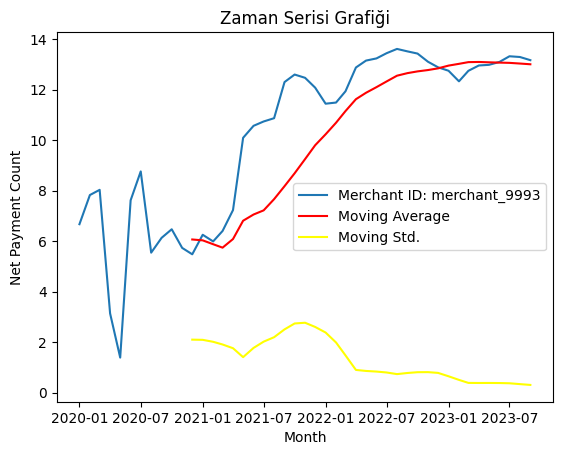

In [122]:
def plot_merchant(merge_df, merchant_id):
    data = merge_df[merge_df['merchant_id'] == merchant_id]
    merchant_data = data.sort_values(by=['month_id'])
    
    ts_log = np.log(merchant_data['net_payment_count'])
    moving_avg = ts_log.rolling(12).mean()
    moving_std = ts_log.rolling(12).std()
    #plt.plot(ts, color='red')
    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(moving_avg, color='red', label='Moving Average')
    plt.plot(moving_std, color='yellow', label='Moving Std.')

    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('Zaman Serisi Grafiği')

    plt.show()


plot_merchant(merge_df,'merchant_33179')

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_33179:

                 Forecast
2023-10-01  556560.545675
2023-11-01  589087.546229
2023-12-01  547880.550622


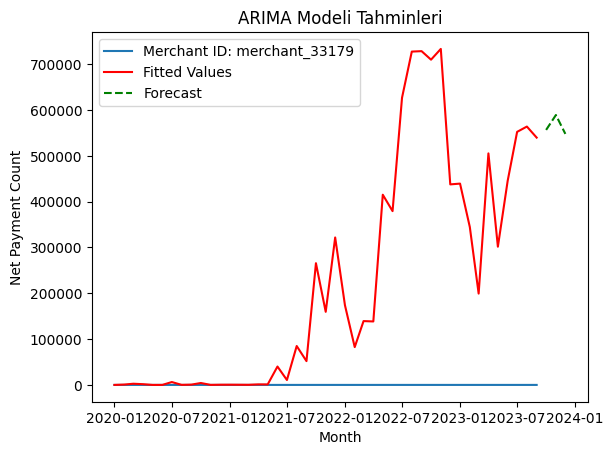

In [123]:
def forecast_merchant(merge_df, merchant_id, forecast_periods=3):
    data = merge_df[merge_df['merchant_id'] == merchant_id]
    merchant_data = data.sort_values(by=['month_id'])

    ts_log = np.log(merchant_data['net_payment_count'])

    # ARIMA modelini oluşturun ve eğitin
    model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))  
    results_ARIMA = model.fit()

    # Tahminleri alın
    forecast = results_ARIMA.get_forecast(steps=forecast_periods)

    # Tahminleri indeks ile eşleştirin
    forecast_index = pd.date_range(start=ts_log.index[-1], periods=forecast_periods+1, freq='MS')[1:]
    #forecast_index = forecast_index.strftime('%Y-%m')

    forecast_values = np.exp(forecast.predicted_mean)
    # Tahminleri DataFrame olarak oluşturun
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    # Tahminleri göster
    print(f"Forecast for Merchant ID {merchant_id}:\n")
    print(forecast_df)

    # Grafik üzerinde gösterim
    plt.plot(ts_log, label=f'Merchant ID: {merchant_id}')
    plt.plot(np.exp(results_ARIMA.fittedvalues), color='red', label='Fitted Values')
    plt.plot(forecast_df, color='green', linestyle='--', label='Forecast')
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('ARIMA Modeli Tahminleri')

    plt.show()

# Belirli bir 'id' için 3 aylık tahmin yapın
forecast_merchant(merge_df, 'merchant_33179', forecast_periods=3)

In [132]:
def forecast_merchant(merge_df, merchant_id, forecast_periods=3):
    data = merge_df[merge_df['merchant_id'] == merchant_id]
    merchant_data = data.sort_values(by=['month_id'])

    ts_log = np.log(merchant_data['net_payment_count'])

    # ARIMA modelini oluşturun ve eğitin
    model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))  
    results_ARIMA = model.fit()

    # Tahminleri alın
    forecast = results_ARIMA.get_forecast(steps=forecast_periods)

    # Tahminleri indeks ile eşleştirin
    forecast_index = pd.date_range(start=ts_log.index[-1], periods=forecast_periods+1, freq='MS')[1:]
    #forecast_index = forecast_index.strftime('%Y-%m')

    forecast_values = np.exp(forecast.predicted_mean)
    # Tahminleri DataFrame olarak oluşturun
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    # Tahminleri göster
    print(f"Forecast for Merchant ID {merchant_id}:\n")
    print(forecast_df)


# Belirli bir 'id' için 3 aylık tahmin yapın
forecast_merchant(merge_df, 'merchant_33179', forecast_periods=3)

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_33179:

                 Forecast
2023-10-01  556560.545675
2023-11-01  589087.546229
2023-12-01  547880.550622


In [134]:
def forecast_all_merchants(merge_df, forecast_periods=3):
    unique_ids = merge_df['merchant_id'].unique()

    for merchant_id in unique_ids:
        forecast_merchant(merge_df, merchant_id, forecast_periods)

# Tüm merchant'lar için 3 aylık tahmin yapın
forecast_all_merchants(merge_df, forecast_periods=3)

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1:

            Forecast
2023-10-01  1.079295
2023-11-01  1.022873
2023-12-01  1.079200
Forecast for Merchant ID merchant_10:

            Forecast
2023-10-01  1.131286
2023-11-01  1.240893
2023-12-01  1.081133


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10000:

            Forecast
2023-10-01  3.115516
2023-11-01  2.995350
2023-12-01  3.052141


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10001:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10002:

            Forecast
2023-10-01  1.030245
2023-11-01  1.032014
2023-12-01  1.025679
Forecast for Merchant ID merchant_10003:

            Forecast
2023-10-01  0.999996
2023-11-01  1.730015
2023-12-01  1.730020


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10005:

            Forecast
2023-10-01  0.999974
2023-11-01  0.999998
2023-12-01  1.000006


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10006:

            Forecast
2023-10-01  3.267539
2023-11-01  1.141055
2023-12-01  0.654410


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10007:

            Forecast
2023-10-01  1.025392
2023-11-01  1.024047
2023-12-01  1.025399
Forecast for Merchant ID merchant_10008:

            Forecast
2023-10-01  1.546672
2023-11-01  0.997393
2023-12-01  1.247324


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10013:

            Forecast
2023-10-01  1.030571
2023-11-01  1.054898
2023-12-01  1.054825
Forecast for Merchant ID merchant_10025:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10026:

            Forecast
2023-10-01  1.215393
2023-11-01  1.133996
2023-12-01  1.171899
Forecast for Merchant ID merchant_10027:

              Forecast
2023-10-01  130.738537
2023-11-01   76.217554
2023-12-01   89.957448


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10028:

            Forecast
2023-10-01  1.000368
2023-11-01  0.999929
2023-12-01  1.000267


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10034:

            Forecast
2023-10-01  1.000040
2023-11-01  1.000042
2023-12-01  1.000054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10036:

            Forecast
2023-10-01  1.107843
2023-11-01  1.470328
2023-12-01  1.822906
Forecast for Merchant ID merchant_10038:

            Forecast
2023-10-01  0.763236
2023-11-01  0.602894
2023-12-01  0.522707


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10044:

            Forecast
2023-10-01  1.000003
2023-11-01  1.000004
2023-12-01  1.000003


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10046:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10048:

            Forecast
2023-10-01  1.004747
2023-11-01  1.000470
2023-12-01  0.994792


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1005:

            Forecast
2023-10-01  1.055383
2023-11-01  1.076505
2023-12-01  1.073641


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10052:

            Forecast
2023-10-01  1.006326
2023-11-01  1.010388
2023-12-01  1.009571


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10053:

            Forecast
2023-10-01  0.892041
2023-11-01  0.911042
2023-12-01  0.963054
Forecast for Merchant ID merchant_10054:

            Forecast
2023-10-01  5.060442
2023-11-01  4.703842
2023-12-01  4.953368


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10057:

            Forecast
2023-10-01  7.705801
2023-11-01  7.578178
2023-12-01  7.314486
Forecast for Merchant ID merchant_10058:

            Forecast
2023-10-01  0.972176
2023-11-01  1.093069
2023-12-01  1.014306


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10059:

            Forecast
2023-10-01  1.098208
2023-11-01  1.169899
2023-12-01  1.207679
Forecast for Merchant ID merchant_10064:

            Forecast
2023-10-01  1.117430
2023-11-01  1.163679
2023-12-01  1.215672


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10068:

            Forecast
2023-10-01  1.067985
2023-11-01  1.093108
2023-12-01  1.071595
Forecast for Merchant ID merchant_10069:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1007:

            Forecast
2023-10-01  1.100005
2023-11-01  1.121817
2023-12-01  1.114374
Forecast for Merchant ID merchant_10072:

             Forecast
2023-10-01  89.481152
2023-11-01  82.869264
2023-12-01  86.176635


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/l

Forecast for Merchant ID merchant_10073:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN
Forecast for Merchant ID merchant_10076:

            Forecast
2023-10-01  4.134387
2023-11-01  3.844251
2023-12-01  3.459381


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10078:

             Forecast
2023-10-01  64.731528
2023-11-01  56.286472
2023-12-01  58.263285
Forecast for Merchant ID merchant_10084:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10087:

            Forecast
2023-10-01  1.077141
2023-11-01  1.033160
2023-12-01  1.062276


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10088:

            Forecast
2023-10-01  1.089085
2023-11-01  1.126054
2023-12-01  1.129393
Forecast for Merchant ID merchant_10090:

            Forecast
2023-10-01  1.221534
2023-11-01  3.515204
2023-12-01  1.180922


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10091:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10096:

            Forecast
2023-10-01  1.032266
2023-11-01  1.043457
2023-12-01  1.063652
Forecast for Merchant ID merchant_10098:

            Forecast
2023-10-01  0.999180
2023-11-01  1.001669
2023-12-01  0.999838


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_101:

             Forecast
2023-10-01  19.058958
2023-11-01  19.055604
2023-12-01  18.736921


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1010:

            Forecast
2023-10-01  2.685012
2023-11-01  1.140752
2023-12-01  2.327732
Forecast for Merchant ID merchant_10107:

            Forecast
2023-10-01  1.014156
2023-11-01  0.905865
2023-12-01  0.894485
Forecast for Merchant ID merchant_10108:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10110:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10111:

            Forecast
2023-10-01  1.602574
2023-11-01  1.466581
2023-12-01  1.876631
Forecast for Merchant ID merchant_10113:

             Forecast
2023-10-01  17.566387
2023-11-01  14.819122
2023-12-01  16.712166


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10114:

            Forecast
2023-10-01  1.053386
2023-11-01  1.052329
2023-12-01  1.068643
Forecast for Merchant ID merchant_10116:

            Forecast
2023-10-01  0.999999
2023-11-01  1.056705
2023-12-01  1.056706


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1012:

            Forecast
2023-10-01  1.560545
2023-11-01  2.081386
2023-12-01  1.876969


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10122:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524
Forecast for Merchant ID merchant_10123:

            Forecast
2023-10-01  1.695479
2023-11-01  1.678814
2023-12-01  2.123042


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10124:

            Forecast
2023-10-01  1.223613
2023-11-01  1.225174
2023-12-01  1.220141
Forecast for Merchant ID merchant_1013:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10131:

            Forecast
2023-10-01  0.975902
2023-11-01  1.246041
2023-12-01  1.230504
Forecast for Merchant ID merchant_10132:

            Forecast
2023-10-01  1.003416
2023-11-01  1.001474
2023-12-01  1.001242


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10134:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10135:

            Forecast
2023-10-01  0.901760
2023-11-01  0.850432
2023-12-01  0.863687
Forecast for Merchant ID merchant_10142:

            Forecast
2023-10-01  2.235069
2023-11-01  1.709365
2023-12-01  1.828165


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10144:

            Forecast
2023-10-01  1.112536
2023-11-01  1.096578
2023-12-01  1.117080


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10145:

            Forecast
2023-10-01  1.053599
2023-11-01  1.080369
2023-12-01  1.100658
Forecast for Merchant ID merchant_1015:

            Forecast
2023-10-01  3.081099
2023-11-01  3.232560
2023-12-01  3.124303


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10151:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10159:

            Forecast
2023-10-01  0.999596
2023-11-01  0.970134
2023-12-01  0.989475
Forecast for Merchant ID merchant_10160:

            Forecast
2023-10-01  1.139111
2023-11-01  1.288295
2023-12-01  1.357612


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10161:

            Forecast
2023-10-01  0.998482
2023-11-01  0.998479
2023-12-01  0.998316


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10162:

            Forecast
2023-10-01  6.872138
2023-11-01  6.615021
2023-12-01  6.388313


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10164:

             Forecast
2023-10-01  27.740598
2023-11-01  25.981060
2023-12-01  31.980839
Forecast for Merchant ID merchant_10168:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1017:

               Forecast
2023-10-01  2385.588340
2023-11-01  2342.295531
2023-12-01  2361.630180
Forecast for Merchant ID merchant_10170:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10178:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10179:

            Forecast
2023-10-01  4.358177
2023-11-01  6.191333
2023-12-01  4.320854
Forecast for Merchant ID merchant_10182:

            Forecast
2023-10-01  1.057642
2023-11-01  1.099570
2023-12-01  1.110363


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10185:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10186:

            Forecast
2023-10-01  0.905164
2023-11-01  0.903475
2023-12-01  0.949528
Forecast for Merchant ID merchant_10187:

            Forecast
2023-10-01  5.136688
2023-11-01  5.045989
2023-12-01  5.123773


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10189:

            Forecast
2023-10-01  0.999999
2023-11-01  1.079865
2023-12-01  1.079865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10191:

            Forecast
2023-10-01  1.000009
2023-11-01  0.999999
2023-12-01  1.000007


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10192:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_10196:

            Forecast
2023-10-01  1.039157
2023-11-01  1.059177
2023-12-01  1.040918


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10197:

             Forecast
2023-10-01  16.912439
2023-11-01  12.815615
2023-12-01  12.104817


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10198:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_102:

            Forecast
2023-10-01  9.238137
2023-11-01  9.811831
2023-12-01  9.749572


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10201:

            Forecast
2023-10-01  1.053747
2023-11-01  1.101023
2023-12-01  1.127576
Forecast for Merchant ID merchant_10203:

            Forecast
2023-10-01  1.111582
2023-11-01  1.111581
2023-12-01  1.146961
Forecast for Merchant ID merchant_10204:

            Forecast
2023-10-01  0.999999
2023-11-01  1.079865
2023-12-01  1.079865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_1021:

            Forecast
2023-10-01  1.070309
2023-11-01  1.089954
2023-12-01  1.087617


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10211:

            Forecast
2023-10-01  2.496145
2023-11-01  2.555330
2023-12-01  2.964015
Forecast for Merchant ID merchant_10217:

            Forecast
2023-10-01  1.880982
2023-11-01  2.758522
2023-12-01  2.951023


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10218:

            Forecast
2023-10-01  1.731875
2023-11-01  1.569528
2023-12-01  1.984735


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1022:

            Forecast
2023-10-01  0.999987
2023-11-01  2.444843
2023-12-01  2.444883


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_10220:

            Forecast
2023-10-01  1.030991
2023-11-01  1.055779
2023-12-01  1.055684
Forecast for Merchant ID merchant_10221:

            Forecast
2023-10-01  3.090827
2023-11-01  3.081283
2023-12-01  3.082272


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10223:

             Forecast
2023-10-01  15.713410
2023-11-01  17.213682
2023-12-01  15.192397
Forecast for Merchant ID merchant_10224:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10228:

            Forecast
2023-10-01  1.031760
2023-11-01  1.030859
2023-12-01  1.031712
Forecast for Merchant ID merchant_10229:

            Forecast
2023-10-01  0.996967
2023-11-01  1.000726
2023-12-01  1.000035


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10231:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_10234:

             Forecast
2023-10-01   4.144513
2023-11-01   4.572037
2023-12-01  10.928653


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10237:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10238:

            Forecast
2023-10-01  1.000103
2023-11-01  1.000077
2023-12-01  1.000061


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10239:

            Forecast
2023-10-01  1.225394
2023-11-01  1.360247
2023-12-01  1.298679


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1024:

            Forecast
2023-10-01  1.048415
2023-11-01  1.050343
2023-12-01  1.041791


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10243:

            Forecast
2023-10-01  1.063652
2023-11-01  1.102271
2023-12-01  1.135869
Forecast for Merchant ID merchant_10244:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_10245:

            Forecast
2023-10-01  0.997024
2023-11-01  0.999764
2023-12-01  0.998920


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10247:

            Forecast
2023-10-01  1.387552
2023-11-01  2.107782
2023-12-01  1.535710
Forecast for Merchant ID merchant_10254:

            Forecast
2023-10-01  0.999593
2023-11-01  1.008326
2023-12-01  1.009429


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10255:

            Forecast
2023-10-01  1.038608
2023-11-01  1.056652
2023-12-01  1.077028
Forecast for Merchant ID merchant_10261:

            Forecast
2023-10-01  1.001720
2023-11-01  1.002036
2023-12-01  1.001821


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10264:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_10265:

            Forecast
2023-10-01  1.036886
2023-11-01  1.021448
2023-12-01  1.038819
Forecast for Merchant ID merchant_1027:

            Forecast
2023-10-01  5.433678
2023-11-01  5.369427
2023-12-01  5.388656


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10270:

            Forecast
2023-10-01  4.238542
2023-11-01  4.534664
2023-12-01  4.294704
Forecast for Merchant ID merchant_10272:

            Forecast
2023-10-01  3.731769
2023-11-01  4.029039
2023-12-01  3.802542


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10275:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177
Forecast for Merchant ID merchant_10276:

            Forecast
2023-10-01  1.005440
2023-11-01  1.002216
2023-12-01  1.005327


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10279:

            Forecast
2023-10-01  0.861730
2023-11-01  0.707431
2023-12-01  0.576466
Forecast for Merchant ID merchant_1028:

            Forecast
2023-10-01  4.136182
2023-11-01  4.267061
2023-12-01  4.287402


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10282:

            Forecast
2023-10-01  1.064865
2023-11-01  1.107336
2023-12-01  1.141190
Forecast for Merchant ID merchant_10283:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10285:

            Forecast
2023-10-01  7.121631
2023-11-01  7.177708
2023-12-01  7.186256


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10287:

            Forecast
2023-10-01  1.031320
2023-11-01  1.201121
2023-12-01  0.997000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

Forecast for Merchant ID merchant_10289:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_10291:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10292:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153
Forecast for Merchant ID merchant_10294:

            Forecast
2023-10-01  4.786977
2023-11-01  4.847719
2023-12-01  4.823328


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10295:

            Forecast
2023-10-01  1.000044
2023-11-01  1.000090
2023-12-01  1.000111
Forecast for Merchant ID merchant_10296:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10297:

            Forecast
2023-10-01  1.434838
2023-11-01  2.232781
2023-12-01  1.701386
Forecast for Merchant ID merchant_103:

            Forecast
2023-10-01  4.350350
2023-11-01  4.241738
2023-12-01  4.048059


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1030:

            Forecast
2023-10-01  1.000000
2023-11-01  1.062412
2023-12-01  1.062413


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10305:

              Forecast
2023-10-01  715.131832
2023-11-01  735.326028
2023-12-01  713.521363
Forecast for Merchant ID merchant_10306:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10310:

            Forecast
2023-10-01  3.961812
2023-11-01  3.961300
2023-12-01  3.932934


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10316:

            Forecast
2023-10-01  1.045739
2023-11-01  0.969854
2023-12-01  1.028572


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1032:

            Forecast
2023-10-01  0.669633
2023-11-01  0.653966
2023-12-01  0.753468


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

Forecast for Merchant ID merchant_10321:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN
Forecast for Merchant ID merchant_10323:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10330:

             Forecast
2023-10-01  32.331008
2023-11-01  32.524012
2023-12-01  32.498155


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10331:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177
Forecast for Merchant ID merchant_10335:

            Forecast
2023-10-01  1.458578
2023-11-01  1.632344
2023-12-01  1.370399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10340:

            Forecast
2023-10-01  1.018213
2023-11-01  1.018031
2023-12-01  1.018050
Forecast for Merchant ID merchant_10341:

            Forecast
2023-10-01  0.958766
2023-11-01  2.046640
2023-12-01  0.993072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10347:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_10349:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10352:

             Forecast
2023-10-01  24.975323
2023-11-01  29.299113
2023-12-01  29.376668
Forecast for Merchant ID merchant_10353:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10355:

            Forecast
2023-10-01  1.068042
2023-11-01  1.048576
2023-12-01  1.064084
Forecast for Merchant ID merchant_10360:

            Forecast
2023-10-01  1.013625
2023-11-01  1.020019
2023-12-01  1.022264


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10364:

            Forecast
2023-10-01  1.015757
2023-11-01  0.993053
2023-12-01  1.018065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10367:

            Forecast
2023-10-01  1.074842
2023-11-01  1.032518
2023-12-01  1.064569


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10369:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951
Forecast for Merchant ID merchant_1037:

            Forecast
2023-10-01  1.970914
2023-11-01  1.955866
2023-12-01  1.717128


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10373:

            Forecast
2023-10-01  2.008623
2023-11-01  2.298005
2023-12-01  2.219270


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10375:

            Forecast
2023-10-01  1.000042
2023-11-01  1.000009
2023-12-01  1.000042
Forecast for Merchant ID merchant_10377:

            Forecast
2023-10-01  3.009525
2023-11-01  3.230646
2023-12-01  3.070103


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10378:

            Forecast
2023-10-01   1.00000
2023-11-01   1.04913
2023-12-01   1.04913


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1038:

            Forecast
2023-10-01  1.116510
2023-11-01  1.175399
2023-12-01  1.217529
Forecast for Merchant ID merchant_10382:

            Forecast
2023-10-01  7.939157
2023-11-01  7.815857
2023-12-01  7.505401


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10384:

            Forecast
2023-10-01  1.021988
2023-11-01  1.032949
2023-12-01  1.037126


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10386:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10388:

            Forecast
2023-10-01  2.320746
2023-11-01  2.315636
2023-12-01  2.205444


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10389:

            Forecast
2023-10-01  1.000044
2023-11-01  1.000167
2023-12-01  1.000046
Forecast for Merchant ID merchant_1039:

            Forecast
2023-10-01  1.046709
2023-11-01  1.050802
2023-12-01  1.048603


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10390:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386
Forecast for Merchant ID merchant_104:

            Forecast
2023-10-01  1.023047
2023-11-01  1.022816
2023-12-01  1.022840


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10402:

            Forecast
2023-10-01  1.002563
2023-11-01  1.132849
2023-12-01  1.119982


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10404:

            Forecast
2023-10-01  1.032756
2023-11-01  1.045553
2023-12-01  1.061447
Forecast for Merchant ID merchant_10405:

            Forecast
2023-10-01  1.049330
2023-11-01  1.048120
2023-12-01  1.048804


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10410:

            Forecast
2023-10-01  0.642846
2023-11-01  1.795568
2023-12-01  1.606432


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10411:

            Forecast
2023-10-01  1.032249
2023-11-01  1.030394
2023-12-01  1.032177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10412:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201
Forecast for Merchant ID merchant_10413:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10418:

            Forecast
2023-10-01  1.037353
2023-11-01  1.036414
2023-12-01  1.039378


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1042:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392
Forecast for Merchant ID merchant_10422:

            Forecast
2023-10-01  1.000029
2023-11-01  1.000035
2023-12-01  1.000026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10423:

            Forecast
2023-10-01  3.748791
2023-11-01  4.295454
2023-12-01  4.562234
Forecast for Merchant ID merchant_10424:

            Forecast
2023-10-01  0.929122
2023-11-01  0.924319
2023-12-01  0.988499


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10426:

            Forecast
2023-10-01  0.923485
2023-11-01  1.040017
2023-12-01  0.966137
Forecast for Merchant ID merchant_10427:

            Forecast
2023-10-01  2.249704
2023-11-01  2.033516
2023-12-01  2.100440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10429:

            Forecast
2023-10-01  0.960928
2023-11-01  1.036408
2023-12-01  1.001464


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10430:

            Forecast
2023-10-01  0.999987
2023-11-01  0.999997
2023-12-01  0.999995


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_10432:

            Forecast
2023-10-01  0.629372
2023-11-01  1.539331
2023-12-01  1.726972
Forecast for Merchant ID merchant_10433:

            Forecast
2023-10-01  0.981664
2023-11-01  1.012370
2023-12-01  0.996022


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10434:

             Forecast
2023-10-01  13.749227
2023-11-01  13.217351
2023-12-01  13.622405


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10438:

            Forecast
2023-10-01  0.989989
2023-11-01  1.003479
2023-12-01  0.994823
Forecast for Merchant ID merchant_10439:

             Forecast
2023-10-01  10.196571
2023-11-01   8.649119
2023-12-01   8.885336


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10440:

            Forecast
2023-10-01  0.806148
2023-11-01  1.070827
2023-12-01  1.038292
Forecast for Merchant ID merchant_10441:

            Forecast
2023-10-01  1.659004
2023-11-01  3.358113
2023-12-01  3.142624


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10444:

            Forecast
2023-10-01   0.72316
2023-11-01   1.14534
2023-12-01   0.83129


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10445:

            Forecast
2023-10-01  1.025314
2023-11-01  1.073447
2023-12-01  1.026955
Forecast for Merchant ID merchant_10446:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1045:

            Forecast
2023-10-01  1.186283
2023-11-01  1.370236
2023-12-01  1.425659
Forecast for Merchant ID merchant_10450:

            Forecast
2023-10-01  0.999953
2023-11-01  1.000224
2023-12-01  0.999987


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10451:

              Forecast
2023-10-01  492.403297
2023-11-01  446.476273
2023-12-01  406.279760
Forecast for Merchant ID merchant_10452:

            Forecast
2023-10-01  3.579909
2023-11-01  3.832516
2023-12-01  3.766175


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10453:

            Forecast
2023-10-01  5.051085
2023-11-01  4.878465
2023-12-01  4.906972
Forecast for Merchant ID merchant_10455:

             Forecast
2023-10-01  11.105639
2023-11-01  11.090819
2023-12-01  11.094615


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10456:

            Forecast
2023-10-01       8.0
2023-11-01       8.0
2023-12-01       8.0
Forecast for Merchant ID merchant_10459:

            Forecast
2023-10-01  1.070543
2023-11-01  1.056805
2023-12-01  1.025571


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1046:

            Forecast
2023-10-01  6.689101
2023-11-01  7.248374
2023-12-01  7.660806


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10464:

            Forecast
2023-10-01  2.316388
2023-11-01  5.129611
2023-12-01  3.378997
Forecast for Merchant ID merchant_10470:

            Forecast
2023-10-01  0.904546
2023-11-01  1.038536
2023-12-01  1.001705
Forecast for Merchant ID merchant_10471:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10475:

            Forecast
2023-10-01  1.152822
2023-11-01  1.053638
2023-12-01  1.070639
Forecast for Merchant ID merchant_10479:

            Forecast
2023-10-01  1.339191
2023-11-01  1.337644
2023-12-01  1.300609


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1048:

            Forecast
2023-10-01  1.031647
2023-11-01  1.030954
2023-12-01  1.031614
Forecast for Merchant ID merchant_10481:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10486:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124
Forecast for Merchant ID merchant_10488:

            Forecast
2023-10-01  1.059129
2023-11-01  1.058183
2023-12-01  1.077756


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10494:

            Forecast
2023-10-01  8.938961
2023-11-01  8.180650
2023-12-01  8.023709


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10495:

            Forecast
2023-10-01  0.396933
2023-11-01  0.158076
2023-12-01  0.154700
Forecast for Merchant ID merchant_10497:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10498:

            Forecast
2023-10-01  1.033398
2023-11-01  1.032585
2023-12-01  1.033046


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10502:

            Forecast
2023-10-01  1.049982
2023-11-01  1.069277
2023-12-01  1.045726


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10504:

            Forecast
2023-10-01  3.093041
2023-11-01  2.719249
2023-12-01  2.195062
Forecast for Merchant ID merchant_10508:

            Forecast
2023-10-01  1.000001
2023-11-01  1.000000
2023-12-01  1.000000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10509:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10511:

              Forecast
2023-10-01  211.409850
2023-11-01  201.506879
2023-12-01  196.393716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10512:

            Forecast
2023-10-01  1.165646
2023-11-01  1.030224
2023-12-01  1.025926
Forecast for Merchant ID merchant_10514:

            Forecast
2023-10-01  1.037051
2023-11-01  1.035831
2023-12-01  1.037011


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10516:

            Forecast
2023-10-01  1.040735
2023-11-01  1.040350
2023-12-01  1.040708
Forecast for Merchant ID merchant_10526:

            Forecast
2023-10-01  1.028602
2023-11-01  1.060296
2023-12-01  1.019051


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1053:

            Forecast
2023-10-01  1.085298
2023-11-01  1.170228
2023-12-01  1.205617
Forecast for Merchant ID merchant_10530:

            Forecast
2023-10-01  5.016696
2023-11-01  5.363075
2023-12-01  5.497715


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10532:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10534:

            Forecast
2023-10-01  1.102101
2023-11-01  1.137155
2023-12-01  1.145575
Forecast for Merchant ID merchant_10536:

            Forecast
2023-10-01  1.003983
2023-11-01  1.001799
2023-12-01  1.004349


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1054:

            Forecast
2023-10-01  0.311711
2023-11-01  0.256090
2023-12-01  0.577745


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10541:

            Forecast
2023-10-01  0.946918
2023-11-01  0.966210
2023-12-01  0.985744


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10542:

            Forecast
2023-10-01  1.079098
2023-11-01  1.022996
2023-12-01  1.079072
Forecast for Merchant ID merchant_10543:

            Forecast
2023-10-01  1.035283
2023-11-01  0.998780
2023-12-01  1.034342
Forecast for Merchant ID merchant_10545:

            Forecast
2023-10-01  1.014269
2023-11-01  1.011682
2023-12-01  1.009798


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10552:

            Forecast
2023-10-01   1.05749
2023-11-01   1.07902
2023-12-01   1.07721
Forecast for Merchant ID merchant_10554:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10556:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524
Forecast for Merchant ID merchant_1056:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10561:

            Forecast
2023-10-01  1.783035
2023-11-01  1.229215
2023-12-01  1.175961
Forecast for Merchant ID merchant_10568:

            Forecast
2023-10-01  1.024720
2023-11-01  1.148391
2023-12-01  1.121885


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10569:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_1057:

            Forecast
2023-10-01  4.153461
2023-11-01  4.173978
2023-12-01  4.176672


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10570:

            Forecast
2023-10-01  2.750575
2023-11-01  3.008912
2023-12-01  2.789808
Forecast for Merchant ID merchant_10571:

            Forecast
2023-10-01  1.004268
2023-11-01  1.005174
2023-12-01  1.004527


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10572:

            Forecast
2023-10-01  1.002803
2023-11-01  1.002511
2023-12-01  1.002860
Forecast for Merchant ID merchant_10578:

            Forecast
2023-10-01  1.013028
2023-11-01  1.019033
2023-12-01  1.013335


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10579:

            Forecast
2023-10-01  2.021964
2023-11-01  2.565090
2023-12-01  1.500779
Forecast for Merchant ID merchant_10580:

            Forecast
2023-10-01  3.604708
2023-11-01  4.597682
2023-12-01  4.602540


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10582:

            Forecast
2023-10-01  1.090786
2023-11-01  1.149760
2023-12-01  1.144080


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10586:

            Forecast
2023-10-01  0.862760
2023-11-01  0.842977
2023-12-01  0.963398


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10588:

            Forecast
2023-10-01  1.017899
2023-11-01  0.991773
2023-12-01  1.005435
Forecast for Merchant ID merchant_10589:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10590:

            Forecast
2023-10-01  0.993239
2023-11-01  1.024628
2023-12-01  1.024851


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10595:

            Forecast
2023-10-01  1.049662
2023-11-01  1.111634
2023-12-01  1.161629
Forecast for Merchant ID merchant_10596:

            Forecast
2023-10-01  0.978823
2023-11-01  1.026184
2023-12-01  0.993277


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1060:

            Forecast
2023-10-01  1.143531
2023-11-01  1.168706
2023-12-01  1.190537


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10600:

            Forecast
2023-10-01  5.998398
2023-11-01  8.661923
2023-12-01  6.571253
Forecast for Merchant ID merchant_10605:

            Forecast
2023-10-01  1.331403
2023-11-01  0.794733
2023-12-01  1.226251


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10607:

               Forecast
2023-10-01  1135.383772
2023-11-01  1132.050003
2023-12-01  1067.714389


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10609:

            Forecast
2023-10-01  7.500345
2023-11-01  5.708807
2023-12-01  5.825179
Forecast for Merchant ID merchant_1061:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10610:

            Forecast
2023-10-01  0.987964
2023-11-01  1.004165
2023-12-01  0.990807
Forecast for Merchant ID merchant_10611:

            Forecast
2023-10-01  1.001355
2023-11-01  1.000642
2023-12-01  0.999035


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10612:

            Forecast
2023-10-01  0.934190
2023-11-01  0.854252
2023-12-01  0.808748
Forecast for Merchant ID merchant_10614:

            Forecast
2023-10-01  0.999997
2023-11-01  1.049096
2023-12-01  1.049099


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10615:

            Forecast
2023-10-01  6.490571
2023-11-01  6.707204
2023-12-01  7.335479


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10616:

             Forecast
2023-10-01  13.388971
2023-11-01  13.297573
2023-12-01  13.747061
Forecast for Merchant ID merchant_10629:

            Forecast
2023-10-01  6.271316
2023-11-01  5.574777
2023-12-01  5.972893


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1063:

             Forecast
2023-10-01  38.138875
2023-11-01  36.492739
2023-12-01  36.488526
Forecast for Merchant ID merchant_10633:

            Forecast
2023-10-01  6.241577
2023-11-01  6.214614
2023-12-01  6.001377


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10635:

            Forecast
2023-10-01  0.979748
2023-11-01  1.044576
2023-12-01  1.003631
Forecast for Merchant ID merchant_10636:

                Forecast
2023-10-01  6.912199e+03
2023-11-01  2.071206e+05
2023-12-01  1.931526e+06


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10637:

            Forecast
2023-10-01  1.300034
2023-11-01  1.364543
2023-12-01  1.297622
Forecast for Merchant ID merchant_10640:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10644:

            Forecast
2023-10-01  1.160084
2023-11-01  1.186418
2023-12-01  1.195944
Forecast for Merchant ID merchant_10645:

            Forecast
2023-10-01  4.574921
2023-11-01  4.408399
2023-12-01  4.352397


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10646:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741
Forecast for Merchant ID merchant_10647:

            Forecast
2023-10-01  1.174143
2023-11-01  1.324763
2023-12-01  1.376687
Forecast for Merchant ID merchant_10649:

             Forecast
2023-10-01  13.153886
2023-11-01  12.274672
2023-12-01  12.157123


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10650:

            Forecast
2023-10-01  1.063893
2023-11-01  1.126666
2023-12-01  1.162885


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10651:

            Forecast
2023-10-01  1.040439
2023-11-01  1.065421
2023-12-01  1.065316
Forecast for Merchant ID merchant_10655:

            Forecast
2023-10-01  1.044662
2023-11-01  1.046429
2023-12-01  1.054665


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10656:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10657:

            Forecast
2023-10-01  0.687788
2023-11-01  0.643345
2023-12-01  0.988684


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10661:

            Forecast
2023-10-01  1.705952
2023-11-01  1.692713
2023-12-01  1.264337
Forecast for Merchant ID merchant_10664:

            Forecast
2023-10-01  1.099757
2023-11-01  1.060124
2023-12-01  1.049470


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10665:

            Forecast
2023-10-01  0.885561
2023-11-01  0.983117
2023-12-01  0.972893
Forecast for Merchant ID merchant_10666:

            Forecast
2023-10-01  1.131708
2023-11-01  1.193665
2023-12-01  1.216038


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10669:

            Forecast
2023-10-01  1.026059
2023-11-01  1.086692
2023-12-01  1.009409


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10671:

            Forecast
2023-10-01  1.043663
2023-11-01  1.055425
2023-12-01  1.080026
Forecast for Merchant ID merchant_10673:

            Forecast
2023-10-01  7.174721
2023-11-01  6.305188
2023-12-01  6.387032


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10677:

             Forecast
2023-10-01  38.059128
2023-11-01  30.187164
2023-12-01  26.076032
Forecast for Merchant ID merchant_10678:

            Forecast
2023-10-01  1.000001
2023-11-01  1.036925
2023-12-01  1.036925


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10679:

              Forecast
2023-10-01  128.364890
2023-11-01  147.435787
2023-12-01  107.427148
Forecast for Merchant ID merchant_1068:

            Forecast
2023-10-01  3.226086
2023-11-01  2.680582
2023-12-01  2.877996


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10680:

            Forecast
2023-10-01  1.066486
2023-11-01  1.065032
2023-12-01  1.083217
Forecast for Merchant ID merchant_10682:

            Forecast
2023-10-01  1.056385
2023-11-01  0.976583
2023-12-01  1.040934


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10684:

            Forecast
2023-10-01  1.052200
2023-11-01  1.037831
2023-12-01  1.052877
Forecast for Merchant ID merchant_10685:

            Forecast
2023-10-01  3.609619
2023-11-01  3.311594
2023-12-01  3.592833


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10687:

            Forecast
2023-10-01  7.466511
2023-11-01  7.821392
2023-12-01  7.880598


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1069:

            Forecast
2023-10-01  1.101216
2023-11-01  1.152443
2023-12-01  1.201260
Forecast for Merchant ID merchant_10690:

            Forecast
2023-10-01  1.095570
2023-11-01  1.265749
2023-12-01  1.234815


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10694:

            Forecast
2023-10-01  1.037349
2023-11-01  1.035650
2023-12-01  1.037214
Forecast for Merchant ID merchant_10695:

            Forecast
2023-10-01  0.999994
2023-11-01  1.062435
2023-12-01  1.062441


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10696:

            Forecast
2023-10-01  1.111380
2023-11-01  1.112174
2023-12-01  1.075203


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10698:

            Forecast
2023-10-01  4.502658
2023-11-01  4.907869
2023-12-01  4.548753
Forecast for Merchant ID merchant_10700:

            Forecast
2023-10-01  0.999981
2023-11-01  1.000004
2023-12-01  0.999989


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10702:

            Forecast
2023-10-01  1.462216
2023-11-01  1.807688
2023-12-01  1.466361


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10705:

            Forecast
2023-10-01  1.000000
2023-11-01  1.029154
2023-12-01  1.029155


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10706:

            Forecast
2023-10-01  1.030851
2023-11-01  1.055368
2023-12-01  1.055285
Forecast for Merchant ID merchant_10708:

            Forecast
2023-10-01  4.711826
2023-11-01  4.576032
2023-12-01  4.168304


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10709:

            Forecast
2023-10-01  2.929566
2023-11-01  2.293197
2023-12-01  2.093937
Forecast for Merchant ID merchant_10712:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10713:

            Forecast
2023-10-01  1.031551
2023-11-01  1.014344
2023-12-01  1.030929
Forecast for Merchant ID merchant_10714:

            Forecast
2023-10-01  4.153240
2023-11-01  4.153240
2023-12-01  4.172839


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10715:

            Forecast
2023-10-01  1.014609
2023-11-01  0.999546
2023-12-01  1.013428
Forecast for Merchant ID merchant_10717:

            Forecast
2023-10-01  1.000000
2023-11-01  1.049034
2023-12-01  1.049034


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10722:

            Forecast
2023-10-01  1.098317
2023-11-01  1.094978
2023-12-01  1.124227
Forecast for Merchant ID merchant_10727:

            Forecast
2023-10-01  1.004835
2023-11-01  1.205185
2023-12-01  1.098808


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1073:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_10732:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10736:

            Forecast
2023-10-01  6.594092
2023-11-01  6.915656
2023-12-01  6.944944


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10737:

            Forecast
2023-10-01  1.085768
2023-11-01  1.123355
2023-12-01  1.118653


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10738:

             Forecast
2023-10-01  79.993350
2023-11-01  68.139693
2023-12-01  72.195973


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1074:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10740:

             Forecast
2023-10-01  31.283118
2023-11-01  26.504307
2023-12-01  25.628472


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10741:

            Forecast
2023-10-01  1.217568
2023-11-01  1.117421
2023-12-01  1.210811
Forecast for Merchant ID merchant_10742:

            Forecast
2023-10-01  1.000404
2023-11-01  1.030448
2023-12-01  1.029404


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10743:

            Forecast
2023-10-01  1.021852
2023-11-01  1.096836
2023-12-01  1.029560


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10749:

            Forecast
2023-10-01  0.690082
2023-11-01  1.155959
2023-12-01  1.275049
Forecast for Merchant ID merchant_10750:

            Forecast
2023-10-01  1.205527
2023-11-01  1.885881
2023-12-01  2.878775


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10751:

            Forecast
2023-10-01  0.988776
2023-11-01  1.004347
2023-12-01  0.994929
Forecast for Merchant ID merchant_10753:

            Forecast
2023-10-01  0.750353
2023-11-01  1.892515
2023-12-01  2.428820


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10754:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10757:

            Forecast
2023-10-01  1.031334
2023-11-01  1.063039
2023-12-01  1.080634


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10762:

            Forecast
2023-10-01  8.374606
2023-11-01  7.426852
2023-12-01  7.750498


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10768:

              Forecast
2023-10-01   96.491222
2023-11-01  109.893156
2023-12-01   99.137755
Forecast for Merchant ID merchant_10772:

             Forecast
2023-10-01  25.227798
2023-11-01  23.566375
2023-12-01  24.155234


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10774:

            Forecast
2023-10-01  6.174043
2023-11-01  5.167012
2023-12-01  5.835801


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10775:

             Forecast
2023-10-01  12.509540
2023-11-01  12.384049
2023-12-01  12.587407
Forecast for Merchant ID merchant_10777:

            Forecast
2023-10-01  0.903135
2023-11-01  0.862073
2023-12-01  3.168152


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10780:

            Forecast
2023-10-01  1.085213
2023-11-01  1.105821
2023-12-01  1.138505
Forecast for Merchant ID merchant_10783:

            Forecast
2023-10-01  2.508478
2023-11-01  2.603270
2023-12-01  2.409301


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10786:

            Forecast
2023-10-01  1.016680
2023-11-01  0.998726
2023-12-01  1.014540
Forecast for Merchant ID merchant_1079:

            Forecast
2023-10-01  1.014783
2023-11-01  0.998785
2023-12-01  1.002415


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10790:

            Forecast
2023-10-01  1.074752
2023-11-01  1.058046
2023-12-01  1.001425
Forecast for Merchant ID merchant_10793:

            Forecast
2023-10-01  1.259050
2023-11-01  1.169404
2023-12-01  1.235764


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10794:

            Forecast
2023-10-01  1.694057
2023-11-01  1.801142
2023-12-01  1.725489
Forecast for Merchant ID merchant_10797:

            Forecast
2023-10-01  0.999982
2023-11-01  0.999992
2023-12-01  0.999993


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10798:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_10799:

            Forecast
2023-10-01  1.761463
2023-11-01  1.921231
2023-12-01  2.492526


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1080:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10801:

            Forecast
2023-10-01  0.774031
2023-11-01  0.767454
2023-12-01  0.865638


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10804:

             Forecast
2023-10-01  26.441037
2023-11-01  25.619521
2023-12-01  25.152883


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10806:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292
Forecast for Merchant ID merchant_10807:

            Forecast
2023-10-01  5.814206
2023-11-01  5.671695
2023-12-01  5.601464


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10810:

            Forecast
2023-10-01  2.028467
2023-11-01  2.953293
2023-12-01  2.261468
Forecast for Merchant ID merchant_10811:

            Forecast
2023-10-01  1.189330
2023-11-01  1.919880
2023-12-01  1.530557


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10812:

            Forecast
2023-10-01  1.001064
2023-11-01  1.037278
2023-12-01  1.019573
Forecast for Merchant ID merchant_10815:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10817:

            Forecast
2023-10-01  1.001318
2023-11-01  0.999851
2023-12-01  1.000764
Forecast for Merchant ID merchant_10818:

            Forecast
2023-10-01  1.064556
2023-11-01  1.095027
2023-12-01  1.093077


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1082:

            Forecast
2023-10-01  1.021280
2023-11-01  0.995035
2023-12-01  1.021554
Forecast for Merchant ID merchant_10823:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10830:

            Forecast
2023-10-01  2.049900
2023-11-01  1.918812
2023-12-01  1.857077


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10831:

            Forecast
2023-10-01  5.231632
2023-11-01  4.370573
2023-12-01  4.228047
Forecast for Merchant ID merchant_10833:

            Forecast
2023-10-01  1.169602
2023-11-01  1.256432
2023-12-01  1.339390


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10834:

            Forecast
2023-10-01  1.050478
2023-11-01  1.076379
2023-12-01  1.102015


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10836:

            Forecast
2023-10-01  1.454710
2023-11-01  1.431746
2023-12-01  0.994942
Forecast for Merchant ID merchant_10841:

            Forecast
2023-10-01  0.968110
2023-11-01  0.997893
2023-12-01  1.022908


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_10842:

            Forecast
2023-10-01  2.365029
2023-11-01  2.833488
2023-12-01  2.814829
Forecast for Merchant ID merchant_10845:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10846:

            Forecast
2023-10-01  4.968254
2023-11-01  5.787994
2023-12-01  5.729886
Forecast for Merchant ID merchant_10849:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10851:

            Forecast
2023-10-01  0.927022
2023-11-01  0.980604
2023-12-01  1.144317
Forecast for Merchant ID merchant_10853:

            Forecast
2023-10-01  2.425717
2023-11-01  2.075390
2023-12-01  2.436720


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10855:

            Forecast
2023-10-01  0.963748
2023-11-01  1.041234
2023-12-01  1.055328


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10858:

            Forecast
2023-10-01  0.979781
2023-11-01  1.019161
2023-12-01  0.981885
Forecast for Merchant ID merchant_10861:

            Forecast
2023-10-01  1.472227
2023-11-01  1.531868
2023-12-01  1.330038


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10862:

            Forecast
2023-10-01  1.998717
2023-11-01  1.587002
2023-12-01  1.681187


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10866:

            Forecast
2023-10-01  1.010536
2023-11-01  1.006841
2023-12-01  1.009984
Forecast for Merchant ID merchant_10872:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10875:

            Forecast
2023-10-01  1.050974
2023-11-01  1.048124
2023-12-01  1.049184


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10877:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10878:

            Forecast
2023-10-01  0.983596
2023-11-01  1.005162
2023-12-01  1.014098
Forecast for Merchant ID merchant_10879:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000001
2023-12-01  1.000000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10881:

            Forecast
2023-10-01  1.045518
2023-11-01  1.076058
2023-12-01  1.024826


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10882:

            Forecast
2023-10-01  0.966896
2023-11-01  0.984984
2023-12-01  1.016019
Forecast for Merchant ID merchant_10884:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10888:

            Forecast
2023-10-01  6.606738
2023-11-01  8.347632
2023-12-01  6.773165
Forecast for Merchant ID merchant_1089:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10893:

            Forecast
2023-10-01  1.089912
2023-11-01  1.026028
2023-12-01  1.089893
Forecast for Merchant ID merchant_10895:

            Forecast
2023-10-01  1.001937
2023-11-01  0.999423
2023-12-01  0.998637


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10896:

            Forecast
2023-10-01  1.534823
2023-11-01  1.784049
2023-12-01  1.648959
Forecast for Merchant ID merchant_10897:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153
Forecast for Merchant ID merchant_10898:

            Forecast
2023-10-01  1.026931
2023-11-01  0.997907
2023-12-01  1.022208


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1090:

            Forecast
2023-10-01  4.076638
2023-11-01  7.014326
2023-12-01  6.722261
Forecast for Merchant ID merchant_10900:

            Forecast
2023-10-01  1.324412
2023-11-01  0.828830
2023-12-01  1.881815


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10903:

            Forecast
2023-10-01  1.012666
2023-11-01  1.012256
2023-12-01  1.012047
Forecast for Merchant ID merchant_10906:

            Forecast
2023-10-01  0.980480
2023-11-01  1.084534
2023-12-01  1.054869


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10908:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440
Forecast for Merchant ID merchant_10910:

             Forecast
2023-10-01  45.550926
2023-11-01  44.251783
2023-12-01  43.261824


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10912:

            Forecast
2023-10-01  1.021033
2023-11-01  1.079511
2023-12-01  1.099383
Forecast for Merchant ID merchant_10913:

            Forecast
2023-10-01       6.0
2023-11-01       6.0
2023-12-01       6.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10915:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_10919:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1092:

            Forecast
2023-10-01  0.992055
2023-11-01  0.946657
2023-12-01  0.907885
Forecast for Merchant ID merchant_10924:

            Forecast
2023-10-01  1.104560
2023-11-01  1.057097
2023-12-01  1.091844


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10927:

            Forecast
2023-10-01  1.117687
2023-11-01  1.152218
2023-12-01  1.190729
Forecast for Merchant ID merchant_10928:

            Forecast
2023-10-01  0.998180
2023-11-01  0.998600
2023-12-01  0.999631


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10932:

            Forecast
2023-10-01  1.023817
2023-11-01  1.072429
2023-12-01  1.071057
Forecast for Merchant ID merchant_10933:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10935:

            Forecast
2023-10-01  7.217558
2023-11-01  7.002771
2023-12-01  7.190081
Forecast for Merchant ID merchant_10938:

            Forecast
2023-10-01  1.925667
2023-11-01  2.361642
2023-12-01  2.483250


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10942:

             Forecast
2023-10-01  21.209462
2023-11-01  23.713040
2023-12-01  21.664892
Forecast for Merchant ID merchant_10947:

            Forecast
2023-10-01  0.970964
2023-11-01  0.984537
2023-12-01  0.997271


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10948:

            Forecast
2023-10-01  1.002776
2023-11-01  1.000044
2023-12-01  1.002184
Forecast for Merchant ID merchant_10949:

            Forecast
2023-10-01  1.517553
2023-11-01  5.092079
2023-12-01  1.530771


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10950:

            Forecast
2023-10-01  3.410881
2023-11-01  3.352946
2023-12-01  3.705133
Forecast for Merchant ID merchant_10952:

            Forecast
2023-10-01  3.770792
2023-11-01  3.897014
2023-12-01  3.862591
Forecast for Merchant ID merchant_10955:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_10956:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_10959:

            Forecast
2023-10-01  9.221358
2023-11-01  7.746152
2023-12-01  9.985502
Forecast for Merchant ID merchant_10960:

            Forecast
2023-10-01  1.087977
2023-11-01  0.791281
2023-12-01  0.642880


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10965:

            Forecast
2023-10-01  1.062878
2023-11-01  1.021001
2023-12-01  0.993882
Forecast for Merchant ID merchant_10967:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10972:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002
Forecast for Merchant ID merchant_10975:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10977:

            Forecast
2023-10-01  1.150205
2023-11-01  1.251923
2023-12-01  1.359395
Forecast for Merchant ID merchant_1098:

            Forecast
2023-10-01  1.854187
2023-11-01  1.947027
2023-12-01  1.729525


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10982:

             Forecast
2023-10-01  16.607247
2023-11-01  15.017137
2023-12-01  15.773371
Forecast for Merchant ID merchant_10983:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10984:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492
Forecast for Merchant ID merchant_10985:

            Forecast
2023-10-01  1.977367
2023-11-01  1.241829
2023-12-01  1.957574


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10986:

            Forecast
2023-10-01  1.415991
2023-11-01  2.046980
2023-12-01  1.192120
Forecast for Merchant ID merchant_10987:

            Forecast
2023-10-01  2.530004
2023-11-01  1.825865
2023-12-01  1.981309


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10989:

            Forecast
2023-10-01  1.040333
2023-11-01  1.076109
2023-12-01  1.096252
Forecast for Merchant ID merchant_10991:

            Forecast
2023-10-01  2.122341
2023-11-01  3.985142
2023-12-01  4.705864


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_10992:

            Forecast
2023-10-01  0.992108
2023-11-01  0.994470
2023-12-01  1.000434
Forecast for Merchant ID merchant_10993:

            Forecast
2023-10-01  1.104514
2023-11-01  1.205948
2023-12-01  1.296883


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_10994:

            Forecast
2023-10-01  1.027766
2023-11-01  1.041529
2023-12-01  1.038832
Forecast for Merchant ID merchant_10995:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10996:

             Forecast
2023-10-01  20.146031
2023-11-01  21.008425
2023-12-01  20.482534
Forecast for Merchant ID merchant_10997:

            Forecast
2023-10-01  4.143187
2023-11-01  4.019328
2023-12-01  4.131780


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_10998:

            Forecast
2023-10-01  8.499850
2023-11-01  8.951599
2023-12-01  9.369116
Forecast for Merchant ID merchant_10999:

            Forecast
2023-10-01  3.762382
2023-11-01  2.366451
2023-12-01  2.285124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1100:

             Forecast
2023-10-01  22.486060
2023-11-01  22.477906
2023-12-01  22.620557
Forecast for Merchant ID merchant_11001:

            Forecast
2023-10-01  1.275385
2023-11-01  1.266980
2023-12-01  1.455377


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11004:

            Forecast
2023-10-01  3.207335
2023-11-01  3.876397
2023-12-01  3.315775


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11005:

            Forecast
2023-10-01  1.015854
2023-11-01  1.015268
2023-12-01  1.015791


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11006:

            Forecast
2023-10-01  2.596550
2023-11-01  2.270054
2023-12-01  1.146336
Forecast for Merchant ID merchant_11007:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1101:

            Forecast
2023-10-01  1.050590
2023-11-01  1.110984
2023-12-01  1.167498
Forecast for Merchant ID merchant_11010:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11012:

            Forecast
2023-10-01  5.090552
2023-11-01  5.097907
2023-12-01  5.098499
Forecast for Merchant ID merchant_11017:

             Forecast
2023-10-01  17.570656
2023-11-01  17.149792
2023-12-01  17.225982


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11018:

            Forecast
2023-10-01  1.106918
2023-11-01  1.201703
2023-12-01  1.195129
Forecast for Merchant ID merchant_11019:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11020:

            Forecast
2023-10-01  1.783455
2023-11-01  1.817215
2023-12-01  2.930082
Forecast for Merchant ID merchant_11021:

            Forecast
2023-10-01  8.083567
2023-11-01  8.675735
2023-12-01  8.885543
Forecast for Merchant ID merchant_11022:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11024:

            Forecast
2023-10-01  3.562304
2023-11-01  3.540075
2023-12-01  3.534710
Forecast for Merchant ID merchant_11030:

            Forecast
2023-10-01  1.057106
2023-11-01  1.124746
2023-12-01  1.167272


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11032:

            Forecast
2023-10-01  1.000157
2023-11-01  1.000210
2023-12-01  1.000239
Forecast for Merchant ID merchant_11033:

            Forecast
2023-10-01  0.998468
2023-11-01  1.141240
2023-12-01  1.181268


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11034:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503
Forecast for Merchant ID merchant_11036:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11037:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11039:

            Forecast
2023-10-01  1.018806
2023-11-01  1.017925
2023-12-01  1.011235


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11040:

                Forecast
2023-10-01  58689.978531
2023-11-01  58721.859585
2023-12-01  58737.923483
Forecast for Merchant ID merchant_11042:

            Forecast
2023-10-01  1.174761
2023-11-01  1.225981
2023-12-01  1.281983


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11043:

            Forecast
2023-10-01  1.040790
2023-11-01  1.061196
2023-12-01  1.061931
Forecast for Merchant ID merchant_11045:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11047:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741
Forecast for Merchant ID merchant_11048:

            Forecast
2023-10-01  2.817274
2023-11-01  3.681250
2023-12-01  3.321253


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11049:

            Forecast
2023-10-01  1.081766
2023-11-01  1.103469
2023-12-01  1.101638
Forecast for Merchant ID merchant_11052:

            Forecast
2023-10-01  1.153254
2023-11-01  1.236420
2023-12-01  1.227925


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11053:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757
Forecast for Merchant ID merchant_11060:

            Forecast
2023-10-01  5.801341
2023-11-01  4.118999
2023-12-01  3.863920


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11062:

            Forecast
2023-10-01  6.518509
2023-11-01  6.963183
2023-12-01  3.860115
Forecast for Merchant ID merchant_11066:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11067:

            Forecast
2023-10-01  0.952720
2023-11-01  0.959509
2023-12-01  0.980673
Forecast for Merchant ID merchant_11071:

            Forecast
2023-10-01  1.031294
2023-11-01  1.056293
2023-12-01  1.056145


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11075:

            Forecast
2023-10-01  1.075337
2023-11-01  1.084073
2023-12-01  1.013521
Forecast for Merchant ID merchant_11077:

            Forecast
2023-10-01  1.367204
2023-11-01  1.437217
2023-12-01  1.560640


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11079:

            Forecast
2023-10-01  1.001108
2023-11-01  1.002448
2023-12-01  1.003418


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11082:

            Forecast
2023-10-01  1.050547
2023-11-01  1.091285
2023-12-01  1.106734


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11084:

            Forecast
2023-10-01  3.066502
2023-11-01  3.377829
2023-12-01  3.039940
Forecast for Merchant ID merchant_11086:

            Forecast
2023-10-01  1.048906
2023-11-01  1.045883
2023-12-01  1.048737


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11087:

            Forecast
2023-10-01  0.989676
2023-11-01  0.989982
2023-12-01  0.997342
Forecast for Merchant ID merchant_11088:

            Forecast
2023-10-01  1.073552
2023-11-01  1.114704
2023-12-01  1.112818


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11091:

            Forecast
2023-10-01  1.043894
2023-11-01  1.053551
2023-12-01  1.025326
Forecast for Merchant ID merchant_11097:

            Forecast
2023-10-01  1.247429
2023-11-01  1.135225
2023-12-01  1.402338


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11099:

             Forecast
2023-10-01  30.423484
2023-11-01  40.146165
2023-12-01  40.990146
Forecast for Merchant ID merchant_1110:

            Forecast
2023-10-01  3.234696
2023-11-01  6.123047
2023-12-01  9.837924


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11100:

            Forecast
2023-10-01  1.237284
2023-11-01  0.999753
2023-12-01  1.235093
Forecast for Merchant ID merchant_11105:

              Forecast
2023-10-01  156.149881
2023-11-01   93.048492
2023-12-01   93.314924


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11109:

            Forecast
2023-10-01  1.769243
2023-11-01  3.450053
2023-12-01  3.890006
Forecast for Merchant ID merchant_1111:

            Forecast
2023-10-01  3.108267
2023-11-01  1.164360
2023-12-01  1.300643


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11114:

            Forecast
2023-10-01  3.642324
2023-11-01  3.335082
2023-12-01  3.263909
Forecast for Merchant ID merchant_11118:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11119:

            Forecast
2023-10-01  1.031708
2023-11-01  1.030974
2023-12-01  1.031606
Forecast for Merchant ID merchant_1112:

            Forecast
2023-10-01  1.026794
2023-11-01  1.026556
2023-12-01  1.026582


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11124:

            Forecast
2023-10-01  1.955169
2023-11-01  1.150495
2023-12-01  1.747953


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11125:

            Forecast
2023-10-01  0.975535
2023-11-01  0.898839
2023-12-01  0.942278
Forecast for Merchant ID merchant_11128:

            Forecast
2023-10-01  6.383849
2023-11-01  5.753121
2023-12-01  6.381469


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11129:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1113:

            Forecast
2023-10-01  0.973855
2023-11-01  1.009252
2023-12-01  0.978911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11131:

            Forecast
2023-10-01  4.260471
2023-11-01  4.087189
2023-12-01  4.614120


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11132:

            Forecast
2023-10-01  1.031754
2023-11-01  1.030917
2023-12-01  1.031661


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11135:

            Forecast
2023-10-01  0.958718
2023-11-01  0.987326
2023-12-01  0.976426


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_11141:

            Forecast
2023-10-01  1.036974
2023-11-01  0.992072
2023-12-01  1.023584
Forecast for Merchant ID merchant_11143:

            Forecast
2023-10-01  1.050974
2023-11-01  1.048124
2023-12-01  1.049184


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11145:

            Forecast
2023-10-01  0.919690
2023-11-01  1.086740
2023-12-01  0.882605
Forecast for Merchant ID merchant_11150:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11152:

            Forecast
2023-10-01  1.203574
2023-11-01  1.350688
2023-12-01  1.531248


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11154:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_11162:

            Forecast
2023-10-01  0.933461
2023-11-01  0.967915
2023-12-01  0.966278


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11165:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11166:

            Forecast
2023-10-01  1.050658
2023-11-01  1.087192
2023-12-01  1.067413
Forecast for Merchant ID merchant_11167:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11168:

            Forecast
2023-10-01  6.434144
2023-11-01  6.325168
2023-12-01  6.668470


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1117:

            Forecast
2023-10-01  1.076058
2023-11-01  1.105838
2023-12-01  1.103369


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11170:

            Forecast
2023-10-01  1.527013
2023-11-01  1.553244
2023-12-01  1.462964


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11173:

            Forecast
2023-10-01  4.000028
2023-11-01  1.173140
2023-12-01  1.173129


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11174:

            Forecast
2023-10-01  1.041908
2023-11-01  1.039488
2023-12-01  1.041774


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11175:

            Forecast
2023-10-01  1.018213
2023-11-01  1.018031
2023-12-01  1.018050


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11176:

            Forecast
2023-10-01  1.028048
2023-11-01  0.943744
2023-12-01  0.856942
Forecast for Merchant ID merchant_1118:

            Forecast
2023-10-01  1.027957
2023-11-01  1.057200
2023-12-01  1.059280


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11180:

            Forecast
2023-10-01  1.021280
2023-11-01  0.995035
2023-12-01  1.021554


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11185:

            Forecast
2023-10-01  7.718455
2023-11-01  8.372977
2023-12-01  7.353085
Forecast for Merchant ID merchant_11187:

            Forecast
2023-10-01       7.0
2023-11-01       7.0
2023-12-01       7.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11189:

            Forecast
2023-10-01  5.264491
2023-11-01  4.525538
2023-12-01  5.169547
Forecast for Merchant ID merchant_1119:

            Forecast
2023-10-01  3.475455
2023-11-01  5.236467
2023-12-01  3.372375
Forecast for Merchant ID merchant_11192:

            Forecast
2023-10-01  8.795807
2023-11-01  8.794629
2023-12-01  7.293488


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11193:

            Forecast
2023-10-01  1.031253
2023-11-01  0.977578
2023-12-01  1.017931
Forecast for Merchant ID merchant_11195:

            Forecast
2023-10-01  6.318989
2023-11-01  7.099002
2023-12-01  7.035869


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11196:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497
Forecast for Merchant ID merchant_112:

            Forecast
2023-10-01  3.090827
2023-11-01  3.081283
2023-12-01  3.082272


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1120:

            Forecast
2023-10-01  7.452422
2023-11-01  7.367005
2023-12-01  7.459578
Forecast for Merchant ID merchant_11200:

            Forecast
2023-10-01  0.999998
2023-11-01  1.000000
2023-12-01  0.999999


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11201:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106
Forecast for Merchant ID merchant_11202:

            Forecast
2023-10-01  2.074829
2023-11-01  2.019257
2023-12-01  2.013716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11203:

             Forecast
2023-10-01  91.548514
2023-11-01  92.600330
2023-12-01  92.341799


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11204:

             Forecast
2023-10-01  26.663570
2023-11-01  21.411997
2023-12-01  22.767427


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11206:

            Forecast
2023-10-01  1.229895
2023-11-01  1.222693
2023-12-01  1.121564
Forecast for Merchant ID merchant_11211:

             Forecast
2023-10-01  35.162653
2023-11-01  36.449575
2023-12-01  35.650051


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11212:

            Forecast
2023-10-01  5.989184
2023-11-01  4.821515
2023-12-01  5.200082
Forecast for Merchant ID merchant_11216:

            Forecast
2023-10-01  5.893049
2023-11-01  5.770995
2023-12-01  5.707882


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11217:

            Forecast
2023-10-01  1.528411
2023-11-01  1.550562
2023-12-01  1.607539


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11218:

            Forecast
2023-10-01  1.089768
2023-11-01  1.026154
2023-12-01  1.089758
Forecast for Merchant ID merchant_11219:

             Forecast
2023-10-01  10.893413
2023-11-01  11.183376
2023-12-01   9.980810


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11222:

            Forecast
2023-10-01  1.292622
2023-11-01  1.336203
2023-12-01  1.380601
Forecast for Merchant ID merchant_11228:

            Forecast
2023-10-01  9.242679
2023-11-01  9.198733
2023-12-01  9.018910


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1123:

            Forecast
2023-10-01  1.038121
2023-11-01  1.034889
2023-12-01  1.037954
Forecast for Merchant ID merchant_11231:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11234:

            Forecast
2023-10-01  1.017899
2023-11-01  0.991773
2023-12-01  1.005435
Forecast for Merchant ID merchant_11238:

            Forecast
2023-10-01  2.964327
2023-11-01  2.805627
2023-12-01  2.956894


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1124:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874
Forecast for Merchant ID merchant_11240:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11245:

            Forecast
2023-10-01  3.075788
2023-11-01  3.062500
2023-12-01  3.062346
Forecast for Merchant ID merchant_11247:

            Forecast
2023-10-01  1.408469
2023-11-01  1.675491
2023-12-01  1.909268


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11250:

            Forecast
2023-10-01  1.437898
2023-11-01  1.164745
2023-12-01  1.590949
Forecast for Merchant ID merchant_11255:

            Forecast
2023-10-01  1.086120
2023-11-01  1.200424
2023-12-01  1.148818


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11256:

            Forecast
2023-10-01  1.127545
2023-11-01  0.990202
2023-12-01  1.077298
Forecast for Merchant ID merchant_11257:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11261:

            Forecast
2023-10-01  6.824636
2023-11-01  6.394082
2023-12-01  5.871236
Forecast for Merchant ID merchant_11262:

            Forecast
2023-10-01  4.036733
2023-11-01  5.454397
2023-12-01  5.353478


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11263:

            Forecast
2023-10-01  1.036922
2023-11-01  1.035949
2023-12-01  1.036882
Forecast for Merchant ID merchant_11264:

            Forecast
2023-10-01  1.065718
2023-11-01  1.070181
2023-12-01  1.049324


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11265:

            Forecast
2023-10-01  2.062883
2023-11-01  1.939579
2023-12-01  2.121910
Forecast for Merchant ID merchant_11267:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11268:

            Forecast
2023-10-01  1.222171
2023-11-01  1.011277
2023-12-01  1.206808
Forecast for Merchant ID merchant_11269:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1127:

            Forecast
2023-10-01  1.123675
2023-11-01  1.046521
2023-12-01  1.111684
Forecast for Merchant ID merchant_11272:

             Forecast
2023-10-01  13.321615
2023-11-01  13.300670
2023-12-01  13.302018


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11273:

             Forecast
2023-10-01  33.822992
2023-11-01  18.808057
2023-12-01  36.184869
Forecast for Merchant ID merchant_11277:

            Forecast
2023-10-01  3.201717
2023-11-01  3.034348
2023-12-01  3.021015


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1128:

             Forecast
2023-10-01  10.214641
2023-11-01   9.398038
2023-12-01   9.545510
Forecast for Merchant ID merchant_11281:

            Forecast
2023-10-01  6.221205
2023-11-01  6.109951
2023-12-01  6.104667


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11282:

            Forecast
2023-10-01  1.046825
2023-11-01  1.050579
2023-12-01  1.048676
Forecast for Merchant ID merchant_11283:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11284:

            Forecast
2023-10-01  1.084989
2023-11-01  1.117673
2023-12-01  1.169485


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11285:

            Forecast
2023-10-01  3.524655
2023-11-01  3.149872
2023-12-01  3.142049
Forecast for Merchant ID merchant_11287:

            Forecast
2023-10-01  0.988649
2023-11-01  0.977611
2023-12-01  0.980638


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11288:

            Forecast
2023-10-01  6.121303
2023-11-01  6.196372
2023-12-01  6.212716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11289:

            Forecast
2023-10-01  1.025823
2023-11-01  1.079800
2023-12-01  1.027370
Forecast for Merchant ID merchant_11290:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11294:

            Forecast
2023-10-01  8.990252
2023-11-01  8.406168
2023-12-01  7.833593


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11296:

            Forecast
2023-10-01  3.147908
2023-11-01  2.711193
2023-12-01  2.678421


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11297:

            Forecast
2023-10-01  0.560499
2023-11-01  0.656594
2023-12-01  0.776038


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1130:

            Forecast
2023-10-01  1.089671
2023-11-01  1.193541
2023-12-01  1.070405
Forecast for Merchant ID merchant_11301:

            Forecast
2023-10-01  1.103337
2023-11-01  2.099583
2023-12-01  1.312911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11302:

            Forecast
2023-10-01  1.034064
2023-11-01  1.034065
2023-12-01  1.031728


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11307:

            Forecast
2023-10-01  0.985810
2023-11-01  0.998536
2023-12-01  0.993773


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11308:

            Forecast
2023-10-01  3.625633
2023-11-01  3.163469
2023-12-01  2.514796


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11309:

            Forecast
2023-10-01  0.882264
2023-11-01  1.137607
2023-12-01  0.899161
Forecast for Merchant ID merchant_1131:

             Forecast
2023-10-01  37.684051
2023-11-01  34.197091
2023-12-01  36.781209


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11310:

             Forecast
2023-10-01  34.349357
2023-11-01  31.678525
2023-12-01  33.929470


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_11317:

            Forecast
2023-10-01  1.004944
2023-11-01  0.994735
2023-12-01  0.987921


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11318:

            Forecast
2023-10-01  0.885604
2023-11-01  1.743265
2023-12-01  1.042055


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1132:

            Forecast
2023-10-01  1.343656
2023-11-01  1.685763
2023-12-01  1.312699
Forecast for Merchant ID merchant_11320:

            Forecast
2023-10-01  1.423830
2023-11-01  2.231282
2023-12-01  1.732561
Forecast for Merchant ID merchant_11321:

             Forecast
2023-10-01  21.473020
2023-11-01  23.183448
2023-12-01  20.482032


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11323:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11332:

              Forecast
2023-10-01  152.441006
2023-11-01  146.382679
2023-12-01  158.538896


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11336:

             Forecast
2023-10-01  19.093048
2023-11-01  14.408276
2023-12-01  10.864355
Forecast for Merchant ID merchant_11338:

            Forecast
2023-10-01  1.079675
2023-11-01  1.099307
2023-12-01  1.131201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11344:

               Forecast
2023-10-01  1169.229727
2023-11-01  1191.308591
2023-12-01  1144.160242
Forecast for Merchant ID merchant_11345:

            Forecast
2023-10-01  0.972175
2023-11-01  0.910372
2023-12-01  0.901634


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11346:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11348:

            Forecast
2023-10-01  0.663418
2023-11-01  0.969491
2023-12-01  0.900385
Forecast for Merchant ID merchant_1135:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11352:

            Forecast
2023-10-01  1.040444
2023-11-01  1.065431
2023-12-01  1.065319


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11354:

            Forecast
2023-10-01  1.433577
2023-11-01  1.113841
2023-12-01  1.155548
Forecast for Merchant ID merchant_11355:

            Forecast
2023-10-01  0.907146
2023-11-01  0.942994
2023-12-01  0.954109


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11357:

             Forecast
2023-10-01  11.056872
2023-11-01  11.418879
2023-12-01  10.937510


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_11359:

            Forecast
2023-10-01  0.938094
2023-11-01  0.880047
2023-12-01  0.825614
Forecast for Merchant ID merchant_11366:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11367:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1137:

            Forecast
2023-10-01  0.836280
2023-11-01  0.609825
2023-12-01  0.696783
Forecast for Merchant ID merchant_11375:

            Forecast
2023-10-01  1.272220
2023-11-01  1.468735
2023-12-01  1.578204


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11376:

            Forecast
2023-10-01  3.596707
2023-11-01  1.239872
2023-12-01  2.059793


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11377:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11378:

            Forecast
2023-10-01  1.930686
2023-11-01  1.923792
2023-12-01  1.990236
Forecast for Merchant ID merchant_11383:

            Forecast
2023-10-01  1.031562
2023-11-01  1.031032
2023-12-01  1.031533


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11384:

            Forecast
2023-10-01  4.146531
2023-11-01  4.439665
2023-12-01  4.460471


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_11385:

            Forecast
2023-10-01  3.501174
2023-11-01  3.220237
2023-12-01  3.338518
Forecast for Merchant ID merchant_11386:

            Forecast
2023-10-01  6.755573
2023-11-01  6.205128
2023-12-01  5.842331


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11389:

            Forecast
2023-10-01  1.016674
2023-11-01  1.015574
2023-12-01  1.017609
Forecast for Merchant ID merchant_11391:

            Forecast
2023-10-01  0.981664
2023-11-01  1.012370
2023-12-01  0.996022


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11393:

            Forecast
2023-10-01  4.861435
2023-11-01  4.728945
2023-12-01  5.010754


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11394:

            Forecast
2023-10-01  1.026732
2023-11-01  1.026949
2023-12-01  1.043649
Forecast for Merchant ID merchant_11395:

            Forecast
2023-10-01  2.235069
2023-11-01  1.709365
2023-12-01  1.828165


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11396:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951
Forecast for Merchant ID merchant_11397:

            Forecast
2023-10-01  1.000265
2023-11-01  1.000088
2023-12-01  1.000055


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1140:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11402:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497
Forecast for Merchant ID merchant_11403:

            Forecast
2023-10-01  1.189354
2023-11-01  1.173618
2023-12-01  1.046680


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11406:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11407:

            Forecast
2023-10-01  0.999188
2023-11-01  0.999773
2023-12-01  1.000090


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11410:

            Forecast
2023-10-01  1.817827
2023-11-01  2.199231
2023-12-01  2.068021
Forecast for Merchant ID merchant_11413:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11416:

            Forecast
2023-10-01  4.970708
2023-11-01  4.331755
2023-12-01  4.332137


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11418:

            Forecast
2023-10-01  1.039426
2023-11-01  1.046032
2023-12-01  1.072416
Forecast for Merchant ID merchant_11420:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1143:

            Forecast
2023-10-01  2.350594
2023-11-01  1.534586
2023-12-01  1.028076


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11432:

             Forecast
2023-10-01  40.618620
2023-11-01  34.873458
2023-12-01  35.110711
Forecast for Merchant ID merchant_11442:

             Forecast
2023-10-01   7.062220
2023-11-01   7.764103
2023-12-01  10.797692


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11444:

            Forecast
2023-10-01  3.365744
2023-11-01  1.257576
2023-12-01  2.646500
Forecast for Merchant ID merchant_11447:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11449:

            Forecast
2023-10-01  1.685418
2023-11-01  1.790746
2023-12-01  1.905650


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1145:

            Forecast
2023-10-01  0.849608
2023-11-01  0.792396
2023-12-01  0.951430


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11452:

             Forecast
2023-10-01  14.620230
2023-11-01  16.241626
2023-12-01  17.022680
Forecast for Merchant ID merchant_11458:

            Forecast
2023-10-01  1.022960
2023-11-01  1.032395
2023-12-01  1.048204


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11459:

            Forecast
2023-10-01  6.862125
2023-11-01  9.266136
2023-12-01  6.834228
Forecast for Merchant ID merchant_1146:

            Forecast
2023-10-01  1.033398
2023-11-01  1.032585
2023-12-01  1.033046


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11460:

             Forecast
2023-10-01  15.219151
2023-11-01  13.992279
2023-12-01  14.829102
Forecast for Merchant ID merchant_11463:

               Forecast
2023-10-01  1290.071895
2023-11-01  1319.342156
2023-12-01  1365.199130


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11466:

            Forecast
2023-10-01  0.998221
2023-11-01  1.001236
2023-12-01  0.999362
Forecast for Merchant ID merchant_11469:

            Forecast
2023-10-01  1.069397
2023-11-01  1.033850
2023-12-01  1.065550


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11470:

            Forecast
2023-10-01  2.685012
2023-11-01  1.140752
2023-12-01  2.327732
Forecast for Merchant ID merchant_11478:

            Forecast
2023-10-01  1.008233
2023-11-01  1.010260
2023-12-01  1.011834


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11479:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_1148:

            Forecast
2023-10-01  1.031457
2023-11-01  1.031108
2023-12-01  1.031430


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11484:

             Forecast
2023-10-01  19.458704
2023-11-01  20.876802
2023-12-01  21.114365
Forecast for Merchant ID merchant_11485:

            Forecast
2023-10-01  1.022953
2023-11-01  1.023142
2023-12-01  1.034524


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11493:

            Forecast
2023-10-01  0.948553
2023-11-01  1.056399
2023-12-01  1.004136
Forecast for Merchant ID merchant_11495:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will 

Forecast for Merchant ID merchant_11496:

            Forecast
2023-10-01  1.040214
2023-11-01  0.991970
2023-12-01  1.011084
Forecast for Merchant ID merchant_11497:

            Forecast
2023-10-01  1.054771
2023-11-01  1.091489
2023-12-01  1.063062


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11499:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431
Forecast for Merchant ID merchant_11512:

            Forecast
2023-10-01  1.369381
2023-11-01  1.309339
2023-12-01  1.189143


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11513:

            Forecast
2023-10-01  5.058432
2023-11-01  5.363911
2023-12-01  5.279762
Forecast for Merchant ID merchant_11514:

            Forecast
2023-10-01  1.093057
2023-11-01  1.199707
2023-12-01  1.110847


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11515:

             Forecast
2023-10-01  14.406052
2023-11-01  17.152651
2023-12-01  16.412920


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11517:

             Forecast
2023-10-01   8.927413
2023-11-01  10.579511
2023-12-01  11.134992
Forecast for Merchant ID merchant_11519:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1152:

            Forecast
2023-10-01  1.064029
2023-11-01  1.089861
2023-12-01  1.087934


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11521:

            Forecast
2023-10-01  8.807083
2023-11-01  9.510523
2023-12-01  8.242778


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11522:

            Forecast
2023-10-01  1.034496
2023-11-01  1.075336
2023-12-01  1.088607
Forecast for Merchant ID merchant_11523:

            Forecast
2023-10-01  1.557899
2023-11-01  2.721066
2023-12-01  1.679489


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11525:

              Forecast
2023-10-01  158.683679
2023-11-01  160.535133
2023-12-01  161.113014
Forecast for Merchant ID merchant_11526:

             Forecast
2023-10-01  10.651203
2023-11-01  10.632613
2023-12-01  11.104112


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1153:

            Forecast
2023-10-01  1.004776
2023-11-01  0.998579
2023-12-01  1.004510


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11531:

            Forecast
2023-10-01  1.042140
2023-11-01  1.054423
2023-12-01  1.078127
Forecast for Merchant ID merchant_11534:

            Forecast
2023-10-01  1.643321
2023-11-01  1.474581
2023-12-01  1.694705


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11535:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153
Forecast for Merchant ID merchant_11537:

            Forecast
2023-10-01  3.640860
2023-11-01  5.103075
2023-12-01  3.475673


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11538:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1154:

            Forecast
2023-10-01  3.912105
2023-11-01  4.068949
2023-12-01  3.931973
Forecast for Merchant ID merchant_11541:

            Forecast
2023-10-01  1.293230
2023-11-01  1.203737
2023-12-01  1.266581


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11542:

            Forecast
2023-10-01  1.019366
2023-11-01  0.991558
2023-12-01  1.010800


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_11546:

            Forecast
2023-10-01  1.102739
2023-11-01  1.057232
2023-12-01  1.095344
Forecast for Merchant ID merchant_11552:

            Forecast
2023-10-01  0.943494
2023-11-01  0.977914
2023-12-01  0.949548


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11553:

            Forecast
2023-10-01  1.231182
2023-11-01  1.653521
2023-12-01  1.579325
Forecast for Merchant ID merchant_11556:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024443
2023-12-01  1.024984


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11557:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11559:

            Forecast
2023-10-01  1.014538
2023-11-01  1.137446
2023-12-01  1.004535


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11560:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11561:

            Forecast
2023-10-01  3.445104
2023-11-01  2.219477
2023-12-01  3.048667
Forecast for Merchant ID merchant_11566:

            Forecast
2023-10-01  1.026794
2023-11-01  1.026556
2023-12-01  1.026582


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11568:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002
Forecast for Merchant ID merchant_11569:

            Forecast
2023-10-01  1.025888
2023-11-01  1.099293
2023-12-01  1.077480


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11572:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741
Forecast for Merchant ID merchant_11577:

            Forecast
2023-10-01  3.645836
2023-11-01  3.492776
2023-12-01  3.592831


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11586:

            Forecast
2023-10-01  1.086815
2023-11-01  1.174738
2023-12-01  1.239465
Forecast for Merchant ID merchant_11587:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11590:

            Forecast
2023-10-01  1.000433
2023-11-01  1.001106
2023-12-01  1.000324
Forecast for Merchant ID merchant_11593:

            Forecast
2023-10-01  1.011144
2023-11-01  1.012243
2023-12-01  1.015578


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11594:

            Forecast
2023-10-01  3.579542
2023-11-01  3.412132
2023-12-01  3.544652


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1160:

            Forecast
2023-10-01  6.019733
2023-11-01  7.200632
2023-12-01  6.152154


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11606:

            Forecast
2023-10-01  1.029918
2023-11-01  1.055808
2023-12-01  1.055724
Forecast for Merchant ID merchant_11607:

            Forecast
2023-10-01  1.327980
2023-11-01  1.024388
2023-12-01  1.274955


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11613:

             Forecast
2023-10-01  50.840618
2023-11-01  50.720364
2023-12-01  50.728082
Forecast for Merchant ID merchant_11615:

              Forecast
2023-10-01  156.311204
2023-11-01  157.765855
2023-12-01  139.226526


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1162:

            Forecast
2023-10-01  1.366698
2023-11-01  1.184821
2023-12-01  1.416205


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11621:

            Forecast
2023-10-01  5.187096
2023-11-01  5.446244
2023-12-01  6.079565
Forecast for Merchant ID merchant_11622:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11629:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787
Forecast for Merchant ID merchant_1163:

            Forecast
2023-10-01  0.966379
2023-11-01  0.888587
2023-12-01  0.921507


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11630:

            Forecast
2023-10-01  1.056740
2023-11-01  1.056740
2023-12-01  1.056071
Forecast for Merchant ID merchant_11631:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11634:

            Forecast
2023-10-01  2.235069
2023-11-01  1.709365
2023-12-01  1.828165


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11639:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258
Forecast for Merchant ID merchant_11640:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11643:

            Forecast
2023-10-01  1.062398
2023-11-01  1.062398
2023-12-01  1.062143


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11649:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_11652:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11653:

            Forecast
2023-10-01  1.072073
2023-11-01  1.100618
2023-12-01  1.098383
Forecast for Merchant ID merchant_11657:

             Forecast
2023-10-01  11.405447
2023-11-01  12.019795
2023-12-01  10.932418


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11658:

            Forecast
2023-10-01  1.113652
2023-11-01  1.041754
2023-12-01  1.113337
Forecast for Merchant ID merchant_11661:

            Forecast
2023-10-01  1.061580
2023-11-01  1.082665
2023-12-01  1.078380


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11662:

            Forecast
2023-10-01  6.386617
2023-11-01  7.345804
2023-12-01  5.859138
Forecast for Merchant ID merchant_11665:

            Forecast
2023-10-01  1.038798
2023-11-01  1.058680
2023-12-01  1.070151


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11667:

            Forecast
2023-10-01  1.031709
2023-11-01  1.030965
2023-12-01  1.031606
Forecast for Merchant ID merchant_11669:

            Forecast
2023-10-01  1.025921
2023-11-01  1.024527
2023-12-01  1.031434


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1167:

            Forecast
2023-10-01  1.036230
2023-11-01  1.066948
2023-12-01  1.074327
Forecast for Merchant ID merchant_11672:

            Forecast
2023-10-01  1.000000
2023-11-01  1.049034
2023-12-01  1.049034


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11673:

            Forecast
2023-10-01  1.031647
2023-11-01  1.030954
2023-12-01  1.031614


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_11678:

            Forecast
2023-10-01  1.080645
2023-11-01  1.015975
2023-12-01  1.067336
Forecast for Merchant ID merchant_11682:

              Forecast
2023-10-01  135.812758
2023-11-01  114.702465
2023-12-01  121.128552


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11686:

            Forecast
2023-10-01  1.228716
2023-11-01  1.337261
2023-12-01  1.405135
Forecast for Merchant ID merchant_11689:

            Forecast
2023-10-01  1.062430
2023-11-01  1.062430
2023-12-01  1.062151


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1169:

            Forecast
2023-10-01  0.989341
2023-11-01  0.962484
2023-12-01  0.964544
Forecast for Merchant ID merchant_11692:

            Forecast
2023-10-01  2.987285
2023-11-01  4.154066
2023-12-01  2.825600


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11693:

            Forecast
2023-10-01  1.863212
2023-11-01  1.664533
2023-12-01  1.630753
Forecast for Merchant ID merchant_11694:

            Forecast
2023-10-01  0.987995
2023-11-01  0.998644
2023-12-01  0.998124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11695:

            Forecast
2023-10-01  0.944019
2023-11-01  1.036623
2023-12-01  0.940689
Forecast for Merchant ID merchant_11698:

             Forecast
2023-10-01  35.277159
2023-11-01  36.133638
2023-12-01  36.755787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11699:

             Forecast
2023-10-01  27.368974
2023-11-01  25.355009
2023-12-01  23.633271
Forecast for Merchant ID merchant_117:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11700:

            Forecast
2023-10-01  9.506797
2023-11-01  7.850189
2023-12-01  1.292306


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11703:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11704:

            Forecast
2023-10-01  1.229523
2023-11-01  1.188437
2023-12-01  1.187023
Forecast for Merchant ID merchant_11705:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11708:

            Forecast
2023-10-01  0.999873
2023-11-01  0.999860
2023-12-01  0.999918
Forecast for Merchant ID merchant_11709:

            Forecast
2023-10-01  3.324927
2023-11-01  3.392477
2023-12-01  3.387419


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1171:

             Forecast
2023-10-01   8.226539
2023-11-01  13.239517
2023-12-01  21.730820
Forecast for Merchant ID merchant_11718:

            Forecast
2023-10-01  3.573169
2023-11-01  3.712526
2023-12-01  3.681990


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11720:

            Forecast
2023-10-01  1.042339
2023-11-01  1.041322
2023-12-01  1.041890
Forecast for Merchant ID merchant_11721:

            Forecast
2023-10-01  1.059035
2023-11-01  1.073082
2023-12-01  1.058659


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11724:

            Forecast
2023-10-01  1.171135
2023-11-01  1.047552
2023-12-01  1.166297
Forecast for Merchant ID merchant_11725:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11726:

            Forecast
2023-10-01  6.103348
2023-11-01  6.083883
2023-12-01  6.108192
Forecast for Merchant ID merchant_11727:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11731:

            Forecast
2023-10-01  1.050974
2023-11-01  1.048124
2023-12-01  1.049184
Forecast for Merchant ID merchant_11736:

            Forecast
2023-10-01  1.032372
2023-11-01  1.031071
2023-12-01  1.032263


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11737:

            Forecast
2023-10-01  1.037521
2023-11-01  1.035437
2023-12-01  1.037421
Forecast for Merchant ID merchant_11739:

            Forecast
2023-10-01  1.086787
2023-11-01  1.183855
2023-12-01  1.212166


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1174:

            Forecast
2023-10-01  1.023998
2023-11-01  0.996836
2023-12-01  1.019040
Forecast for Merchant ID merchant_11740:

            Forecast
2023-10-01  0.998715
2023-11-01  0.998823
2023-12-01  0.999534


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11746:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11750:

            Forecast
2023-10-01  1.047446
2023-11-01  1.108520
2023-12-01  1.161969


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11754:

            Forecast
2023-10-01  1.110893
2023-11-01  1.150844
2023-12-01  1.140748
Forecast for Merchant ID merchant_11755:

            Forecast
2023-10-01  1.025392
2023-11-01  1.024047
2023-12-01  1.025399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11757:

            Forecast
2023-10-01  1.089057
2023-11-01  1.084280
2023-12-01  1.101591


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1176:

            Forecast
2023-10-01  1.032029
2023-11-01  1.030665
2023-12-01  1.031911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_11765:

            Forecast
2023-10-01  1.048588
2023-11-01  1.000932
2023-12-01  1.044805
Forecast for Merchant ID merchant_11766:

            Forecast
2023-10-01  1.745111
2023-11-01  1.851997
2023-12-01  2.010472


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11768:

            Forecast
2023-10-01  1.037422
2023-11-01  1.035520
2023-12-01  1.037345
Forecast for Merchant ID merchant_11769:

            Forecast
2023-10-01  2.997470
2023-11-01  3.367345
2023-12-01  3.384157


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11771:

            Forecast
2023-10-01  0.959504
2023-11-01  1.253255
2023-12-01  0.984088
Forecast for Merchant ID merchant_11772:

             Forecast
2023-10-01  13.479701
2023-11-01  15.244351
2023-12-01  13.930860


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11775:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11778:

            Forecast
2023-10-01  0.999991
2023-11-01  1.000002
2023-12-01  0.999993


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11779:

            Forecast
2023-10-01  0.989725
2023-11-01  1.065675
2023-12-01  0.999236
Forecast for Merchant ID merchant_11783:

            Forecast
2023-10-01  0.999999
2023-11-01  1.049120
2023-12-01  1.049120


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11784:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_11789:

            Forecast
2023-10-01  1.455775
2023-11-01  1.884723
2023-12-01  1.086077


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1179:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_11793:

            Forecast
2023-10-01  2.617557
2023-11-01  2.599788
2023-12-01  2.604811


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11797:

            Forecast
2023-10-01  1.023037
2023-11-01  1.026719
2023-12-01  1.027953
Forecast for Merchant ID merchant_118:

            Forecast
2023-10-01  1.004690
2023-11-01  0.997686
2023-12-01  1.002560


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1180:

            Forecast
2023-10-01  1.173050
2023-11-01  1.071548
2023-12-01  1.023322
Forecast for Merchant ID merchant_11801:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11808:

            Forecast
2023-10-01  1.492081
2023-11-01  1.727888
2023-12-01  1.683553
Forecast for Merchant ID merchant_1181:

             Forecast
2023-10-01  20.625557
2023-11-01  19.490715
2023-12-01  19.849025


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11811:

            Forecast
2023-10-01  1.301624
2023-11-01  1.303914
2023-12-01  1.179175
Forecast for Merchant ID merchant_11812:

            Forecast
2023-10-01  5.949387
2023-11-01  5.942660
2023-12-01  5.942702


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11815:

            Forecast
2023-10-01  1.029569
2023-11-01  0.986478
2023-12-01  1.010266
Forecast for Merchant ID merchant_11817:

            Forecast
2023-10-01  4.187691
2023-11-01  4.166033
2023-12-01  4.168478


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1182:

            Forecast
2023-10-01  4.471904
2023-11-01  4.501066
2023-12-01  3.431422


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11820:

            Forecast
2023-10-01  0.999880
2023-11-01  1.000248
2023-12-01  1.000879
Forecast for Merchant ID merchant_11822:

            Forecast
2023-10-01  0.745629
2023-11-01  0.855431
2023-12-01  0.898254


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11824:

            Forecast
2023-10-01  4.571494
2023-11-01  4.956505
2023-12-01  4.678340
Forecast for Merchant ID merchant_11825:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11827:

            Forecast
2023-10-01  3.287973
2023-11-01  2.872033
2023-12-01  3.253731
Forecast for Merchant ID merchant_1183:

            Forecast
2023-10-01  0.869753
2023-11-01  1.197534
2023-12-01  1.074110


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11833:

            Forecast
2023-10-01  1.241691
2023-11-01  1.331731
2023-12-01  1.351360
Forecast for Merchant ID merchant_11834:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11837:

            Forecast
2023-10-01  1.032129
2023-11-01  1.062474
2023-12-01  1.077656
Forecast for Merchant ID merchant_11838:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11844:

            Forecast
2023-10-01  0.998971
2023-11-01  0.984712
2023-12-01  0.984301
Forecast for Merchant ID merchant_11845:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11847:

            Forecast
2023-10-01  0.962886
2023-11-01  1.133436
2023-12-01  0.994469
Forecast for Merchant ID merchant_1185:

            Forecast
2023-10-01  1.021539
2023-11-01  1.023568
2023-12-01  1.028285


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11853:

            Forecast
2023-10-01  1.079256
2023-11-01  1.202260
2023-12-01  1.110253
Forecast for Merchant ID merchant_11855:

            Forecast
2023-10-01  3.847559
2023-11-01  1.656915
2023-12-01  2.936472


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11859:

            Forecast
2023-10-01  2.291001
2023-11-01  3.388043
2023-12-01  2.271557


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11863:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11872:

            Forecast
2023-10-01  1.150624
2023-11-01  1.139138
2023-12-01  1.073037
Forecast for Merchant ID merchant_11877:

            Forecast
2023-10-01  2.674605
2023-11-01  3.663292
2023-12-01  2.508082


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11879:

            Forecast
2023-10-01  5.518719
2023-11-01  6.093459
2023-12-01  5.139719
Forecast for Merchant ID merchant_1188:

            Forecast
2023-10-01  1.030770
2023-11-01  1.035111
2023-12-01  1.017146


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11881:

              Forecast
2023-10-01  170.277301
2023-11-01  185.674246
2023-12-01  188.689539


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11883:

            Forecast
2023-10-01  2.408232
2023-11-01  2.109763
2023-12-01  2.138929
Forecast for Merchant ID merchant_11884:

            Forecast
2023-10-01  1.073337
2023-11-01  1.032519
2023-12-01  1.065412


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11885:

            Forecast
2023-10-01  1.039992
2023-11-01  1.067753
2023-12-01  1.067608


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11891:

            Forecast
2023-10-01  1.193187
2023-11-01  1.423426
2023-12-01  1.327414


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11897:

             Forecast
2023-10-01  44.652209
2023-11-01  47.670472
2023-12-01  50.586623
Forecast for Merchant ID merchant_11898:

            Forecast
2023-10-01  0.999999
2023-11-01  1.000000
2023-12-01  1.000000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1190:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11901:

            Forecast
2023-10-01  0.995937
2023-11-01  0.967736
2023-12-01  0.997685


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11904:

            Forecast
2023-10-01  1.072388
2023-11-01  1.071415
2023-12-01  1.093926


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_11905:

            Forecast
2023-10-01  3.907982
2023-11-01  3.988215
2023-12-01  4.212784
Forecast for Merchant ID merchant_11907:

            Forecast
2023-10-01  0.999991
2023-11-01  0.999995
2023-12-01  1.000002


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11909:

            Forecast
2023-10-01  4.480069
2023-11-01  4.631704
2023-12-01  3.700945
Forecast for Merchant ID merchant_11915:

            Forecast
2023-10-01  1.476848
2023-11-01  3.186616
2023-12-01  2.283964


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11916:

            Forecast
2023-10-01  3.957525
2023-11-01  3.917720
2023-12-01  3.883201
Forecast for Merchant ID merchant_11917:

            Forecast
2023-10-01  1.009041
2023-11-01  1.010322
2023-12-01  1.003734


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11920:

            Forecast
2023-10-01  0.999841
2023-11-01  1.000018
2023-12-01  0.999976
Forecast for Merchant ID merchant_11924:

            Forecast
2023-10-01  1.000487
2023-11-01  1.000552
2023-12-01  1.000396


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11926:

            Forecast
2023-10-01  1.017899
2023-11-01  0.991773
2023-12-01  1.005435
Forecast for Merchant ID merchant_11927:

            Forecast
2023-10-01  1.439781
2023-11-01  1.603474
2023-12-01  1.493032


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_11929:

            Forecast
2023-10-01  1.342227
2023-11-01  1.544059
2023-12-01  1.687373


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11935:

              Forecast
2023-10-01  123.338931
2023-11-01  130.415634
2023-12-01  131.623873
Forecast for Merchant ID merchant_11937:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11939:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1194:

            Forecast
2023-10-01  0.960781
2023-11-01  1.046885
2023-12-01  0.975067
Forecast for Merchant ID merchant_11940:

            Forecast
2023-10-01  1.382378
2023-11-01  0.870533
2023-12-01  1.372188


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11943:

            Forecast
2023-10-01  1.148365
2023-11-01  1.331705
2023-12-01  1.361819
Forecast for Merchant ID merchant_11949:

            Forecast
2023-10-01  1.796474
2023-11-01  2.660028
2023-12-01  1.781356


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11951:

            Forecast
2023-10-01  0.999997
2023-11-01  1.000000
2023-12-01  1.000002
Forecast for Merchant ID merchant_11952:

            Forecast
2023-10-01  1.057288
2023-11-01  1.087014
2023-12-01  1.086865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11953:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11954:

            Forecast
2023-10-01  1.000032
2023-11-01  1.000041
2023-12-01  1.000033


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_11955:

            Forecast
2023-10-01  1.075429
2023-11-01  1.090772
2023-12-01  1.105705
Forecast for Merchant ID merchant_11956:

            Forecast
2023-10-01  7.596464
2023-11-01  7.527599
2023-12-01  7.871219


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11958:

            Forecast
2023-10-01  1.031666
2023-11-01  0.988967
2023-12-01  1.016164
Forecast for Merchant ID merchant_11959:

            Forecast
2023-10-01  2.619434
2023-11-01  2.040172
2023-12-01  1.854302


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1196:

            Forecast
2023-10-01  1.053923
2023-11-01  1.104159
2023-12-01  1.133059
Forecast for Merchant ID merchant_11961:

            Forecast
2023-10-01  1.025667
2023-11-01  1.029733
2023-12-01  1.031935


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11962:

            Forecast
2023-10-01  1.077150
2023-11-01  1.033147
2023-12-01  1.062291
Forecast for Merchant ID merchant_11965:

            Forecast
2023-10-01  0.999968
2023-11-01  1.000271
2023-12-01  1.000030


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11967:

            Forecast
2023-10-01  0.999971
2023-11-01  0.999962
2023-12-01  0.999983
Forecast for Merchant ID merchant_11969:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1197:

            Forecast
2023-10-01  1.084526
2023-11-01  1.104553
2023-12-01  1.141071
Forecast for Merchant ID merchant_11976:

             Forecast
2023-10-01  19.884547
2023-11-01  17.695805
2023-12-01  14.364464


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1198:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201
Forecast for Merchant ID merchant_11981:

            Forecast
2023-10-01  0.999923
2023-11-01  0.999940
2023-12-01  0.999970


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11984:

            Forecast
2023-10-01  1.073615
2023-11-01  1.045011
2023-12-01  1.096146


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_11987:

            Forecast
2023-10-01  1.056929
2023-11-01  1.075912
2023-12-01  1.085842
Forecast for Merchant ID merchant_11988:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_11992:

            Forecast
2023-10-01  1.338110
2023-11-01  2.149800
2023-12-01  1.482768
Forecast for Merchant ID merchant_11997:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12001:

            Forecast
2023-10-01  5.633927
2023-11-01  5.790898
2023-12-01  5.769553


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12006:

            Forecast
2023-10-01  1.031814
2023-11-01  1.030808
2023-12-01  1.031776
Forecast for Merchant ID merchant_1201:

            Forecast
2023-10-01  1.444723
2023-11-01  1.453190
2023-12-01  1.534713


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12010:

            Forecast
2023-10-01  0.999996
2023-11-01  1.730015
2023-12-01  1.730020
Forecast for Merchant ID merchant_12012:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12014:

            Forecast
2023-10-01  1.031904
2023-11-01  1.030721
2023-12-01  1.031853
Forecast for Merchant ID merchant_12019:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1202:

             Forecast
2023-10-01  13.392832
2023-11-01  11.510799
2023-12-01  11.634398
Forecast for Merchant ID merchant_12023:

            Forecast
2023-10-01  6.842665
2023-11-01  6.520583
2023-12-01  7.012796


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12024:

            Forecast
2023-10-01  1.028849
2023-11-01  1.055840
2023-12-01  1.069897
Forecast for Merchant ID merchant_12026:

            Forecast
2023-10-01  2.162682
2023-11-01  1.581712
2023-12-01  1.664929


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12028:

            Forecast
2023-10-01  0.995575
2023-11-01  1.010042
2023-12-01  0.999398
Forecast for Merchant ID merchant_12029:

            Forecast
2023-10-01  0.996799
2023-11-01  1.054243
2023-12-01  0.986433


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12030:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492
Forecast for Merchant ID merchant_12034:

            Forecast
2023-10-01  1.408735
2023-11-01  1.123748
2023-12-01  1.404306


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12035:

            Forecast
2023-10-01  1.738643
2023-11-01  1.210352
2023-12-01  1.683160
Forecast for Merchant ID merchant_12038:

            Forecast
2023-10-01  0.978798
2023-11-01  0.990789
2023-12-01  1.009060


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1204:

             Forecast
2023-10-01  35.599713
2023-11-01  39.022148
2023-12-01  36.130795
Forecast for Merchant ID merchant_12041:

            Forecast
2023-10-01  0.722829
2023-11-01  1.214488
2023-12-01  1.880979
Forecast for Merchant ID merchant_12043:

            Forecast
2023-10-01  0.952840
2023-11-01  1.033021
2023-12-01  0.976373


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12045:

             Forecast
2023-10-01  50.594778
2023-11-01  49.734585
2023-12-01  49.784320
Forecast for Merchant ID merchant_12046:

            Forecast
2023-10-01  5.135438
2023-11-01  5.299588
2023-12-01  5.338682


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12049:

            Forecast
2023-10-01  1.002613
2023-11-01  1.005292
2023-12-01  1.004440
Forecast for Merchant ID merchant_12056:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12057:

            Forecast
2023-10-01  1.294915
2023-11-01  2.581050
2023-12-01  2.478229


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12059:

            Forecast
2023-10-01  1.089883
2023-11-01  1.026056
2023-12-01  1.089867
Forecast for Merchant ID merchant_1206:

            Forecast
2023-10-01  1.049111
2023-11-01  1.049111
2023-12-01  1.048940


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12060:

            Forecast
2023-10-01  1.294785
2023-11-01  1.042133
2023-12-01  1.236462


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12061:

            Forecast
2023-10-01  1.069718
2023-11-01  1.201629
2023-12-01  1.302987


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12068:

            Forecast
2023-10-01  1.038479
2023-11-01  1.056452
2023-12-01  1.072527
Forecast for Merchant ID merchant_12069:

            Forecast
2023-10-01  1.013952
2023-11-01  1.001629
2023-12-01  1.006891


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1207:

              Forecast
2023-10-01  201.300115
2023-11-01  255.205923
2023-12-01  253.984954
Forecast for Merchant ID merchant_12072:

             Forecast
2023-10-01   8.000048
2023-11-01  12.383987
2023-12-01  12.384044


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12073:

            Forecast
2023-10-01  1.035349
2023-11-01  0.991890
2023-12-01  1.010672


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12075:

            Forecast
2023-10-01  1.155719
2023-11-01  1.177157
2023-12-01  1.211461
Forecast for Merchant ID merchant_12076:

            Forecast
2023-10-01  1.041426
2023-11-01  1.039900
2023-12-01  1.041366


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1208:

            Forecast
2023-10-01  1.098228
2023-11-01  1.081939
2023-12-01  1.058288


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12086:

            Forecast
2023-10-01  0.991010
2023-11-01  1.064838
2023-12-01  1.016766
Forecast for Merchant ID merchant_12091:

            Forecast
2023-10-01  6.773303
2023-11-01  6.847093
2023-12-01  6.954733


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12095:

            Forecast
2023-10-01  1.000588
2023-11-01  0.947052
2023-12-01  0.966649
Forecast for Merchant ID merchant_12097:

            Forecast
2023-10-01  0.991482
2023-11-01  0.947461
2023-12-01  0.938489


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1210:

            Forecast
2023-10-01  3.365744
2023-11-01  1.257576
2023-12-01  2.646500
Forecast for Merchant ID merchant_12101:

            Forecast
2023-10-01  4.257104
2023-11-01  5.652105
2023-12-01  4.247984


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12103:

            Forecast
2023-10-01  4.153461
2023-11-01  4.173978
2023-12-01  4.176672
Forecast for Merchant ID merchant_1211:

            Forecast
2023-10-01  1.183336
2023-11-01  1.345457
2023-12-01  1.412587


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12112:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106
Forecast for Merchant ID merchant_12115:

            Forecast
2023-10-01  1.040202
2023-11-01  1.092987
2023-12-01  1.022182


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12116:

            Forecast
2023-10-01  1.059148
2023-11-01  1.055489
2023-12-01  1.057645


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12126:

             Forecast
2023-10-01  27.772666
2023-11-01  36.755133
2023-12-01  30.301521
Forecast for Merchant ID merchant_12127:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12128:

            Forecast
2023-10-01  5.913368
2023-11-01  6.089398
2023-12-01  6.035564
Forecast for Merchant ID merchant_12129:

             Forecast
2023-10-01  10.212462
2023-11-01  10.500363
2023-12-01   9.477680


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12130:

              Forecast
2023-10-01  244.244549
2023-11-01  174.708978
2023-12-01  145.930499
Forecast for Merchant ID merchant_12133:

            Forecast
2023-10-01  2.107651
2023-11-01  1.012721
2023-12-01  1.596853
Forecast for Merchant ID merchant_12136:

            Forecast
2023-10-01  0.884948
2023-11-01  0.825814
2023-12-01  0.785616


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1214:

            Forecast
2023-10-01  1.717701
2023-11-01  2.165336
2023-12-01  1.412618
Forecast for Merchant ID merchant_12142:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12143:

            Forecast
2023-10-01  5.441819
2023-11-01  5.285631
2023-12-01  6.015631


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12144:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_12154:

            Forecast
2023-10-01  4.546096
2023-11-01  4.318882
2023-12-01  3.628933


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12155:

            Forecast
2023-10-01  1.045373
2023-11-01  1.060374
2023-12-01  1.008196


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12159:

            Forecast
2023-10-01  1.694686
2023-11-01  1.290451
2023-12-01  1.501994
Forecast for Merchant ID merchant_1216:

            Forecast
2023-10-01  6.373238
2023-11-01  6.527854
2023-12-01  6.507029


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12160:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_12162:

            Forecast
2023-10-01  1.002846
2023-11-01  1.001036
2023-12-01  0.999887


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12167:

            Forecast
2023-10-01  0.549892
2023-11-01  0.977959
2023-12-01  0.759518


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12168:

            Forecast
2023-10-01  1.889325
2023-11-01  2.940930
2023-12-01  3.648500
Forecast for Merchant ID merchant_12169:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-p

Forecast for Merchant ID merchant_12170:

            Forecast
2023-10-01  4.400517
2023-11-01  2.832417
2023-12-01  4.053068
Forecast for Merchant ID merchant_12171:

            Forecast
2023-10-01  0.916071
2023-11-01  0.955514
2023-12-01  0.981333


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12172:

               Forecast
2023-10-01  1385.707069
2023-11-01  1468.507096
2023-12-01  1619.212342
Forecast for Merchant ID merchant_12176:

            Forecast
2023-10-01  3.117793
2023-11-01  2.955141
2023-12-01  3.069979


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12177:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12179:

            Forecast
2023-10-01  1.043844
2023-11-01  1.067081
2023-12-01  1.092806
Forecast for Merchant ID merchant_12183:

            Forecast
2023-10-01  1.018980
2023-11-01  1.035063
2023-12-01  1.043437
Forecast for Merchant ID merchant_12186:

            Forecast
2023-10-01  4.846160
2023-11-01  3.987134
2023-12-01  4.378789


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12197:

            Forecast
2023-10-01  1.015215
2023-11-01  0.992206
2023-12-01  1.015076
Forecast for Merchant ID merchant_12198:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12199:

            Forecast
2023-10-01  1.025008
2023-11-01  1.024451
2023-12-01  1.024980
Forecast for Merchant ID merchant_12205:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12211:

            Forecast
2023-10-01  2.889463
2023-11-01  2.541368
2023-12-01  1.913018


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12216:

            Forecast
2023-10-01  1.019746
2023-11-01  1.051033
2023-12-01  1.022007


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12218:

            Forecast
2023-10-01  1.039259
2023-11-01  1.100744
2023-12-01  1.158882


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_12222:

            Forecast
2023-10-01  2.175211
2023-11-01  0.755508
2023-12-01  2.471117


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12224:

            Forecast
2023-10-01  1.242272
2023-11-01  1.250336
2023-12-01  1.225743
Forecast for Merchant ID merchant_12226:

            Forecast
2023-10-01  1.047746
2023-11-01  1.046865
2023-12-01  1.047721
Forecast for Merchant ID merchant_12228:

            Forecast
2023-10-01  0.998609
2023-11-01  0.995342
2023-12-01  0.997868


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12231:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12232:

            Forecast
2023-10-01  5.200075
2023-11-01  5.309655
2023-12-01  5.085878


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12233:

            Forecast
2023-10-01  1.033234
2023-11-01  1.067607
2023-12-01  1.067505


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12234:

            Forecast
2023-10-01  0.996806
2023-11-01  1.027491
2023-12-01  1.005762
Forecast for Merchant ID merchant_12235:

             Forecast
2023-10-01  65.500304
2023-11-01  70.342356
2023-12-01  65.865326


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12238:

            Forecast
2023-10-01  3.157046
2023-11-01  3.415286
2023-12-01  3.022629
Forecast for Merchant ID merchant_12243:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12248:

            Forecast
2023-10-01  1.062448
2023-11-01  1.062448
2023-12-01  1.062141
Forecast for Merchant ID merchant_12249:

            Forecast
2023-10-01  1.388180
2023-11-01  2.134318
2023-12-01  2.743723


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12256:

            Forecast
2023-10-01  1.153993
2023-11-01  1.227184
2023-12-01  1.260129


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1226:

            Forecast
2023-10-01  1.035018
2023-11-01  1.082399
2023-12-01  1.081849
Forecast for Merchant ID merchant_12263:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12264:

            Forecast
2023-10-01  1.045163
2023-11-01  1.196949
2023-12-01  1.100029


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12267:

            Forecast
2023-10-01  1.031814
2023-11-01  1.030808
2023-12-01  1.031776
Forecast for Merchant ID merchant_12268:

             Forecast
2023-10-01  41.499356
2023-11-01  36.710537
2023-12-01  39.090468


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12269:

            Forecast
2023-10-01  2.833942
2023-11-01  2.682307
2023-12-01  2.298508
Forecast for Merchant ID merchant_1227:

            Forecast
2023-10-01  1.001507
2023-11-01  0.998965
2023-12-01  1.001361


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12271:

            Forecast
2023-10-01  1.136595
2023-11-01  2.584134
2023-12-01  1.022358
Forecast for Merchant ID merchant_12274:

            Forecast
2023-10-01  1.095592
2023-11-01  1.150018
2023-12-01  1.169415


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12279:

             Forecast
2023-10-01  18.684931
2023-11-01  18.167311
2023-12-01  18.681188


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12283:

            Forecast
2023-10-01  3.654548
2023-11-01  3.943662
2023-12-01  3.856614


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12284:

            Forecast
2023-10-01  6.284028
2023-11-01  4.758135
2023-12-01  6.454716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12285:

            Forecast
2023-10-01  1.000982
2023-11-01  1.000777
2023-12-01  1.000900


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12287:

            Forecast
2023-10-01  1.003115
2023-11-01  1.002955
2023-12-01  1.003192


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1229:

            Forecast
2023-10-01  1.025813
2023-11-01  1.023723
2023-12-01  1.025741
Forecast for Merchant ID merchant_12290:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12295:

            Forecast
2023-10-01  1.023047
2023-11-01  1.022816
2023-12-01  1.022840
Forecast for Merchant ID merchant_12299:

            Forecast
2023-10-01  0.998390
2023-11-01  0.999117
2023-12-01  0.999075


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12302:

            Forecast
2023-10-01  0.981436
2023-11-01  0.979871
2023-12-01  0.996901


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12304:

            Forecast
2023-10-01  1.031669
2023-11-01  1.030941
2023-12-01  1.031623
Forecast for Merchant ID merchant_12309:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024443
2023-12-01  1.024984


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1231:

            Forecast
2023-10-01  0.982609
2023-11-01  0.977720
2023-12-01  0.986794
Forecast for Merchant ID merchant_12311:

            Forecast
2023-10-01  1.170152
2023-11-01  1.210594
2023-12-01  1.223387


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12317:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12320:

            Forecast
2023-10-01  0.847241
2023-11-01  0.700331
2023-12-01  0.871307
Forecast for Merchant ID merchant_12322:

            Forecast
2023-10-01  0.707768
2023-11-01  1.193555
2023-12-01  0.682416


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_12324:

            Forecast
2023-10-01  1.035814
2023-11-01  1.100873
2023-12-01  1.092482


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12325:

            Forecast
2023-10-01  3.076900
2023-11-01  2.565122
2023-12-01  3.195815
Forecast for Merchant ID merchant_12327:

            Forecast
2023-10-01  2.070598
2023-11-01  1.667168
2023-12-01  1.442610


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12331:

            Forecast
2023-10-01  1.023327
2023-11-01  1.000037
2023-12-01  1.002017
Forecast for Merchant ID merchant_12335:

             Forecast
2023-10-01  11.967551
2023-11-01  11.326128
2023-12-01  11.859008


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12336:

            Forecast
2023-10-01  1.005452
2023-11-01  1.004977
2023-12-01  1.006132


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12337:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12338:

            Forecast
2023-10-01      17.0
2023-11-01      17.0
2023-12-01      17.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12339:

            Forecast
2023-10-01  1.025392
2023-11-01  1.024047
2023-12-01  1.025399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12341:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12342:

            Forecast
2023-10-01  1.329486
2023-11-01  1.097948
2023-12-01  1.352969


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12343:

            Forecast
2023-10-01  1.031669
2023-11-01  1.030941
2023-12-01  1.031623


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12345:

            Forecast
2023-10-01  1.279999
2023-11-01  1.220896
2023-12-01  1.035991
Forecast for Merchant ID merchant_12351:

            Forecast
2023-10-01  2.239859
2023-11-01  4.210332
2023-12-01  2.688024
Forecast for Merchant ID merchant_12354:

            Forecast
2023-10-01  1.233400
2023-11-01  1.381950
2023-12-01  1.413957


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12356:

            Forecast
2023-10-01  1.053815
2023-11-01  0.895650
2023-12-01  0.732997
Forecast for Merchant ID merchant_12357:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12358:

            Forecast
2023-10-01  1.063257
2023-11-01  1.083304
2023-12-01  1.107746


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1236:

            Forecast
2023-10-01  0.999739
2023-11-01  0.999731
2023-12-01  0.999933


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12361:

            Forecast
2023-10-01  1.036897
2023-11-01  1.052355
2023-12-01  1.022854
Forecast for Merchant ID merchant_12362:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12366:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12367:

             Forecast
2023-10-01  12.529174
2023-11-01  11.486801
2023-12-01  10.441290


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12368:

            Forecast
2023-10-01  1.052248
2023-11-01  1.133255
2023-12-01  1.140691


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12369:

             Forecast
2023-10-01  37.692108
2023-11-01  21.782922
2023-12-01  19.434786
Forecast for Merchant ID merchant_1237:

            Forecast
2023-10-01  0.998745
2023-11-01  0.998753
2023-12-01  0.998707


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12371:

            Forecast
2023-10-01  2.915005
2023-11-01  2.317248
2023-12-01  3.107087
Forecast for Merchant ID merchant_12372:

            Forecast
2023-10-01  1.121307
2023-11-01  1.220900
2023-12-01  1.243341


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12373:

            Forecast
2023-10-01  1.084292
2023-11-01  0.667220
2023-12-01  0.725501


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12374:

             Forecast
2023-10-01  32.523717
2023-11-01  30.695189
2023-12-01  28.475195


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12375:

            Forecast
2023-10-01  1.082118
2023-11-01  1.160065
2023-12-01  1.215031
Forecast for Merchant ID merchant_12393:

            Forecast
2023-10-01  1.272858
2023-11-01  1.149643
2023-12-01  1.315045


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12402:

            Forecast
2023-10-01  1.735612
2023-11-01  2.839084
2023-12-01  3.340278


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12406:

            Forecast
2023-10-01  1.008880
2023-11-01  1.000486
2023-12-01  1.000501


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12407:

            Forecast
2023-10-01  1.032052
2023-11-01  1.030642
2023-12-01  1.031946
Forecast for Merchant ID merchant_12411:

            Forecast
2023-10-01  0.953361
2023-11-01  1.029694
2023-12-01  0.963633
Forecast for Merchant ID merchant_12412:

            Forecast
2023-10-01  1.051314
2023-11-01  1.048859
2023-12-01  1.051251


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12418:

            Forecast
2023-10-01  1.000019
2023-11-01  1.062590
2023-12-01  1.062570


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12419:

            Forecast
2023-10-01  1.037242
2023-11-01  1.029548
2023-12-01  1.024238


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12422:

            Forecast
2023-10-01  1.073095
2023-11-01  1.032698
2023-12-01  1.065275


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12423:

            Forecast
2023-10-01  3.415244
2023-11-01  2.831285
2023-12-01  3.034226


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12425:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12427:

            Forecast
2023-10-01  1.081247
2023-11-01  1.045969
2023-12-01  1.051064


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12429:

            Forecast
2023-10-01  1.549287
2023-11-01  1.087692
2023-12-01  1.267465


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12430:

            Forecast
2023-10-01  1.032824
2023-11-01  1.039527
2023-12-01  1.057460


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12432:

            Forecast
2023-10-01  1.080076
2023-11-01  1.146125
2023-12-01  1.032933
Forecast for Merchant ID merchant_12438:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12439:

            Forecast
2023-10-01  5.784933
2023-11-01  4.540144
2023-12-01  5.390764
Forecast for Merchant ID merchant_1244:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12444:

            Forecast
2023-10-01  1.014840
2023-11-01  1.027407
2023-12-01  1.026450
Forecast for Merchant ID merchant_12446:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12452:

            Forecast
2023-10-01  1.003761
2023-11-01  1.052926
2023-12-01  1.018432


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12453:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12454:

            Forecast
2023-10-01  1.031754
2023-11-01  1.030917
2023-12-01  1.031661


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_12457:

            Forecast
2023-10-01  1.034814
2023-11-01  1.048868
2023-12-01  1.066389


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12459:

            Forecast
2023-10-01  2.376118
2023-11-01  1.966960
2023-12-01  2.601828


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12460:

            Forecast
2023-10-01  1.090667
2023-11-01  1.129314
2023-12-01  1.129069
Forecast for Merchant ID merchant_12462:

            Forecast
2023-10-01  1.041661
2023-11-01  1.039700
2023-12-01  1.041564


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1247:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12470:

            Forecast
2023-10-01  1.447223
2023-11-01  1.466357
2023-12-01  1.294035


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12471:

            Forecast
2023-10-01  1.031831
2023-11-01  1.030846
2023-12-01  1.031730


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_12472:

            Forecast
2023-10-01  1.061584
2023-11-01  1.076921
2023-12-01  1.093733


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12473:

            Forecast
2023-10-01  1.056029
2023-11-01  1.055069
2023-12-01  1.073385
Forecast for Merchant ID merchant_1248:

            Forecast
2023-10-01  1.038043
2023-11-01  0.993001
2023-12-01  0.964598


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12480:

            Forecast
2023-10-01  6.864644
2023-11-01  6.617210
2023-12-01  5.999583
Forecast for Merchant ID merchant_12481:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12482:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431
Forecast for Merchant ID merchant_12484:

             Forecast
2023-10-01  79.855532
2023-11-01  75.546744
2023-12-01  75.142807


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12485:

            Forecast
2023-10-01  3.002227
2023-11-01  3.000906
2023-12-01  3.001695


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12486:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_12493:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12495:

            Forecast
2023-10-01  1.043574
2023-11-01  0.992709
2023-12-01  1.022650


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12496:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12497:

            Forecast
2023-10-01  2.543975
2023-11-01  2.170624
2023-12-01  2.460117


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_125:

             Forecast
2023-10-01  16.782226
2023-11-01  13.983306
2023-12-01  12.998781


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1250:

            Forecast
2023-10-01  2.139850
2023-11-01  3.074432
2023-12-01  2.152517
Forecast for Merchant ID merchant_12502:

            Forecast
2023-10-01  5.818348
2023-11-01  6.355294
2023-12-01  5.889221


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12503:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12507:

            Forecast
2023-10-01  1.031968
2023-11-01  1.030656
2023-12-01  1.031925
Forecast for Merchant ID merchant_12509:

            Forecast
2023-10-01  1.006231
2023-11-01  1.005326
2023-12-01  1.004098


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1251:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12511:

            Forecast
2023-10-01  1.101573
2023-11-01  1.052133
2023-12-01  1.094677
Forecast for Merchant ID merchant_12514:

            Forecast
2023-10-01  1.072011
2023-11-01  1.135675
2023-12-01  1.167054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12515:

             Forecast
2023-10-01  10.028409
2023-11-01   9.602094
2023-12-01   9.655480
Forecast for Merchant ID merchant_12519:

            Forecast
2023-10-01  1.025173
2023-11-01  1.024330
2023-12-01  1.025102


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12522:

            Forecast
2023-10-01  2.450569
2023-11-01  2.303884
2023-12-01  2.451775


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12526:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_1253:

            Forecast
2023-10-01  1.025038
2023-11-01  1.024473
2023-12-01  1.024960


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12530:

            Forecast
2023-10-01  0.999548
2023-11-01  0.999766
2023-12-01  0.999546
Forecast for Merchant ID merchant_12534:

            Forecast
2023-10-01  8.357769
2023-11-01  7.752650
2023-12-01  7.927085


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12537:

            Forecast
2023-10-01  1.049130
2023-11-01  1.049130
2023-12-01  1.048925
Forecast for Merchant ID merchant_12539:

            Forecast
2023-10-01  0.674945
2023-11-01  0.457691
2023-12-01  0.501586


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1254:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12545:

            Forecast
2023-10-01  1.000210
2023-11-01  1.000298
2023-12-01  1.000276


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12546:

            Forecast
2023-10-01  1.041468
2023-11-01  1.050843
2023-12-01  1.055786


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12549:

            Forecast
2023-10-01  1.025954
2023-11-01  1.073709
2023-12-01  1.025884
Forecast for Merchant ID merchant_12550:

            Forecast
2023-10-01  1.047063
2023-11-01  1.078878
2023-12-01  1.078749


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12552:

            Forecast
2023-10-01  1.011308
2023-11-01  1.003364
2023-12-01  1.009974
Forecast for Merchant ID merchant_12557:

              Forecast
2023-10-01  124.562515
2023-11-01  134.844713
2023-12-01  136.340105


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12559:

            Forecast
2023-10-01  1.025657
2023-11-01  1.023916
2023-12-01  1.025516
Forecast for Merchant ID merchant_12560:

            Forecast
2023-10-01  2.116277
2023-11-01  1.450600
2023-12-01  1.319283


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12561:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153
Forecast for Merchant ID merchant_12562:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12566:

              Forecast
2023-10-01  786.274784
2023-11-01  787.991030
2023-12-01  718.355021
Forecast for Merchant ID merchant_12567:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1257:

             Forecast
2023-10-01  49.717484
2023-11-01  50.493595
2023-12-01  49.656271


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12577:

            Forecast
2023-10-01  0.898702
2023-11-01  1.074616
2023-12-01  0.962725
Forecast for Merchant ID merchant_12578:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12579:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12580:

            Forecast
2023-10-01  1.069655
2023-11-01  1.033764
2023-12-01  1.065544


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12585:

            Forecast
2023-10-01  1.093155
2023-11-01  1.137184
2023-12-01  1.181250


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12587:

            Forecast
2023-10-01  1.058133
2023-11-01  1.146390
2023-12-01  1.154637


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12589:

            Forecast
2023-10-01  2.821784
2023-11-01  3.476618
2023-12-01  2.701793


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12596:

              Forecast
2023-10-01   88.347520
2023-11-01  139.738381
2023-12-01  227.371401
Forecast for Merchant ID merchant_12598:

            Forecast
2023-10-01  1.055071
2023-11-01  1.053735
2023-12-01  1.054484


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12599:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_126:

            Forecast
2023-10-01  0.644375
2023-11-01  1.189854
2023-12-01  0.684793


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12602:

              Forecast
2023-10-01  110.455928
2023-11-01  100.820941
2023-12-01  102.533051
Forecast for Merchant ID merchant_12606:

            Forecast
2023-10-01  3.615449
2023-11-01  3.775064
2023-12-01  3.598948
Forecast for Merchant ID merchant_1261:

            Forecast
2023-10-01  7.092554
2023-11-01  5.542082
2023-12-01  5.773623


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12612:

            Forecast
2023-10-01  1.100046
2023-11-01  0.988800
2023-12-01  1.098959
Forecast for Merchant ID merchant_12613:

            Forecast
2023-10-01  1.031334
2023-11-01  1.063039
2023-12-01  1.080634


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12619:

            Forecast
2023-10-01  6.270416
2023-11-01  5.887475
2023-12-01  6.276736


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12621:

            Forecast
2023-10-01  1.031947
2023-11-01  1.030742
2023-12-01  1.031834


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12623:

            Forecast
2023-10-01  1.288653
2023-11-01  1.209661
2023-12-01  1.252016
Forecast for Merchant ID merchant_12624:

            Forecast
2023-10-01  1.000270
2023-11-01  0.999958
2023-12-01  1.000177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12626:

            Forecast
2023-10-01  1.001847
2023-11-01  1.001933
2023-12-01  1.001868
Forecast for Merchant ID merchant_12630:

            Forecast
2023-10-01  1.177224
2023-11-01  1.346232
2023-12-01  1.433336


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12636:

            Forecast
2023-10-01  1.049103
2023-11-01  1.049103
2023-12-01  1.048924
Forecast for Merchant ID merchant_12640:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12641:

            Forecast
2023-10-01  1.030227
2023-11-01  0.996462
2023-12-01  0.977216
Forecast for Merchant ID merchant_12642:

            Forecast
2023-10-01  1.000068
2023-11-01  1.000051
2023-12-01  1.000048


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12644:

            Forecast
2023-10-01  4.819066
2023-11-01  4.333705
2023-12-01  3.955612
Forecast for Merchant ID merchant_12645:

            Forecast
2023-10-01  1.001083
2023-11-01  1.001391
2023-12-01  1.001275


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12646:

            Forecast
2023-10-01  2.022566
2023-11-01  1.303363
2023-12-01  1.286894
Forecast for Merchant ID merchant_12649:

            Forecast
2023-10-01  1.055350
2023-11-01  1.158881
2023-12-01  1.171726


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12650:

            Forecast
2023-10-01  2.818360
2023-11-01  1.830730
2023-12-01  2.106127
Forecast for Merchant ID merchant_12652:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12654:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1266:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12661:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_12662:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12665:

            Forecast
2023-10-01  1.097449
2023-11-01  1.073443
2023-12-01  1.034619
Forecast for Merchant ID merchant_12670:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12671:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12672:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12673:

            Forecast
2023-10-01  1.032426
2023-11-01  1.030344
2023-12-01  1.032241
Forecast for Merchant ID merchant_12674:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12675:

            Forecast
2023-10-01  0.997157
2023-11-01  0.997159
2023-12-01  0.997872


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12679:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431
Forecast for Merchant ID merchant_1268:

            Forecast
2023-10-01  1.077150
2023-11-01  1.033147
2023-12-01  1.062291


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12682:

            Forecast
2023-10-01  1.000845
2023-11-01  1.001358
2023-12-01  1.001784
Forecast for Merchant ID merchant_12683:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12685:

            Forecast
2023-10-01  3.225340
2023-11-01  3.370320
2023-12-01  3.240623


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12689:

            Forecast
2023-10-01  1.007626
2023-11-01  0.976074
2023-12-01  1.018454


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1269:

            Forecast
2023-10-01  1.053866
2023-11-01  1.114158
2023-12-01  1.140833
Forecast for Merchant ID merchant_12692:

            Forecast
2023-10-01  1.211594
2023-11-01  1.228716
2023-12-01  1.229691


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12694:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12695:

            Forecast
2023-10-01  1.131589
2023-11-01  1.225115
2023-12-01  1.311475


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12702:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12708:

            Forecast
2023-10-01  5.561676
2023-11-01  3.084801
2023-12-01  1.406158


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12710:

            Forecast
2023-10-01  8.069043
2023-11-01  6.126662
2023-12-01  7.158249


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12712:

             Forecast
2023-10-01  10.341037
2023-11-01  11.061461
2023-12-01  10.476738


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12719:

            Forecast
2023-10-01  4.934319
2023-11-01  4.315362
2023-12-01  3.920668
Forecast for Merchant ID merchant_12720:

            Forecast
2023-10-01  1.037082
2023-11-01  1.035871
2023-12-01  1.036964


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12721:

            Forecast
2023-10-01  2.714990
2023-11-01  2.205263
2023-12-01  1.141138


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12722:

             Forecast
2023-10-01  38.269608
2023-11-01  30.686514
2023-12-01  34.043554


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12724:

            Forecast
2023-10-01  1.031831
2023-11-01  1.030846
2023-12-01  1.031730
Forecast for Merchant ID merchant_12735:

             Forecast
2023-10-01  18.754265
2023-11-01  17.726650
2023-12-01  18.838957


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12739:

              Forecast
2023-10-01  327.906881
2023-11-01  277.523589
2023-12-01  291.082409


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12742:

            Forecast
2023-10-01  1.059728
2023-11-01  1.071276
2023-12-01  1.085085
Forecast for Merchant ID merchant_12744:

            Forecast
2023-10-01  1.513571
2023-11-01  1.358771
2023-12-01  2.011506


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12745:

            Forecast
2023-10-01  1.182978
2023-11-01  1.295664
2023-12-01  1.309115
Forecast for Merchant ID merchant_1275:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524
Forecast for Merchant ID merchant_12750:

             Forecast
2023-10-01  17.553842
2023-11-01  15.315021
2023-12-01  17.130710


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12752:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12757:

            Forecast
2023-10-01  3.982326
2023-11-01  3.534073
2023-12-01  4.145276


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12759:

            Forecast
2023-10-01  1.276094
2023-11-01  1.221562
2023-12-01  1.272193
Forecast for Merchant ID merchant_12764:

            Forecast
2023-10-01  1.270586
2023-11-01  1.956534
2023-12-01  1.698374


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12771:

            Forecast
2023-10-01  3.319816
2023-11-01  3.482650
2023-12-01  3.446929
Forecast for Merchant ID merchant_12774:

            Forecast
2023-10-01  9.022906
2023-11-01  1.786651
2023-12-01  7.160406


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12775:

            Forecast
2023-10-01  1.032273
2023-11-01  1.030455
2023-12-01  1.032120
Forecast for Merchant ID merchant_12776:

            Forecast
2023-10-01  1.022820
2023-11-01  1.024841
2023-12-01  1.006753


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12782:

            Forecast
2023-10-01  0.999097
2023-11-01  1.000114
2023-12-01  0.999592


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12784:

            Forecast
2023-10-01  0.773641
2023-11-01  0.950458
2023-12-01  1.180483


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12786:

            Forecast
2023-10-01  1.046586
2023-11-01  1.092468
2023-12-01  1.130973
Forecast for Merchant ID merchant_12787:

            Forecast
2023-10-01  4.542674
2023-11-01  4.680648
2023-12-01  5.490184


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12791:

            Forecast
2023-10-01  2.952595
2023-11-01  2.920090
2023-12-01  2.878992
Forecast for Merchant ID merchant_12792:

            Forecast
2023-10-01  0.848670
2023-11-01  1.029387
2023-12-01  0.921320


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12794:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_12795:

            Forecast
2023-10-01  1.065558
2023-11-01  1.254445
2023-12-01  1.176178


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12797:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12798:

            Forecast
2023-10-01  0.934217
2023-11-01  0.975063
2023-12-01  0.968741
Forecast for Merchant ID merchant_12800:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12805:

            Forecast
2023-10-01  4.808403
2023-11-01  5.694558
2023-12-01  6.862160
Forecast for Merchant ID merchant_12808:

            Forecast
2023-10-01  1.197382
2023-11-01  1.044595
2023-12-01  1.195315


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1281:

            Forecast
2023-10-01  1.041771
2023-11-01  1.039642
2023-12-01  1.041637
Forecast for Merchant ID merchant_12813:

            Forecast
2023-10-01  1.045322
2023-11-01  1.307472
2023-12-01  1.370916


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12820:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12821:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_12823:

            Forecast
2023-10-01  1.031562
2023-11-01  1.031032
2023-12-01  1.031533


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12824:

            Forecast
2023-10-01  1.056056
2023-11-01  1.055089
2023-12-01  1.073418
Forecast for Merchant ID merchant_12826:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12828:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12829:

             Forecast
2023-10-01  23.072371
2023-11-01  24.560490
2023-12-01  30.137128
Forecast for Merchant ID merchant_1283:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12832:

            Forecast
2023-10-01  5.987557
2023-11-01  6.108626
2023-12-01  5.832018
Forecast for Merchant ID merchant_12838:

            Forecast
2023-10-01  4.192197
2023-11-01  3.840407
2023-12-01  3.227696


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12839:

            Forecast
2023-10-01  0.782623
2023-11-01  0.675933
2023-12-01  0.718910
Forecast for Merchant ID merchant_1284:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12841:

            Forecast
2023-10-01  1.852431
2023-11-01  2.089027
2023-12-01  2.116268
Forecast for Merchant ID merchant_12846:

            Forecast
2023-10-01  1.000038
2023-11-01  1.000063
2023-12-01  1.000068


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12852:

            Forecast
2023-10-01   1.00004
2023-11-01   1.00009
2023-12-01   1.00011
Forecast for Merchant ID merchant_12855:

            Forecast
2023-10-01  1.102172
2023-11-01  1.056748
2023-12-01  1.091297


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12857:

            Forecast
2023-10-01  0.999996
2023-11-01  1.730015
2023-12-01  1.730020
Forecast for Merchant ID merchant_12858:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_12859:

            Forecast
2023-10-01  1.349842
2023-11-01  2.008352
2023-12-01  2.949138


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1286:

            Forecast
2023-10-01  1.131746
2023-11-01  1.344972
2023-12-01  1.249644
Forecast for Merchant ID merchant_12862:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12864:

            Forecast
2023-10-01  1.056935
2023-11-01  1.057844
2023-12-01  1.056126
Forecast for Merchant ID merchant_12865:

            Forecast
2023-10-01  1.045935
2023-11-01  1.172594
2023-12-01  1.219922


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12866:

            Forecast
2023-10-01  1.061382
2023-11-01  1.047368
2023-12-01  1.062028
Forecast for Merchant ID merchant_12867:

            Forecast
2023-10-01  3.040766
2023-11-01  2.341813
2023-12-01  2.615322


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12871:

            Forecast
2023-10-01  4.831330
2023-11-01  4.373968
2023-12-01  4.840641
Forecast for Merchant ID merchant_12872:

            Forecast
2023-10-01  3.572993
2023-11-01  3.710623
2023-12-01  3.814692


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12875:

            Forecast
2023-10-01  1.001261
2023-11-01  0.957711
2023-12-01  0.949896
Forecast for Merchant ID merchant_12877:

            Forecast
2023-10-01  9.409390
2023-11-01  8.921888
2023-12-01  8.361867


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12881:

            Forecast
2023-10-01  1.030675
2023-11-01  1.055809
2023-12-01  1.055734
Forecast for Merchant ID merchant_12882:

            Forecast
2023-10-01  1.102628
2023-11-01  1.464030
2023-12-01  1.270873


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12883:

            Forecast
2023-10-01  4.490931
2023-11-01  4.838528
2023-12-01  4.087847
Forecast for Merchant ID merchant_12887:

            Forecast
2023-10-01  3.305480
2023-11-01  3.504461
2023-12-01  3.182514


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12890:

            Forecast
2023-10-01  5.448141
2023-11-01  5.384366
2023-12-01  5.400014
Forecast for Merchant ID merchant_12891:

            Forecast
2023-10-01  0.999942
2023-11-01  0.999979
2023-12-01  1.000009


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12895:

            Forecast
2023-10-01  1.107971
2023-11-01  1.080207
2023-12-01  1.118893
Forecast for Merchant ID merchant_12897:

            Forecast
2023-10-01  1.030646
2023-11-01  1.030865
2023-12-01  1.045044


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12898:

             Forecast
2023-10-01  38.626344
2023-11-01  35.835407
2023-12-01  35.062246
Forecast for Merchant ID merchant_12904:

            Forecast
2023-10-01  1.903944
2023-11-01  1.315416
2023-12-01  1.669945
Forecast for Merchant ID merchant_12907:

             Forecast
2023-10-01   9.590640
2023-11-01  11.059621
2023-12-01   9.503012


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12911:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12912:

            Forecast
2023-10-01  1.148032
2023-11-01  1.024057
2023-12-01  1.148016
Forecast for Merchant ID merchant_12914:

            Forecast
2023-10-01  0.926548
2023-11-01  0.958198
2023-12-01  0.960672


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_12919:

            Forecast
2023-10-01  1.131881
2023-11-01  1.180737
2023-12-01  1.173555


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_1292:

            Forecast
2023-10-01  0.915277
2023-11-01  1.013049
2023-12-01  0.925155
Forecast for Merchant ID merchant_12921:

            Forecast
2023-10-01  1.036829
2023-11-01  0.967352
2023-12-01  0.903510


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12922:

            Forecast
2023-10-01  0.411535
2023-11-01  1.677222
2023-12-01  1.821271
Forecast for Merchant ID merchant_12923:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_12924:

            Forecast
2023-10-01  0.996707
2023-11-01  1.000446
2023-12-01  0.999455
Forecast for Merchant ID merchant_12927:

            Forecast
2023-10-01  1.032811
2023-11-01  1.070051
2023-12-01  1.031320


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12928:

            Forecast
2023-10-01  1.000244
2023-11-01  1.000195
2023-12-01  1.000244
Forecast for Merchant ID merchant_12929:

             Forecast
2023-10-01  13.068410
2023-11-01  10.412038
2023-12-01   8.838565


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_12930:

            Forecast
2023-10-01  5.041772
2023-11-01  5.324708
2023-12-01  5.718641
Forecast for Merchant ID merchant_12931:

            Forecast
2023-10-01  1.000806
2023-11-01  0.999531
2023-12-01  0.998601


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12933:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_12934:

            Forecast
2023-10-01  1.051280
2023-11-01  0.998182
2023-12-01  1.039084
Forecast for Merchant ID merchant_12936:

            Forecast
2023-10-01  1.954285
2023-11-01  2.309584
2023-12-01  2.053658


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1294:

             Forecast
2023-10-01  17.736934
2023-11-01  17.769981
2023-12-01  17.816480
Forecast for Merchant ID merchant_12941:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12943:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12946:

            Forecast
2023-10-01  1.046201
2023-11-01  1.071443
2023-12-01  1.097395
Forecast for Merchant ID merchant_12947:

            Forecast
2023-10-01  1.002535
2023-11-01  1.004860
2023-12-01  1.006295


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12948:

            Forecast
2023-10-01  0.985810
2023-11-01  0.998536
2023-12-01  0.993773


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12949:

            Forecast
2023-10-01  1.798252
2023-11-01  2.166932
2023-12-01  2.024575
Forecast for Merchant ID merchant_12952:

            Forecast
2023-10-01  1.030395
2023-11-01  1.055809
2023-12-01  1.055721


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12953:

            Forecast
2023-10-01  1.047651
2023-11-01  1.088915
2023-12-01  1.112620
Forecast for Merchant ID merchant_12956:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12957:

            Forecast
2023-10-01  1.723628
2023-11-01  1.908564
2023-12-01  3.431939
Forecast for Merchant ID merchant_12958:

            Forecast
2023-10-01  1.196372
2023-11-01  1.056290
2023-12-01  1.220308


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12959:

            Forecast
2023-10-01  1.009783
2023-11-01  1.001227
2023-12-01  1.009474


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12960:

            Forecast
2023-10-01  8.330458
2023-11-01  9.720680
2023-12-01  9.021605


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12964:

            Forecast
2023-10-01  1.025657
2023-11-01  1.023916
2023-12-01  1.025516


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12973:

            Forecast
2023-10-01  1.051235
2023-11-01  1.094906
2023-12-01  1.115389


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_12974:

            Forecast
2023-10-01  1.029451
2023-11-01  1.074620
2023-12-01  1.028914


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_12977:

            Forecast
2023-10-01  3.347956
2023-11-01  3.843581
2023-12-01  3.528213
Forecast for Merchant ID merchant_12979:

            Forecast
2023-10-01  5.574923
2023-11-01  5.370435
2023-12-01  5.874274


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1298:

            Forecast
2023-10-01  2.102262
2023-11-01  0.998114
2023-12-01  1.843495
Forecast for Merchant ID merchant_12988:

            Forecast
2023-10-01  0.999997
2023-11-01  0.999996
2023-12-01  0.999997


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12990:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_12994:

            Forecast
2023-10-01  2.562024
2023-11-01  2.990930
2023-12-01  2.832227


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12997:

            Forecast
2023-10-01  1.345136
2023-11-01  3.015078
2023-12-01  2.141000
Forecast for Merchant ID merchant_12998:

            Forecast
2023-10-01  1.015439
2023-11-01  1.014380
2023-12-01  1.020055


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_12999:

            Forecast
2023-10-01  1.008178
2023-11-01  1.052348
2023-12-01  1.053007
Forecast for Merchant ID merchant_13001:

            Forecast
2023-10-01  4.456610
2023-11-01  4.976978
2023-12-01  4.451716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13002:

            Forecast
2023-10-01  1.030898
2023-11-01  1.056308
2023-12-01  1.067020


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13003:

            Forecast
2023-10-01  1.699871
2023-11-01  1.621827
2023-12-01  1.536798


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13004:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_13006:

            Forecast
2023-10-01  1.025008
2023-11-01  1.024451
2023-12-01  1.024980


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13007:

            Forecast
2023-10-01  0.959024
2023-11-01  1.027926
2023-12-01  0.963493
Forecast for Merchant ID merchant_13009:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13012:

            Forecast
2023-10-01  0.999997
2023-11-01  1.122837
2023-12-01  1.122839
Forecast for Merchant ID merchant_13013:

            Forecast
2023-10-01  1.001210
2023-11-01  1.001536
2023-12-01  1.001237


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13014:

            Forecast
2023-10-01  0.999983
2023-11-01  1.000001
2023-12-01  0.999985
Forecast for Merchant ID merchant_13018:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13019:

            Forecast
2023-10-01  1.105770
2023-11-01  1.105770
2023-12-01  1.105328
Forecast for Merchant ID merchant_13024:

            Forecast
2023-10-01  1.041963
2023-11-01  1.039356
2023-12-01  1.041925


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13026:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431
Forecast for Merchant ID merchant_13028:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13029:

            Forecast
2023-10-01  1.000382
2023-11-01  1.000229
2023-12-01  1.000211


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1303:

            Forecast
2023-10-01  0.969177
2023-11-01  1.021554
2023-12-01  0.980964
Forecast for Merchant ID merchant_13031:

            Forecast
2023-10-01  1.673170
2023-11-01  1.069768
2023-12-01  1.234914


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13036:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_13039:

            Forecast
2023-10-01  0.993277
2023-11-01  1.004571
2023-12-01  0.994098


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1304:

            Forecast
2023-10-01  1.013466
2023-11-01  1.025883
2023-12-01  1.038420


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13043:

            Forecast
2023-10-01  1.031023
2023-11-01  1.055848
2023-12-01  1.055754


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13044:

            Forecast
2023-10-01  1.293109
2023-11-01  1.064536
2023-12-01  1.277546
Forecast for Merchant ID merchant_13046:

             Forecast
2023-10-01  11.370247
2023-11-01  24.236089
2023-12-01  15.802373


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13049:

            Forecast
2023-10-01  6.331312
2023-11-01  5.826823
2023-12-01  6.198617


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1305:

            Forecast
2023-10-01  1.234331
2023-11-01  1.616477
2023-12-01  1.253712
Forecast for Merchant ID merchant_13052:

            Forecast
2023-10-01  7.841373
2023-11-01  6.009173
2023-12-01  6.746646
Forecast for Merchant ID merchant_13053:

              Forecast
2023-10-01  297.100803
2023-11-01  299.228064
2023-12-01  317.481432


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13056:

            Forecast
2023-10-01  2.470878
2023-11-01  1.408223
2023-12-01  2.539249
Forecast for Merchant ID merchant_13060:

            Forecast
2023-10-01  7.778949
2023-11-01  7.730162
2023-12-01  7.555807


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13062:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392
Forecast for Merchant ID merchant_13063:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13065:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874
Forecast for Merchant ID merchant_13067:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13069:

            Forecast
2023-10-01  1.031947
2023-11-01  1.030742
2023-12-01  1.031834
Forecast for Merchant ID merchant_13071:

            Forecast
2023-10-01  1.135136
2023-11-01  1.169157
2023-12-01  1.184460


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13073:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13075:

            Forecast
2023-10-01  1.616951
2023-11-01  1.779513
2023-12-01  1.915349


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1308:

            Forecast
2023-10-01  0.879393
2023-11-01  0.739600
2023-12-01  0.827572


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13083:

            Forecast
2023-10-01  0.999999
2023-11-01  1.056705
2023-12-01  1.056706


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13084:

             Forecast
2023-10-01   8.892120
2023-11-01  13.769934
2023-12-01   9.318258
Forecast for Merchant ID merchant_13088:

            Forecast
2023-10-01  8.137929
2023-11-01  4.762325
2023-12-01  2.442413


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13089:

            Forecast
2023-10-01  1.001687
2023-11-01  1.000933
2023-12-01  1.000574
Forecast for Merchant ID merchant_13091:

            Forecast
2023-09-01       NaN
2023-10-01       NaN
2023-11-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will 

Forecast for Merchant ID merchant_13095:

             Forecast
2023-10-01  14.645095
2023-11-01  16.836261
2023-12-01  11.734233
Forecast for Merchant ID merchant_13097:

            Forecast
2023-10-01  1.240503
2023-11-01  1.205626
2023-12-01  1.150998


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13099:

            Forecast
2023-10-01  1.340945
2023-11-01  1.823055
2023-12-01  2.105852
Forecast for Merchant ID merchant_131:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13104:

            Forecast
2023-10-01  0.983731
2023-11-01  0.987602
2023-12-01  0.978921
Forecast for Merchant ID merchant_13105:

            Forecast
2023-10-01  1.145046
2023-11-01  1.179079
2023-12-01  1.189807


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1311:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_13111:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13115:

            Forecast
2023-10-01  5.029584
2023-11-01  6.259334
2023-12-01  5.707003
Forecast for Merchant ID merchant_13116:

             Forecast
2023-10-01  10.019241
2023-11-01  10.217283
2023-12-01  10.253852


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13117:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13119:

            Forecast
2023-10-01  1.093747
2023-11-01  1.146828
2023-12-01  1.173560


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13122:

            Forecast
2023-10-01  3.592757
2023-11-01  3.551014
2023-12-01  3.645002
Forecast for Merchant ID merchant_13126:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13127:

            Forecast
2023-10-01  0.995967
2023-11-01  1.059730
2023-12-01  1.023476
Forecast for Merchant ID merchant_13128:

            Forecast
2023-10-01  1.023917
2023-11-01  1.084628
2023-12-01  1.030619


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13129:

            Forecast
2023-10-01  1.674423
2023-11-01  1.542369
2023-12-01  1.333903


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_1313:

            Forecast
2023-10-01  1.065097
2023-11-01  1.144960
2023-12-01  1.139439
Forecast for Merchant ID merchant_13133:

            Forecast
2023-10-01  0.640087
2023-11-01  1.669998
2023-12-01  1.469051


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13135:

            Forecast
2023-10-01  0.725797
2023-11-01  0.528575
2023-12-01  0.863804
Forecast for Merchant ID merchant_13138:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13139:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13141:

            Forecast
2023-10-01  0.999999
2023-11-01  1.049120
2023-12-01  1.049120


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_13142:

            Forecast
2023-10-01  2.506402
2023-11-01  1.220578
2023-12-01  2.263362
Forecast for Merchant ID merchant_13144:

            Forecast
2023-10-01  0.929698
2023-11-01  1.011006
2023-12-01  0.959831


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13146:

            Forecast
2023-10-01  2.091169
2023-11-01  2.658065
2023-12-01  3.255077
Forecast for Merchant ID merchant_13149:

            Forecast
2023-10-01  0.970374
2023-11-01  0.963720
2023-12-01  0.976125


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1315:

            Forecast
2023-10-01  1.104243
2023-11-01  1.124805
2023-12-01  1.113496


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13151:

            Forecast
2023-10-01  6.890536
2023-11-01  6.590187
2023-12-01  6.547304


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13153:

            Forecast
2023-10-01  7.836622
2023-11-01  8.017090
2023-12-01  8.054003
Forecast for Merchant ID merchant_13154:

            Forecast
2023-10-01  1.310742
2023-11-01  1.786592
2023-12-01  1.187399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13158:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_1316:

            Forecast
2023-10-01  8.415461
2023-11-01  4.607821
2023-12-01  6.272901


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13160:

            Forecast
2023-10-01  1.049130
2023-11-01  1.049130
2023-12-01  1.048925


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13163:

            Forecast
2023-10-01  1.054305
2023-11-01  0.993425
2023-12-01  1.010155
Forecast for Merchant ID merchant_13164:

            Forecast
2023-10-01  7.458586
2023-11-01  9.190488
2023-12-01  7.391015


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13165:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_13169:

             Forecast
2023-10-01  27.158692
2023-11-01  21.363069
2023-12-01  25.450930


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13171:

            Forecast
2023-10-01  2.790998
2023-11-01  1.612096
2023-12-01  2.016186
Forecast for Merchant ID merchant_13172:

            Forecast
2023-10-01  0.739017
2023-11-01  0.784696
2023-12-01  1.003447


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13175:

            Forecast
2023-10-01  2.630783
2023-11-01  2.661597
2023-12-01  2.623283
Forecast for Merchant ID merchant_13176:

            Forecast
2023-10-01  4.599128
2023-11-01  4.132546
2023-12-01  4.262660


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13178:

            Forecast
2023-10-01  1.042733
2023-11-01  1.082435
2023-12-01  1.111226
Forecast for Merchant ID merchant_13179:

              Forecast
2023-10-01  147.004416
2023-11-01  181.617869
2023-12-01  254.894040


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13181:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13186:

            Forecast
2023-10-01  1.025134
2023-11-01  1.074594
2023-12-01  1.024994
Forecast for Merchant ID merchant_13189:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1319:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13192:

              Forecast
2023-10-01  167.022321
2023-11-01  163.763804
2023-12-01  154.465520


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13193:

            Forecast
2023-10-01  1.471543
2023-11-01  1.850870
2023-12-01  2.060901
Forecast for Merchant ID merchant_13194:

            Forecast
2023-10-01  5.804327
2023-11-01  5.736499
2023-12-01  5.542633


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13197:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_132:

            Forecast
2023-10-01  2.293776
2023-11-01  2.594974
2023-12-01  2.895457


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13200:

            Forecast
2023-10-01  0.937775
2023-11-01  0.902380
2023-12-01  0.923780
Forecast for Merchant ID merchant_13202:

            Forecast
2023-10-01  1.088715
2023-11-01  1.108735
2023-12-01  1.101085


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanur

Forecast for Merchant ID merchant_13203:

            Forecast
2023-10-01  1.400374
2023-11-01  1.343600
2023-12-01  1.591121
Forecast for Merchant ID merchant_13205:

            Forecast
2023-10-01  1.153849
2023-11-01  1.062996
2023-12-01  1.142048


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13206:

            Forecast
2023-10-01  1.012980
2023-11-01  1.012411
2023-12-01  1.010492
Forecast for Merchant ID merchant_13208:

            Forecast
2023-10-01  1.497159
2023-11-01  1.417499
2023-12-01  1.552271


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1321:

            Forecast
2023-10-01  0.856595
2023-11-01  0.977537
2023-12-01  1.014910
Forecast for Merchant ID merchant_13210:

            Forecast
2023-10-01  1.688339
2023-11-01  1.148924
2023-12-01  0.952888


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13212:

            Forecast
2023-10-01  1.660497
2023-11-01  3.281074
2023-12-01  1.580660


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13215:

             Forecast
2023-10-01  43.493469
2023-11-01  49.835892
2023-12-01  52.097254
Forecast for Merchant ID merchant_13223:

            Forecast
2023-10-01  6.219741
2023-11-01  7.784849
2023-12-01  9.096887


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13227:

            Forecast
2023-10-01  1.031436
2023-11-01  0.981282
2023-12-01  1.038680
Forecast for Merchant ID merchant_13228:

            Forecast
2023-10-01  1.042996
2023-11-01  1.091972
2023-12-01  1.116910


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1323:

            Forecast
2023-10-01  1.099024
2023-11-01  1.158248
2023-12-01  1.139619


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_13230:

            Forecast
2023-10-01  1.034882
2023-11-01  1.062625
2023-12-01  1.068337


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13233:

            Forecast
2023-10-01  4.668408
2023-11-01  4.612020
2023-12-01  4.916785


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13236:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_1324:

            Forecast
2023-10-01  0.399797
2023-11-01  1.052790
2023-12-01  5.715525
Forecast for Merchant ID merchant_13241:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13242:

            Forecast
2023-10-01  1.026794
2023-11-01  1.026556
2023-12-01  1.026582


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13246:

            Forecast
2023-10-01  4.734943
2023-11-01  2.209783
2023-12-01  3.179501


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_13248:

            Forecast
2023-10-01  1.207694
2023-11-01  1.119276
2023-12-01  1.209191
Forecast for Merchant ID merchant_13249:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13252:

            Forecast
2023-10-01  0.920425
2023-11-01  0.928453
2023-12-01  1.005910
Forecast for Merchant ID merchant_13255:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13256:

            Forecast
2023-10-01  1.011619
2023-11-01  1.172277
2023-12-01  1.132534


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13257:

            Forecast
2023-10-01  4.897158
2023-11-01  4.358599
2023-12-01  4.121281
Forecast for Merchant ID merchant_13259:

            Forecast
2023-10-01  3.570632
2023-11-01  3.232714
2023-12-01  3.418521


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13260:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13261:

            Forecast
2023-10-01  1.150021
2023-11-01  1.320365
2023-12-01  1.453097


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13263:

             Forecast
2023-10-01  38.814078
2023-11-01  45.876485
2023-12-01  38.710006
Forecast for Merchant ID merchant_13265:

            Forecast
2023-10-01  1.043818
2023-11-01  1.074812
2023-12-01  1.085677


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13266:

            Forecast
2023-10-01  2.332208
2023-11-01  2.221321
2023-12-01  1.957787
Forecast for Merchant ID merchant_13267:

            Forecast
2023-10-01  2.448314
2023-11-01  1.816362
2023-12-01  1.957529


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13268:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_13269:

            Forecast
2023-10-01  1.258624
2023-11-01  1.404534
2023-12-01  1.267939


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13270:

            Forecast
2023-10-01  1.032418
2023-11-01  1.101421
2023-12-01  1.159154
Forecast for Merchant ID merchant_13271:

            Forecast
2023-10-01  1.314135
2023-11-01  1.515009
2023-12-01  1.430736


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1328:

                Forecast
2023-10-01  46662.163776
2023-11-01  45947.720726
2023-12-01  46063.266108


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13282:

            Forecast
2023-10-01  1.048361
2023-11-01  1.046403
2023-12-01  1.048219


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13283:

            Forecast
2023-10-01  1.199593
2023-11-01  1.203185
2023-12-01  1.166139


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13284:

            Forecast
2023-10-01  0.939920
2023-11-01  0.940412
2023-12-01  0.981629
Forecast for Merchant ID merchant_13286:

            Forecast
2023-10-01  1.000206
2023-11-01  1.000283
2023-12-01  1.000204


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1329:

             Forecast
2023-10-01   9.938236
2023-11-01  12.314834
2023-12-01   9.470845


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13293:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_13295:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13297:

            Forecast
2023-10-01  3.272663
2023-11-01  4.162445
2023-12-01  3.129386
Forecast for Merchant ID merchant_13298:

            Forecast
2023-10-01  1.042169
2023-11-01  1.039315
2023-12-01  1.041936


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1330:

              Forecast
2023-10-01  152.127982
2023-11-01  156.793554
2023-12-01  150.739803
Forecast for Merchant ID merchant_13300:

            Forecast
2023-10-01  1.000041
2023-11-01  0.999487
2023-12-01  0.999632


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13307:

            Forecast
2023-10-01  1.078415
2023-11-01  1.078584
2023-12-01  1.109350
Forecast for Merchant ID merchant_13308:

            Forecast
2023-10-01  1.003883
2023-11-01  1.003555
2023-12-01  1.002488


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13316:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002
Forecast for Merchant ID merchant_13318:

             Forecast
2023-10-01  10.489482
2023-11-01   6.803144
2023-12-01   5.128202


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1332:

            Forecast
2023-10-01  1.003435
2023-11-01  0.998418
2023-12-01  1.002739
Forecast for Merchant ID merchant_13320:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13321:

            Forecast
2023-10-01  6.510699
2023-11-01  5.966260
2023-12-01  6.492380
Forecast for Merchant ID merchant_13322:

            Forecast
2023-10-01  1.000021
2023-11-01  0.999985
2023-12-01  1.000021


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13323:

            Forecast
2023-10-01  0.875874
2023-11-01  0.931958
2023-12-01  0.880291
Forecast for Merchant ID merchant_13324:

            Forecast
2023-10-01  1.032830
2023-11-01  1.039866
2023-12-01  1.037513


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13326:

            Forecast
2023-10-01  1.299904
2023-11-01  1.424879
2023-12-01  1.316674


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13329:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497
Forecast for Merchant ID merchant_13334:

            Forecast
2023-10-01  0.919314
2023-11-01  0.915293
2023-12-01  0.971123


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13338:

             Forecast
2023-10-01  10.539509
2023-11-01   9.724431
2023-12-01  10.804924
Forecast for Merchant ID merchant_13347:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13349:

            Forecast
2023-10-01  4.432259
2023-11-01  4.444946
2023-12-01  4.216036
Forecast for Merchant ID merchant_1335:

                Forecast
2023-10-01  10309.224196
2023-11-01   9992.220692
2023-12-01   9678.750221


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13350:

            Forecast
2023-10-01  1.157072
2023-11-01  1.829515
2023-12-01  1.469742
Forecast for Merchant ID merchant_13353:

            Forecast
2023-10-01  1.031071
2023-11-01  0.978983
2023-12-01  1.028090


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13355:

            Forecast
2023-10-01  1.052003
2023-11-01  1.056412
2023-12-01  1.061785


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13357:

            Forecast
2023-10-01  1.071153
2023-11-01  1.175946
2023-12-01  1.068444


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13358:

            Forecast
2023-10-01  1.070287
2023-11-01  1.093549
2023-12-01  1.088535


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13366:

            Forecast
2023-10-01  1.263152
2023-11-01  1.390768
2023-12-01  1.457178
Forecast for Merchant ID merchant_1337:

            Forecast
2023-10-01  0.999826
2023-11-01  1.013240
2023-12-01  1.018204


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13372:

            Forecast
2023-10-01  1.025657
2023-11-01  1.023916
2023-12-01  1.025516
Forecast for Merchant ID merchant_13373:

            Forecast
2023-10-01  1.430215
2023-11-01  1.291419
2023-12-01  1.077940


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13374:

            Forecast
2023-10-01  1.802994
2023-11-01  1.349569
2023-12-01  1.147306
Forecast for Merchant ID merchant_13375:

            Forecast
2023-10-01  1.018368
2023-11-01  1.017816
2023-12-01  1.018973


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13376:

            Forecast
2023-10-01  0.999920
2023-11-01  0.999938
2023-12-01  0.999974


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13378:

            Forecast
2023-10-01  4.301672
2023-11-01  5.803393
2023-12-01  4.685379


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1338:

             Forecast
2023-10-01  14.130877
2023-11-01  12.085226
2023-12-01  14.187459
Forecast for Merchant ID merchant_13380:

            Forecast
2023-10-01  1.123872
2023-11-01  1.207686
2023-12-01  1.107266


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13382:

            Forecast
2023-10-01  0.929631
2023-11-01  1.481624
2023-12-01  1.027059
Forecast for Merchant ID merchant_13389:

            Forecast
2023-10-01  1.101157
2023-11-01  1.057066
2023-12-01  1.032381
Forecast for Merchant ID merchant_13390:

             Forecast
2023-10-01  19.819608
2023-11-01  21.744130
2023-12-01  20.305002


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13391:

            Forecast
2023-10-01  1.041398
2023-11-01  1.039911
2023-12-01  1.041350


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13392:

            Forecast
2023-10-01  1.400605
2023-11-01  0.998290
2023-12-01  1.373033


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13395:

            Forecast
2023-10-01  1.072076
2023-11-01  1.094913
2023-12-01  1.092460
Forecast for Merchant ID merchant_13397:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will 

Forecast for Merchant ID merchant_13399:

            Forecast
2023-10-01  1.001340
2023-11-01  0.999157
2023-12-01  1.000733


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_134:

            Forecast
2023-10-01  1.003107
2023-11-01  1.006046
2023-12-01  1.007047


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1340:

             Forecast
2023-10-01  24.045569
2023-11-01  18.654738
2023-12-01  18.886034
Forecast for Merchant ID merchant_13401:

            Forecast
2023-10-01  0.984072
2023-11-01  1.033659
2023-12-01  1.014092


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13402:

            Forecast
2023-10-01  2.634997
2023-11-01  2.885959
2023-12-01  3.412446
Forecast for Merchant ID merchant_13407:

            Forecast
2023-10-01  0.999999
2023-11-01  1.079865
2023-12-01  1.079865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13408:

            Forecast
2023-10-01  1.052895
2023-11-01  1.077880
2023-12-01  1.077714
Forecast for Merchant ID merchant_1341:

            Forecast
2023-10-01  0.658478
2023-11-01  1.542681
2023-12-01  2.300861


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13410:

            Forecast
2023-10-01  1.139934
2023-11-01  0.962835
2023-12-01  1.134891


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13413:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177
Forecast for Merchant ID merchant_13420:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13422:

            Forecast
2023-10-01  1.403630
2023-11-01  1.710180
2023-12-01  1.523005
Forecast for Merchant ID merchant_13423:

            Forecast
2023-10-01  1.100374
2023-11-01  2.718458
2023-12-01  1.187802


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13424:

            Forecast
2023-10-01  1.444538
2023-11-01  1.159822
2023-12-01  1.313234


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13426:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13427:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1343:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13435:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13437:

            Forecast
2023-10-01  1.039478
2023-11-01  1.074493
2023-12-01  1.094232
Forecast for Merchant ID merchant_13438:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13439:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_1344:

            Forecast
2023-10-01  1.068845
2023-11-01  1.045526
2023-12-01  1.068732


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_13447:

              Forecast
2023-10-01  704.093115
2023-11-01  682.125951
2023-12-01  705.902598
Forecast for Merchant ID merchant_13448:

            Forecast
2023-10-01  1.034876
2023-11-01  1.037808
2023-12-01  1.042466


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1345:

            Forecast
2023-10-01  1.134610
2023-11-01  1.173771
2023-12-01  1.203746
Forecast for Merchant ID merchant_13450:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13452:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258
Forecast for Merchant ID merchant_13453:

            Forecast
2023-10-01  4.977051
2023-11-01  5.809502
2023-12-01  4.950150


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13455:

              Forecast
2023-10-01  395.185280
2023-11-01  395.184110
2023-12-01  395.184117
Forecast for Merchant ID merchant_1346:

            Forecast
2023-10-01  1.242596
2023-11-01  1.186296
2023-12-01  1.302452


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13460:

            Forecast
2023-10-01  1.403610
2023-11-01  0.941372
2023-12-01  1.359610
Forecast for Merchant ID merchant_13461:

            Forecast
2023-10-01  1.082042
2023-11-01  1.090903
2023-12-01  1.119519


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13463:

            Forecast
2023-10-01  1.078975
2023-11-01  1.134041
2023-12-01  1.133794


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13464:

            Forecast
2023-10-01  1.108780
2023-11-01  1.753146
2023-12-01  1.157673
Forecast for Merchant ID merchant_13468:

            Forecast
2023-10-01  1.025173
2023-11-01  1.024330
2023-12-01  1.025102


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13476:

               Forecast
2023-10-01  1049.383393
2023-11-01  1105.141929
2023-12-01  1121.416889
Forecast for Merchant ID merchant_13479:

            Forecast
2023-10-01  2.390854
2023-11-01  2.116231
2023-12-01  2.429039


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1348:

            Forecast
2023-10-01  1.000456
2023-11-01  1.000528
2023-12-01  1.000645


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13482:

            Forecast
2023-10-01  1.084238
2023-11-01  1.138090
2023-12-01  1.176430
Forecast for Merchant ID merchant_13483:

            Forecast
2023-10-01  0.987083
2023-11-01  0.999010
2023-12-01  0.994315


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13486:

            Forecast
2023-10-01  0.990589
2023-11-01  1.009353
2023-12-01  1.029295
Forecast for Merchant ID merchant_13488:

            Forecast
2023-10-01  1.033120
2023-11-01  0.990001
2023-12-01  0.967425


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1349:

            Forecast
2023-10-01  1.223126
2023-11-01  0.975886
2023-12-01  1.339631
Forecast for Merchant ID merchant_13497:

            Forecast
2023-10-01  1.042538
2023-11-01  1.100813
2023-12-01  1.128022


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_135:

             Forecast
2023-10-01  40.789765
2023-11-01  33.987541
2023-12-01  39.808308
Forecast for Merchant ID merchant_13501:

            Forecast
2023-10-01  1.062319
2023-11-01  1.118495
2023-12-01  1.137219


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13506:

            Forecast
2023-10-01  1.011467
2023-11-01  1.058181
2023-12-01  1.088136


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13507:

            Forecast
2023-10-01  0.958163
2023-11-01  1.020546
2023-12-01  1.027920


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_1351:

            Forecast
2023-10-01  1.319883
2023-11-01  1.042009
2023-12-01  1.345456


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13511:

            Forecast
2023-10-01  1.236746
2023-11-01  1.210368
2023-12-01  1.284749
Forecast for Merchant ID merchant_13512:

            Forecast
2023-10-01  1.669321
2023-11-01  1.937692
2023-12-01  1.609090


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13515:

            Forecast
2023-10-01  0.952093
2023-11-01  0.975673
2023-12-01  0.986495


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13519:

            Forecast
2023-10-01  0.947619
2023-11-01  1.487248
2023-12-01  1.408829


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13522:

            Forecast
2023-10-01  1.083819
2023-11-01  1.124911
2023-12-01  1.166918
Forecast for Merchant ID merchant_13525:

             Forecast
2023-10-01  10.107776
2023-11-01  10.117850
2023-12-01  10.099800


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13530:

            Forecast
2023-10-01  1.101435
2023-11-01  1.021690
2023-12-01  0.965368
Forecast for Merchant ID merchant_13535:

            Forecast
2023-10-01  0.864894
2023-11-01  0.559942
2023-12-01  0.351729


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13538:

             Forecast
2023-10-01  31.140257
2023-11-01  28.404699
2023-12-01  26.052270
Forecast for Merchant ID merchant_13542:

            Forecast
2023-10-01  0.999783
2023-11-01  1.000020
2023-12-01  0.999959


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13547:

            Forecast
2023-10-01  1.203415
2023-11-01  1.366591
2023-12-01  1.127652
Forecast for Merchant ID merchant_13549:

            Forecast
2023-10-01  5.250293
2023-11-01  5.252563
2023-12-01  5.179847


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1355:

             Forecast
2023-10-01  30.038134
2023-11-01  32.035717
2023-12-01  32.200604


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13554:

            Forecast
2023-10-01  1.025173
2023-11-01  1.024330
2023-12-01  1.025102


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13555:

            Forecast
2023-10-01  1.035165
2023-11-01  1.081227
2023-12-01  1.033837
Forecast for Merchant ID merchant_13557:

            Forecast
2023-10-01  0.999657
2023-11-01  0.998974
2023-12-01  0.999680


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13560:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13564:

            Forecast
2023-10-01  1.041113
2023-11-01  1.078425
2023-12-01  1.068840


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13567:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_1357:

            Forecast
2023-10-01  1.006831
2023-11-01  1.010546
2023-12-01  1.012353


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13570:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13571:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13574:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951
Forecast for Merchant ID merchant_13576:

            Forecast
2023-10-01  1.034771
2023-11-01  1.064216
2023-12-01  1.035535


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13577:

            Forecast
2023-10-01  1.075055
2023-11-01  1.100934
2023-12-01  1.100719


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13578:

            Forecast
2023-10-01  1.778098
2023-11-01  1.410737
2023-12-01  1.889513
Forecast for Merchant ID merchant_13579:

            Forecast
2023-10-01  4.361013
2023-11-01  4.730505
2023-12-01  5.764116


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13580:

            Forecast
2023-10-01  1.036255
2023-11-01  1.061125
2023-12-01  1.061009
Forecast for Merchant ID merchant_13585:

            Forecast
2023-10-01  1.021939
2023-11-01  1.006959
2023-12-01  1.021349


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1359:

            Forecast
2023-10-01  3.140026
2023-11-01  2.245408
2023-12-01  2.094950


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13591:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13593:

            Forecast
2023-10-01  1.516533
2023-11-01  1.143768
2023-12-01  1.245112
Forecast for Merchant ID merchant_13596:

             Forecast
2023-10-01  39.995199
2023-11-01  37.105760
2023-12-01  45.902176


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13599:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000002
2023-12-01  1.000001
Forecast for Merchant ID merchant_13601:

            Forecast
2023-10-01  1.000954
2023-11-01  1.001565
2023-12-01  1.002013


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13603:

            Forecast
2023-10-01  1.057919
2023-11-01  1.079010
2023-12-01  1.077125


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13605:

            Forecast
2023-10-01  1.558241
2023-11-01  1.452705
2023-12-01  1.282013
Forecast for Merchant ID merchant_13606:

            Forecast
2023-10-01  1.000009
2023-11-01  1.000006
2023-12-01  0.999998


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13610:

             Forecast
2023-10-01  12.624579
2023-11-01  10.943355
2023-12-01  10.164309
Forecast for Merchant ID merchant_13611:

            Forecast
2023-10-01  1.027177
2023-11-01  1.203078
2023-12-01  1.427463


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13614:

            Forecast
2023-10-01  1.449594
2023-11-01  1.696014
2023-12-01  1.587907
Forecast for Merchant ID merchant_13616:

            Forecast
2023-10-01  0.994586
2023-11-01  0.935355
2023-12-01  0.915823


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13618:

            Forecast
2023-10-01  1.146055
2023-11-01  1.130756
2023-12-01  1.115759
Forecast for Merchant ID merchant_13621:

            Forecast
2023-10-01  1.023218
2023-11-01  1.151016
2023-12-01  1.187562


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13626:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1363:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13632:

            Forecast
2023-10-01  0.999204
2023-11-01  0.999087
2023-12-01  0.999245
Forecast for Merchant ID merchant_13634:

            Forecast
2023-10-01  1.124354
2023-11-01  1.510741
2023-12-01  1.689911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13636:

            Forecast
2023-10-01  3.090827
2023-11-01  3.081283
2023-12-01  3.082272
Forecast for Merchant ID merchant_13641:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13643:

            Forecast
2023-10-01  1.550923
2023-11-01  1.688338
2023-12-01  1.955418
Forecast for Merchant ID merchant_13645:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13646:

            Forecast
2023-10-01  1.265696
2023-11-01  1.325646
2023-12-01  1.228510
Forecast for Merchant ID merchant_13647:

            Forecast
2023-10-01  1.049103
2023-11-01  1.049103
2023-12-01  1.048924


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13650:

            Forecast
2023-10-01  1.000048
2023-11-01  1.000030
2023-12-01  1.000045
Forecast for Merchant ID merchant_13651:

            Forecast
2023-10-01  4.542992
2023-11-01  2.734343
2023-12-01  2.329074


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanur

Forecast for Merchant ID merchant_13653:

             Forecast
2023-10-01  15.486089
2023-11-01  15.717358
2023-12-01  15.881565
Forecast for Merchant ID merchant_13656:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1366:

            Forecast
2023-10-01  2.326768
2023-11-01  1.689333
2023-12-01  1.583868
Forecast for Merchant ID merchant_13663:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13665:

            Forecast
2023-10-01  1.944904
2023-11-01  1.867163
2023-12-01  2.078591
Forecast for Merchant ID merchant_13667:

            Forecast
2023-10-01  0.927196
2023-11-01  0.970062
2023-12-01  0.994440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1367:

            Forecast
2023-10-01  2.157982
2023-11-01  3.006055
2023-12-01  2.635847
Forecast for Merchant ID merchant_13670:

            Forecast
2023-10-01  1.176155
2023-11-01  1.157517
2023-12-01  1.306681


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13671:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13672:

            Forecast
2023-10-01  2.829267
2023-11-01  1.994213
2023-12-01  1.651853
Forecast for Merchant ID merchant_13673:

            Forecast
2023-10-01  1.165940
2023-11-01  1.083376
2023-12-01  1.214653


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13676:

            Forecast
2023-10-01  1.059555
2023-11-01  1.055949
2023-12-01  1.057419


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13678:

             Forecast
2023-10-01  11.209713
2023-11-01  12.876501
2023-12-01  12.693850
Forecast for Merchant ID merchant_13680:

              Forecast
2023-10-01  136.615671
2023-11-01  135.580870
2023-12-01  134.672184


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13685:

            Forecast
2023-10-01  1.305008
2023-11-01  1.091570
2023-12-01  1.148699
Forecast for Merchant ID merchant_13688:

            Forecast
2023-10-01  5.212001
2023-11-01  5.017921
2023-12-01  4.508045


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13690:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13694:

            Forecast
2023-10-01  1.072055
2023-11-01  1.081779
2023-12-01  1.071135
Forecast for Merchant ID merchant_13696:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13699:

            Forecast
2023-10-01  5.411127
2023-11-01  5.337515
2023-12-01  5.163344
Forecast for Merchant ID merchant_137:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13702:

            Forecast
2023-10-01  1.103032
2023-11-01  1.061039
2023-12-01  1.094585
Forecast for Merchant ID merchant_13707:

            Forecast
2023-10-01  1.038270
2023-11-01  1.087739
2023-12-01  1.038777


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13708:

            Forecast
2023-10-01  1.024688
2023-11-01  1.036922
2023-12-01  1.033578
Forecast for Merchant ID merchant_1371:

            Forecast
2023-10-01  2.139737
2023-11-01  1.754314
2023-12-01  1.840077


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13713:

            Forecast
2023-10-01  1.120823
2023-11-01  1.073444
2023-12-01  1.105532
Forecast for Merchant ID merchant_13714:

            Forecast
2023-10-01  3.338253
2023-11-01  3.733967
2023-12-01  3.456252


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13715:

            Forecast
2023-10-01  3.240000
2023-11-01  3.591629
2023-12-01  3.250902
Forecast for Merchant ID merchant_13716:

            Forecast
2023-10-01  1.042406
2023-11-01  1.102410
2023-12-01  1.140449


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13717:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13719:

            Forecast
2023-10-01  1.052730
2023-11-01  1.126252
2023-12-01  1.080285
Forecast for Merchant ID merchant_1372:

            Forecast
2023-10-01  0.996717
2023-11-01  0.997054
2023-12-01  0.999528


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13721:

            Forecast
2023-10-01  2.263273
2023-11-01  2.426162
2023-12-01  2.115009


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13722:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13723:

            Forecast
2023-10-01  1.088811
2023-11-01  1.049838
2023-12-01  1.082603


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13725:

            Forecast
2023-10-01  1.031455
2023-11-01  1.051401
2023-12-01  1.065513
Forecast for Merchant ID merchant_13727:

            Forecast
2023-10-01  1.111348
2023-11-01  1.150090
2023-12-01  1.044502


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13732:

            Forecast
2023-10-01  1.092261
2023-11-01  1.000904
2023-12-01  1.017896
Forecast for Merchant ID merchant_13734:

            Forecast
2023-10-01  1.030628
2023-11-01  1.090187
2023-12-01  1.042423


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13735:

            Forecast
2023-10-01  4.447617
2023-11-01  4.517699
2023-12-01  4.466856


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13736:

            Forecast
2023-10-01  1.005403
2023-11-01  0.938455
2023-12-01  0.981976
Forecast for Merchant ID merchant_13739:

            Forecast
2023-10-01  0.988306
2023-11-01  0.965529
2023-12-01  0.974287


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13742:

            Forecast
2023-10-01  5.757046
2023-11-01  6.530436
2023-12-01  6.335968
Forecast for Merchant ID merchant_13743:

            Forecast
2023-10-01  1.077092
2023-11-01  1.033185
2023-12-01  1.062265


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13746:

            Forecast
2023-10-01  1.020748
2023-11-01  0.940111
2023-12-01  0.861360
Forecast for Merchant ID merchant_13747:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1375:

            Forecast
2023-10-01  1.049086
2023-11-01  1.049085
2023-12-01  1.048937


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_13750:

             Forecast
2023-10-01   7.734799
2023-11-01  21.810046
2023-12-01  14.667378
Forecast for Merchant ID merchant_13751:

            Forecast
2023-10-01  1.318534
2023-11-01  1.987941
2023-12-01  2.419506


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13752:

            Forecast
2023-10-01  0.995739
2023-11-01  0.997058
2023-12-01  0.997526
Forecast for Merchant ID merchant_13753:

              Forecast
2023-10-01  150.953933
2023-11-01  142.211397
2023-12-01  136.292776


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13755:

              Forecast
2023-10-01  118.776439
2023-11-01  130.001636
2023-12-01  132.308375


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13756:

            Forecast
2023-10-01  0.987813
2023-11-01  0.983515
2023-12-01  0.988845
Forecast for Merchant ID merchant_13757:

            Forecast
2023-10-01  0.999999
2023-11-01  0.999995
2023-12-01  0.999999


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13759:

            Forecast
2023-10-01  0.934217
2023-11-01  0.975063
2023-12-01  0.968741


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1376:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13760:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13761:

             Forecast
2023-10-01  15.871240
2023-11-01  16.525184
2023-12-01  16.706717
Forecast for Merchant ID merchant_13764:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13766:

            Forecast
2023-10-01  1.099327
2023-11-01  0.966339
2023-12-01  1.087026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13767:

            Forecast
2023-10-01  3.524009
2023-11-01  2.811233
2023-12-01  2.866924
Forecast for Merchant ID merchant_13768:

            Forecast
2023-10-01  0.658478
2023-11-01  1.542681
2023-12-01  2.300861


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1377:

            Forecast
2023-10-01  1.000138
2023-11-01  1.000184
2023-12-01  1.000167


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13772:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13773:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072
Forecast for Merchant ID merchant_13774:

            Forecast
2023-10-01  0.999973
2023-11-01  1.000514
2023-12-01  1.000317


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13777:

            Forecast
2023-10-01  1.036329
2023-11-01  1.051958
2023-12-01  1.051859
Forecast for Merchant ID merchant_13778:

            Forecast
2023-10-01  7.141450
2023-11-01  7.193725
2023-12-01  7.206733


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1378:

            Forecast
2023-10-01  6.732549
2023-11-01  4.251318
2023-12-01  3.737124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13784:

            Forecast
2023-10-01  1.858575
2023-11-01  1.050488
2023-12-01  1.832433


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13786:

              Forecast
2023-10-01  114.107813
2023-11-01  111.904383
2023-12-01  123.089512
Forecast for Merchant ID merchant_13789:

            Forecast
2023-10-01  1.063162
2023-11-01  1.089015
2023-12-01  1.110622


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_1379:

            Forecast
2023-10-01  5.856011
2023-11-01  5.384144
2023-12-01  5.713717
Forecast for Merchant ID merchant_13793:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13794:

            Forecast
2023-10-01  5.330882
2023-11-01  5.693133
2023-12-01  5.188353


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13798:

             Forecast
2023-10-01  38.425189
2023-11-01  48.468891
2023-12-01  48.719705


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13799:

            Forecast
2023-10-01  1.003214
2023-11-01  1.002804
2023-12-01  1.003336


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_138:

            Forecast
2023-10-01  7.205232
2023-11-01  6.597379
2023-12-01  7.493649
Forecast for Merchant ID merchant_1380:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13802:

            Forecast
2023-10-01  2.330500
2023-11-01  2.462940
2023-12-01  2.368929
Forecast for Merchant ID merchant_13803:

            Forecast
2023-10-01  1.031757
2023-11-01  1.043032
2023-12-01  1.473403


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13806:

            Forecast
2023-10-01       7.0
2023-11-01       7.0
2023-12-01       7.0
Forecast for Merchant ID merchant_1381:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13810:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_13817:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13825:

            Forecast
2023-10-01  0.924072
2023-11-01  0.776482
2023-12-01  0.850081
Forecast for Merchant ID merchant_13826:

            Forecast
2023-10-01  3.933085
2023-11-01  3.935661
2023-12-01  3.919300


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13828:

               Forecast
2023-10-01  2410.801621
2023-11-01  2536.000189
2023-12-01  2441.912145
Forecast for Merchant ID merchant_13837:

            Forecast
2023-10-01  1.155024
2023-11-01  1.140293
2023-12-01  1.142381


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13839:

            Forecast
2023-10-01  1.019073
2023-11-01  1.018690
2023-12-01  1.018680
Forecast for Merchant ID merchant_13842:

            Forecast
2023-10-01  1.001704
2023-11-01  0.999602
2023-12-01  1.001192


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13845:

            Forecast
2023-10-01  0.999857
2023-11-01  0.999936
2023-12-01  0.999916


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13846:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492
Forecast for Merchant ID merchant_13847:

            Forecast
2023-10-01  2.895413
2023-11-01  4.200350
2023-12-01  4.013415


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13848:

            Forecast
2023-10-01  5.129366
2023-11-01  0.874830
2023-12-01  4.671916


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13852:

            Forecast
2023-10-01  1.032273
2023-11-01  1.030455
2023-12-01  1.032120
Forecast for Merchant ID merchant_13853:

               Forecast
2023-10-01  6034.036296
2023-11-01  6033.408671
2023-12-01  6033.357226


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_13856:

            Forecast
2023-10-01  0.965709
2023-11-01  1.502796
2023-12-01  1.540631


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13857:

            Forecast
2023-10-01  1.053386
2023-11-01  1.052338
2023-12-01  1.068660
Forecast for Merchant ID merchant_13858:

            Forecast
2023-10-01  1.031647
2023-11-01  1.030954
2023-12-01  1.031614


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1386:

            Forecast
2023-10-01  2.309851
2023-11-01  0.715755
2023-12-01  2.447759


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13861:

            Forecast
2023-10-01  1.125437
2023-11-01  1.147187
2023-12-01  1.177924
Forecast for Merchant ID merchant_13862:

            Forecast
2023-10-01  0.999973
2023-11-01  0.999986
2023-12-01  1.000006


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13865:

            Forecast
2023-10-01  1.241585
2023-11-01  1.502775
2023-12-01  1.494291
Forecast for Merchant ID merchant_13867:

            Forecast
2023-10-01  2.802058
2023-11-01  1.921812
2023-12-01  2.375910


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13869:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024443
2023-12-01  1.024984
Forecast for Merchant ID merchant_1387:

            Forecast
2023-10-01  2.007605
2023-11-01  1.609484
2023-12-01  1.554681


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13872:

            Forecast
2023-10-01  2.038223
2023-11-01  1.657009
2023-12-01  1.580207
Forecast for Merchant ID merchant_13876:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13878:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13879:

            Forecast
2023-10-01  0.978356
2023-11-01  0.969965
2023-12-01  0.980127
Forecast for Merchant ID merchant_1388:

            Forecast
2023-10-01  5.217142
2023-11-01  5.213394
2023-12-01  5.302710
Forecast for Merchant ID merchant_13881:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13884:

               Forecast
2023-10-01  1064.670344
2023-11-01  1031.218308
2023-12-01  1017.487177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13887:

             Forecast
2023-10-01  48.422163
2023-11-01  46.900977
2023-12-01  41.802832


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13889:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13891:

            Forecast
2023-10-01  3.329744
2023-11-01  3.134317
2023-12-01  3.143045


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13893:

            Forecast
2023-10-01  0.999999
2023-11-01  1.049142
2023-12-01  1.049142


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13894:

            Forecast
2023-10-01  2.659743
2023-11-01  2.510428
2023-12-01  2.330625
Forecast for Merchant ID merchant_13896:

              Forecast
2023-10-01  177.264985
2023-11-01  185.953286
2023-12-01  202.012386


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13897:

            Forecast
2023-10-01  1.228075
2023-11-01  1.710122
2023-12-01  1.511248


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13898:

            Forecast
2023-10-01  1.110717
2023-11-01  1.051183
2023-12-01  1.106642
Forecast for Merchant ID merchant_139:

             Forecast
2023-10-01  16.712047
2023-11-01  16.496272
2023-12-01  16.776568


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13901:

            Forecast
2023-10-01  1.017087
2023-11-01  1.018959
2023-12-01  1.015332
Forecast for Merchant ID merchant_13907:

            Forecast
2023-10-01  2.115241
2023-11-01  1.216931
2023-12-01  1.926956


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13908:

              Forecast
2023-10-01  522.356036
2023-11-01  522.281286
2023-12-01  522.282947
Forecast for Merchant ID merchant_13909:

            Forecast
2023-10-01  1.000003
2023-11-01  1.000001
2023-12-01  1.000000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13911:

             Forecast
2023-10-01  18.568170
2023-11-01  17.410436
2023-12-01  23.101938


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13913:

            Forecast
2023-10-01  1.067240
2023-11-01  1.078107
2023-12-01  1.015584
Forecast for Merchant ID merchant_13915:

             Forecast
2023-10-01   8.671741
2023-11-01  10.881249
2023-12-01   8.822990


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13916:

             Forecast
2023-10-01  41.894620
2023-11-01  23.581398
2023-12-01  14.802005


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13917:

            Forecast
2023-10-01  3.147231
2023-11-01  2.506905
2023-12-01  1.872252
Forecast for Merchant ID merchant_13919:

              Forecast
2023-10-01  130.785760
2023-11-01  122.220272
2023-12-01  122.163392


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13923:

            Forecast
2023-10-01  1.000432
2023-11-01  1.000756
2023-12-01  1.000922
Forecast for Merchant ID merchant_13924:

             Forecast
2023-10-01  12.627632
2023-11-01  13.091146
2023-12-01  13.290836


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13926:

            Forecast
2023-10-01  3.594799
2023-11-01  3.440962
2023-12-01  3.415984
Forecast for Merchant ID merchant_13929:

            Forecast
2023-10-01  1.031220
2023-11-01  1.031021
2023-12-01  1.031194


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1393:

            Forecast
2023-10-01  1.017744
2023-11-01  1.009485
2023-12-01  0.995651
Forecast for Merchant ID merchant_13933:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_13938:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_13939:

            Forecast
2023-10-01  4.084041
2023-11-01  4.645627
2023-12-01  4.800789
Forecast for Merchant ID merchant_13941:

            Forecast
2023-10-01  1.031562
2023-11-01  1.031032
2023-12-01  1.031533


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13943:

              Forecast
2023-10-01  876.695587
2023-11-01  818.323618
2023-12-01  800.669360
Forecast for Merchant ID merchant_13944:

            Forecast
2023-10-01  6.184610
2023-11-01  6.487217
2023-12-01  5.986047


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13945:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13946:

            Forecast
2023-10-01  1.044617
2023-11-01  1.017591
2023-12-01  1.043950


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13947:

            Forecast
2023-10-01  6.117591
2023-11-01  6.840473
2023-12-01  6.326695
Forecast for Merchant ID merchant_13952:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13954:

            Forecast
2023-10-01  8.606931
2023-11-01  8.782585
2023-12-01  9.352842


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13958:

             Forecast
2023-10-01  23.699096
2023-11-01  13.331517
2023-12-01  19.380820
Forecast for Merchant ID merchant_13959:

            Forecast
2023-10-01  1.003537
2023-11-01  1.001310
2023-12-01  1.001767


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13968:

            Forecast
2023-10-01  2.809504
2023-11-01  2.806428
2023-12-01  2.803543


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13972:

            Forecast
2023-10-01  1.476327
2023-11-01  1.482605
2023-12-01  1.328146


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13975:

            Forecast
2023-10-01  1.054895
2023-11-01  1.050357
2023-12-01  1.054742


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13976:

            Forecast
2023-10-01  0.944684
2023-11-01  0.990466
2023-12-01  1.077387
Forecast for Merchant ID merchant_13977:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13981:

            Forecast
2023-10-01  1.373591
2023-11-01  1.961007
2023-12-01  1.927381


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_13985:

            Forecast
2023-10-01  0.979520
2023-11-01  0.590615
2023-12-01  0.655031
Forecast for Merchant ID merchant_13986:

            Forecast
2023-10-01  2.521553
2023-11-01  4.924928
2023-12-01  3.002835


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13987:

            Forecast
2023-10-01  1.037349
2023-11-01  1.035542
2023-12-01  1.037296


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_13988:

            Forecast
2023-10-01  1.053566
2023-11-01  1.075325
2023-12-01  1.104789
Forecast for Merchant ID merchant_1399:

            Forecast
2023-10-01  1.014514
2023-11-01  1.529001
2023-12-01  1.905429


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_13994:

            Forecast
2023-10-01  0.988952
2023-11-01  0.990414
2023-12-01  0.996610


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_13995:

            Forecast
2023-10-01  3.173436
2023-11-01  3.017163
2023-12-01  2.882261
Forecast for Merchant ID merchant_14:

            Forecast
2023-10-01  1.004258
2023-11-01  1.004816
2023-12-01  1.003151


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1400:

            Forecast
2023-10-01  1.069828
2023-11-01  1.269638
2023-12-01  1.209719
Forecast for Merchant ID merchant_14000:

            Forecast
2023-10-01  1.024419
2023-11-01  1.055276
2023-12-01  1.069658


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14002:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_14004:

            Forecast
2023-10-01  1.006145
2023-11-01  1.008232
2023-12-01  1.007553


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14011:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14012:

            Forecast
2023-10-01  0.923788
2023-11-01  0.777560
2023-12-01  0.661835
Forecast for Merchant ID merchant_14015:

            Forecast
2023-10-01  1.025185
2023-11-01  1.024326
2023-12-01  1.025106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14018:

            Forecast
2023-10-01  9.219906
2023-11-01  8.707396
2023-12-01  9.949489
Forecast for Merchant ID merchant_14019:

            Forecast
2023-10-01  1.141580
2023-11-01  1.190171
2023-12-01  1.254290


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14025:

            Forecast
2023-10-01  1.000480
2023-11-01  1.000533
2023-12-01  1.000428
Forecast for Merchant ID merchant_14026:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1403:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000001
2023-12-01  1.000001
Forecast for Merchant ID merchant_14031:

            Forecast
2023-10-01  1.187790
2023-11-01  1.291636
2023-12-01  1.284662


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14032:

            Forecast
2023-10-01  2.666690
2023-11-01  2.564078
2023-12-01  2.564316
Forecast for Merchant ID merchant_14036:

            Forecast
2023-10-01  1.041681
2023-11-01  1.039719
2023-12-01  1.041547


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14037:

             Forecast
2023-10-01  95.242236
2023-11-01  87.336288
2023-12-01  85.496981
Forecast for Merchant ID merchant_14039:

             Forecast
2023-10-01  32.339894
2023-11-01  30.364659
2023-12-01  32.383281
Forecast for Merchant ID merchant_14045:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14054:

            Forecast
2023-10-01  1.131683
2023-11-01  1.008180
2023-12-01  1.115258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14058:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14060:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874
Forecast for Merchant ID merchant_14069:

            Forecast
2023-10-01  0.714805
2023-11-01  0.900573
2023-12-01  0.914464


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1407:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14080:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14082:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_14086:

            Forecast
2023-10-01  1.043006
2023-11-01  1.054338
2023-12-01  1.045659


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14089:

             Forecast
2023-10-01  13.389266
2023-11-01  13.985741
2023-12-01  13.979339
Forecast for Merchant ID merchant_1409:

            Forecast
2023-10-01  0.932941
2023-11-01  0.978300
2023-12-01  0.964577


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14090:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14097:

            Forecast
2023-10-01  0.982001
2023-11-01  0.971943
2023-12-01  0.974000


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14099:

            Forecast
2023-10-01  1.067996
2023-11-01  1.109908
2023-12-01  1.062262


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_141:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1410:

            Forecast
2023-10-01  1.032029
2023-11-01  1.030665
2023-12-01  1.031911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14100:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258
Forecast for Merchant ID merchant_14101:

            Forecast
2023-10-01  1.379451
2023-11-01  1.129644
2023-12-01  1.332974


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14103:

            Forecast
2023-10-01  1.086815
2023-11-01  1.142237
2023-12-01  1.141986
Forecast for Merchant ID merchant_14105:

            Forecast
2023-10-01  1.019073
2023-11-01  1.018690
2023-12-01  1.018680


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14108:

            Forecast
2023-10-01  1.012988
2023-11-01  0.992776
2023-12-01  1.009611


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14109:

            Forecast
2023-10-01  4.087345
2023-11-01  4.385727
2023-12-01  4.026248


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14112:

             Forecast
2023-10-01  10.107267
2023-11-01  10.740051
2023-12-01  10.509993


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14113:

            Forecast
2023-10-01  1.069079
2023-11-01  1.077336
2023-12-01  1.081385
Forecast for Merchant ID merchant_14115:

            Forecast
2023-10-01  1.000191
2023-11-01  1.000240
2023-12-01  1.000310


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14117:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14121:

            Forecast
2023-10-01  1.015067
2023-11-01  1.014762
2023-12-01  1.014757
Forecast for Merchant ID merchant_14122:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14123:

             Forecast
2023-10-01  35.312913
2023-11-01  35.123923
2023-12-01  36.514366
Forecast for Merchant ID merchant_14126:

            Forecast
2023-10-01  1.088026
2023-11-01  1.067555
2023-12-01  1.087987


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14131:

             Forecast
2023-10-01  20.541579
2023-11-01  18.734385
2023-12-01  18.717718


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14132:

            Forecast
2023-10-01  1.001883
2023-11-01  1.001152
2023-12-01  1.001055
Forecast for Merchant ID merchant_14136:

             Forecast
2023-10-01  13.010523
2023-11-01  15.851083
2023-12-01  16.854495


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14139:

            Forecast
2023-10-01  1.125313
2023-11-01  1.188699
2023-12-01  1.183984
Forecast for Merchant ID merchant_1414:

            Forecast
2023-10-01       6.0
2023-11-01       6.0
2023-12-01       6.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14143:

            Forecast
2023-10-01  1.789923
2023-11-01  2.414011
2023-12-01  1.666551


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14146:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14147:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_14149:

            Forecast
2023-10-01  0.953987
2023-11-01  0.956319
2023-12-01  0.990031


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_1415:

            Forecast
2023-10-01  2.044902
2023-11-01  1.801494
2023-12-01  1.830725
Forecast for Merchant ID merchant_14150:

             Forecast
2023-10-01  47.046630
2023-11-01  56.428535
2023-12-01  54.150407


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14154:

            Forecast
2023-10-01  0.954785
2023-11-01  1.065126
2023-12-01  0.983808


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14156:

            Forecast
2023-10-01  1.052748
2023-11-01  1.079359
2023-12-01  1.098637
Forecast for Merchant ID merchant_14157:

             Forecast
2023-10-01  19.568179
2023-11-01  13.096481
2023-12-01   9.409918


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14159:

            Forecast
2023-10-01  1.056022
2023-11-01  1.055098
2023-12-01  1.073387
Forecast for Merchant ID merchant_14161:

            Forecast
2023-10-01  1.091403
2023-11-01  1.138403
2023-12-01  1.093187


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14162:

            Forecast
2023-10-01  1.010598
2023-11-01  1.012711
2023-12-01  1.007275


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14165:

            Forecast
2023-10-01  1.027860
2023-11-01  1.010828
2023-12-01  1.031844


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14172:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386
Forecast for Merchant ID merchant_14180:

            Forecast
2023-10-01  1.981221
2023-11-01  1.794352
2023-12-01  2.217643


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14183:

            Forecast
2023-10-01  1.104053
2023-11-01  1.097422
2023-12-01  1.125532
Forecast for Merchant ID merchant_14187:

             Forecast
2023-10-01  10.184680
2023-11-01  10.312964
2023-12-01  10.404967


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14188:

            Forecast
2023-10-01  1.916119
2023-11-01  3.600129
2023-12-01  4.454522
Forecast for Merchant ID merchant_14192:

            Forecast
2023-10-01  1.094560
2023-11-01  1.229736
2023-12-01  1.341314


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14196:

            Forecast
2023-10-01  1.653734
2023-11-01  1.642692
2023-12-01  1.968258
Forecast for Merchant ID merchant_14198:

            Forecast
2023-10-01  1.024698
2023-11-01  1.024198
2023-12-01  1.024187


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14199:

            Forecast
2023-10-01  1.001120
2023-11-01  1.001264
2023-12-01  1.001368
Forecast for Merchant ID merchant_14200:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14202:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14203:

            Forecast
2023-10-01  0.433706
2023-11-01  0.263662
2023-12-01  0.245240


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14206:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14211:

            Forecast
2023-10-01  1.213857
2023-11-01  1.453754
2023-12-01  1.803370


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14213:

            Forecast
2023-10-01  1.024543
2023-11-01  1.030368
2023-12-01  1.028964


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14219:

            Forecast
2023-10-01  1.005910
2023-11-01  1.005470
2023-12-01  1.006477
Forecast for Merchant ID merchant_14220:

            Forecast
2023-10-01  1.575777
2023-11-01  2.373702
2023-12-01  1.592138


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14221:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503
Forecast for Merchant ID merchant_14222:

             Forecast
2023-10-01   6.950323
2023-11-01  14.021111
2023-12-01   9.242853


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14224:

              Forecast
2023-10-01  102.689891
2023-11-01   97.105490
2023-12-01   65.069403


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14226:

            Forecast
2023-10-01  1.133592
2023-11-01  1.103754
2023-12-01  1.150637
Forecast for Merchant ID merchant_14229:

            Forecast
2023-10-01  0.915689
2023-11-01  0.864612
2023-12-01  0.890006


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14230:

            Forecast
2023-10-01  3.678493
2023-11-01  3.792146
2023-12-01  3.963992
Forecast for Merchant ID merchant_14233:

            Forecast
2023-10-01  2.432156
2023-11-01  2.472809
2023-12-01  3.317022


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14236:

            Forecast
2023-10-01  0.983637
2023-11-01  0.984387
2023-12-01  0.992666
Forecast for Merchant ID merchant_14239:

            Forecast
2023-10-01  1.002499
2023-11-01  1.000968
2023-12-01  1.001301


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14240:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14244:

            Forecast
2023-10-01  0.974657
2023-11-01  1.014543
2023-12-01  1.056285


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1425:

            Forecast
2023-10-01  1.071298
2023-11-01  1.030269
2023-12-01  1.069343
Forecast for Merchant ID merchant_14252:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14254:

              Forecast
2023-10-01  126.732902
2023-11-01  135.242047
2023-12-01  143.727906
Forecast for Merchant ID merchant_14262:

            Forecast
2023-10-01  1.000635
2023-11-01  1.000555
2023-12-01  1.000565


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14264:

             Forecast
2023-10-01  38.449956
2023-11-01  36.745248
2023-12-01  43.612548


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14268:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024443
2023-12-01  1.024984
Forecast for Merchant ID merchant_14269:

            Forecast
2023-10-01       4.0
2023-11-01       4.0
2023-12-01       4.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14272:

            Forecast
2023-10-01  1.052625
2023-11-01  0.979064
2023-12-01  0.920926
Forecast for Merchant ID merchant_14275:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_14278:

             Forecast
2023-10-01   8.961304
2023-11-01  15.217039
2023-12-01  16.165214


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1428:

            Forecast
2023-10-01  4.697424
2023-11-01  5.404340
2023-12-01  6.457606
Forecast for Merchant ID merchant_14281:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14284:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14287:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14288:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497
Forecast for Merchant ID merchant_1429:

            Forecast
2023-10-01  2.930131
2023-11-01  3.428325
2023-12-01  3.112795


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14291:

            Forecast
2023-10-01  1.081353
2023-11-01  1.081353
2023-12-01  1.081016


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14292:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14297:

            Forecast
2023-10-01  0.781325
2023-11-01  0.957038
2023-12-01  1.071905
Forecast for Merchant ID merchant_14298:

             Forecast
2023-10-01  68.339855
2023-11-01  58.558965
2023-12-01  67.829784


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14301:

            Forecast
2023-10-01  1.045655
2023-11-01  1.076897
2023-12-01  1.076805
Forecast for Merchant ID merchant_14303:

            Forecast
2023-10-01  1.000108
2023-11-01  1.000029
2023-12-01  1.000007


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14305:

             Forecast
2023-10-01  12.384284
2023-11-01  13.029089
2023-12-01  13.033667


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14307:

            Forecast
2023-10-01  0.948449
2023-11-01  1.180980
2023-12-01  1.375753
Forecast for Merchant ID merchant_14310:

            Forecast
2023-10-01  0.943121
2023-11-01  1.025417
2023-12-01  0.971367


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14311:

            Forecast
2023-10-01  3.051283
2023-11-01  3.172422
2023-12-01  2.593872


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14313:

            Forecast
2023-10-01  1.025491
2023-11-01  1.023998
2023-12-01  1.025431


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14317:

            Forecast
2023-10-01  0.983744
2023-11-01  0.974421
2023-12-01  0.982470
Forecast for Merchant ID merchant_1432:

            Forecast
2023-10-01  0.994488
2023-11-01  1.001806
2023-12-01  0.994158


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14323:

            Forecast
2023-10-01  1.035969
2023-11-01  0.975984
2023-12-01  1.022509


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14326:

            Forecast
2023-10-01  1.024360
2023-11-01  1.075120
2023-12-01  1.024753
Forecast for Merchant ID merchant_14328:

            Forecast
2023-10-01  1.141984
2023-11-01  1.149566
2023-12-01  1.156406


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14330:

            Forecast
2023-10-01  1.005585
2023-11-01  1.030854
2023-12-01  1.050615


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14335:

            Forecast
2023-10-01  1.037382
2023-11-01  1.076339
2023-12-01  1.036520


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14339:

               Forecast
2023-10-01  3001.432504
2023-11-01  2970.181784
2023-12-01  2955.566926


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14341:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14345:

            Forecast
2023-10-01  0.973353
2023-11-01  1.016311
2023-12-01  0.988620
Forecast for Merchant ID merchant_14348:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1435:

            Forecast
2023-10-01  1.039469
2023-11-01  0.978844
2023-12-01  1.024361


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14352:

            Forecast
2023-10-01  2.345325
2023-11-01  2.428895
2023-12-01  1.797538
Forecast for Merchant ID merchant_14354:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14360:

              Forecast
2023-10-01  310.495428
2023-11-01  326.475911
2023-12-01  326.580015


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_14362:

            Forecast
2023-10-01  1.067109
2023-11-01  1.136009
2023-12-01  1.175043


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_14363:

            Forecast
2023-10-01  1.176460
2023-11-01  1.593415
2023-12-01  1.215374


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14366:

            Forecast
2023-10-01  1.025547
2023-11-01  1.040623
2023-12-01  1.052984
Forecast for Merchant ID merchant_14367:

            Forecast
2023-10-01  1.049294
2023-11-01  1.049294
2023-12-01  1.049090


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14368:

            Forecast
2023-10-01  1.061121
2023-11-01  1.012682
2023-12-01  1.053951


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1437:

             Forecast
2023-10-01  56.971071
2023-11-01  57.390709
2023-12-01  56.821848


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14370:

            Forecast
2023-10-01  1.014570
2023-11-01  1.057079
2023-12-01  1.064151


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14372:

            Forecast
2023-10-01  0.994010
2023-11-01  1.060354
2023-12-01  1.048050
Forecast for Merchant ID merchant_14378:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14385:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_14396:

            Forecast
2023-10-01  7.473571
2023-11-01  6.352852
2023-12-01  5.580941


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14403:

            Forecast
2023-10-01  1.019786
2023-11-01  0.991392
2023-12-01  1.010741


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_14404:

             Forecast
2023-10-01  21.560154
2023-11-01  21.688998
2023-12-01  19.520643
Forecast for Merchant ID merchant_14411:

            Forecast
2023-10-01  1.025173
2023-11-01  1.024330
2023-12-01  1.025102


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14417:

            Forecast
2023-10-01  0.935150
2023-11-01  0.936932
2023-12-01  0.971681
Forecast for Merchant ID merchant_14418:

            Forecast
2023-10-01  1.144836
2023-11-01  1.101871
2023-12-01  1.132488


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14419:

            Forecast
2023-10-01  9.830721
2023-11-01  9.478005
2023-12-01  9.167118
Forecast for Merchant ID merchant_14421:

            Forecast
2023-10-01  4.149550
2023-11-01  4.162961
2023-12-01  4.084267


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14422:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14423:

            Forecast
2023-10-01  0.999958
2023-11-01  1.000029
2023-12-01  0.999962
Forecast for Merchant ID merchant_14426:

            Forecast
2023-10-01  0.992197
2023-11-01  0.995056
2023-12-01  0.992816


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14427:

            Forecast
2023-10-01  3.552968
2023-11-01  1.050525
2023-12-01  4.132952


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14428:

            Forecast
2023-10-01  1.032670
2023-11-01  1.067595
2023-12-01  1.067489


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1443:

            Forecast
2023-10-01  1.020498
2023-11-01  1.019503
2023-12-01  1.012896


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14432:

            Forecast
2023-10-01  1.066845
2023-11-01  1.065929
2023-12-01  1.034415


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14437:

            Forecast
2023-10-01  0.991010
2023-11-01  1.064838
2023-12-01  1.016766


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14438:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14439:

            Forecast
2023-10-01  1.177223
2023-11-01  1.161578
2023-12-01  1.219051


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1444:

            Forecast
2023-10-01  1.000007
2023-11-01  0.999796
2023-12-01  0.999968


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14442:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14446:

            Forecast
2023-10-01       8.0
2023-11-01       8.0
2023-12-01       8.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14450:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14451:

            Forecast
2023-10-01  1.087434
2023-11-01  1.102145
2023-12-01  1.109098


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14454:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14456:

            Forecast
2023-10-01  0.874688
2023-11-01  0.799301
2023-12-01  0.750807
Forecast for Merchant ID merchant_14457:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14458:

            Forecast
2023-10-01  1.165478
2023-11-01  1.162891
2023-12-01  1.137978
Forecast for Merchant ID merchant_1446:

            Forecast
2023-10-01  2.360481
2023-11-01  1.447791
2023-12-01  2.504086


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14469:

            Forecast
2023-10-01  1.041118
2023-11-01  1.038681
2023-12-01  1.058849


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14470:

             Forecast
2023-10-01  12.794750
2023-11-01  11.031852
2023-12-01  12.500671


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14471:

            Forecast
2023-10-01  1.032935
2023-11-01  0.971852
2023-12-01  1.026677
Forecast for Merchant ID merchant_1448:

            Forecast
2023-10-01  1.002544
2023-11-01  1.003686
2023-12-01  1.003841


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14482:

            Forecast
2023-10-01  2.020093
2023-11-01  2.713035
2023-12-01  2.190007
Forecast for Merchant ID merchant_14484:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14485:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14486:

            Forecast
2023-10-01  4.740277
2023-11-01  2.755523
2023-12-01  4.316750


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_14487:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14488:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14489:

            Forecast
2023-10-01  1.065140
2023-11-01  1.106530
2023-12-01  1.146231


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14491:

            Forecast
2023-10-01  1.037890
2023-11-01  1.055320
2023-12-01  1.074339


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14494:

            Forecast
2023-10-01  1.019482
2023-11-01  2.081112
2023-12-01  1.067929
Forecast for Merchant ID merchant_14499:

            Forecast
2023-10-01  1.000015
2023-11-01  1.000049
2023-12-01  1.000014


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1450:

            Forecast
2023-10-01  1.002780
2023-11-01  1.002983
2023-12-01  1.002718
Forecast for Merchant ID merchant_14501:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000002
2023-12-01  1.000002
Forecast for Merchant ID merchant_14502:

             Forecast
2023-10-01  11.319214
2023-11-01  10.395082
2023-12-01  10.658360


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14508:

            Forecast
2023-10-01  1.145295
2023-11-01  1.224997
2023-12-01  1.194230


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14509:

            Forecast
2023-10-01  1.002585
2023-11-01  1.002852
2023-12-01  1.003625


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14510:

             Forecast
2023-10-01  55.254879
2023-11-01  49.321362
2023-12-01  40.080000
Forecast for Merchant ID merchant_14511:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14512:

            Forecast
2023-10-01  0.998468
2023-11-01  1.141240
2023-12-01  1.181268


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14516:

            Forecast
2023-10-01  4.084803
2023-11-01  6.869612
2023-12-01  6.890677


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14517:

            Forecast
2023-10-01  5.016388
2023-11-01  5.208424
2023-12-01  4.910165
Forecast for Merchant ID merchant_14519:

            Forecast
2023-10-01  1.313835
2023-11-01  1.482233
2023-12-01  1.622817


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1452:

            Forecast
2023-10-01  1.940205
2023-11-01  1.097008
2023-12-01  1.238783


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14522:

            Forecast
2023-10-01  5.217334
2023-11-01  5.783712
2023-12-01  7.194113


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14526:

            Forecast
2023-10-01  3.879603
2023-11-01  3.991222
2023-12-01  3.951465


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14533:

            Forecast
2023-10-01  1.025392
2023-11-01  1.024047
2023-12-01  1.025399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14534:

            Forecast
2023-10-01  0.989097
2023-11-01  1.009310
2023-12-01  1.001529


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14536:

            Forecast
2023-10-01  0.999978
2023-11-01  1.000016
2023-12-01  1.000041


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14539:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1454:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14541:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124
Forecast for Merchant ID merchant_14542:

            Forecast
2023-10-01  6.558524
2023-11-01  1.793851
2023-12-01  4.319884


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14548:

            Forecast
2023-10-01  2.569940
2023-11-01  2.302673
2023-12-01  3.042267
Forecast for Merchant ID merchant_14553:

            Forecast
2023-10-01  1.039603
2023-11-01  1.012623
2023-12-01  1.018970


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14554:

            Forecast
2023-10-01  1.015983
2023-11-01  1.080211
2023-12-01  1.090308
Forecast for Merchant ID merchant_14555:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will 

Forecast for Merchant ID merchant_14556:

            Forecast
2023-10-01  1.022248
2023-11-01  0.911227
2023-12-01  0.921067
Forecast for Merchant ID merchant_14557:

            Forecast
2023-10-01  0.999993
2023-11-01  0.999961
2023-12-01  0.999958


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14559:

            Forecast
2023-10-01  0.943189
2023-11-01  0.977248
2023-12-01  0.990385
Forecast for Merchant ID merchant_14564:

            Forecast
2023-10-01  1.025599
2023-11-01  1.023940
2023-12-01  1.025524
Forecast for Merchant ID merchant_14565:

             Forecast
2023-10-01  38.772855
2023-11-01  38.145879
2023-12-01  37.328858


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1457:

            Forecast
2023-10-01  1.346142
2023-11-01  1.565998
2023-12-01  1.751038


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14573:

            Forecast
2023-10-01  7.404022
2023-11-01  8.974513
2023-12-01  7.448787
Forecast for Merchant ID merchant_14574:

            Forecast
2023-10-01  1.197584
2023-11-01  1.196085
2023-12-01  1.194484


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14575:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14582:

            Forecast
2023-10-01  0.963775
2023-11-01  2.262752
2023-12-01  1.828172


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14585:

            Forecast
2023-10-01  1.024943
2023-11-01  1.024538
2023-12-01  1.024865
Forecast for Merchant ID merchant_14586:

            Forecast
2023-10-01  1.025194
2023-11-01  1.024276
2023-12-01  1.025153


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14587:

              Forecast
2023-10-01  510.604489
2023-11-01  503.563607
2023-12-01  557.031937


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14588:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14590:

            Forecast
2023-10-01  1.031669
2023-11-01  1.030941
2023-12-01  1.031623


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14591:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_14598:

             Forecast
2023-10-01  21.703286
2023-11-01  22.415917
2023-12-01  21.992745


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14599:

            Forecast
2023-10-01  1.190621
2023-11-01  1.062817
2023-12-01  1.152901
Forecast for Merchant ID merchant_1460:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14600:

            Forecast
2023-10-01  1.097679
2023-11-01  1.202123
2023-12-01  1.276433
Forecast for Merchant ID merchant_14601:

            Forecast
2023-10-01  6.709281
2023-11-01  6.155658
2023-12-01  5.883449


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14606:

            Forecast
2023-10-01  1.070389
2023-11-01  1.115043
2023-12-01  1.110924
Forecast for Merchant ID merchant_14607:

            Forecast
2023-10-01  2.704921
2023-11-01  3.470013
2023-12-01  3.679491


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14609:

            Forecast
2023-10-01  1.090739
2023-11-01  0.956345
2023-12-01  1.069575


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1461:

            Forecast
2023-10-01  1.134766
2023-11-01  1.185094
2023-12-01  1.262741


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14612:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201
Forecast for Merchant ID merchant_14615:

            Forecast
2023-10-01  1.042571
2023-11-01  0.872286
2023-12-01  0.825581


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14619:

            Forecast
2023-10-01  2.052378
2023-11-01  1.508974
2023-12-01  1.815128


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14620:

            Forecast
2023-10-01  1.156555
2023-11-01  1.080858
2023-12-01  1.221168


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14623:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613
Forecast for Merchant ID merchant_14624:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000001
2023-12-01  1.000001


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14625:

            Forecast
2023-10-01  1.633666
2023-11-01  1.344910
2023-12-01  1.066546
Forecast for Merchant ID merchant_14626:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14627:

            Forecast
2023-10-01  0.999990
2023-11-01  1.997053
2023-12-01  1.997077
Forecast for Merchant ID merchant_14632:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14633:

            Forecast
2023-10-01  1.026121
2023-11-01  1.014609
2023-12-01  1.006129


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14634:

            Forecast
2023-10-01  1.037885
2023-11-01  1.055306
2023-12-01  1.074316
Forecast for Merchant ID merchant_14635:

            Forecast
2023-10-01  0.947958
2023-11-01  1.147545
2023-12-01  1.040629


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14636:

            Forecast
2023-10-01  1.421101
2023-11-01  1.344372
2023-12-01  1.217613
Forecast for Merchant ID merchant_14645:

            Forecast
2023-10-01  6.963009
2023-11-01  7.462179
2023-12-01  6.341224


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14646:

            Forecast
2023-10-01  1.078616
2023-11-01  0.940276
2023-12-01  0.976617
Forecast for Merchant ID merchant_14647:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1465:

            Forecast
2023-10-01  0.999991
2023-11-01  1.062384
2023-12-01  1.062394


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_14652:

            Forecast
2023-10-01  5.478488
2023-11-01  6.367500
2023-12-01  5.172673


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14657:

            Forecast
2023-10-01  0.791540
2023-11-01  1.232326
2023-12-01  0.840456


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14660:

            Forecast
2023-10-01  1.062583
2023-11-01  1.060381
2023-12-01  1.054527


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14661:

            Forecast
2023-10-01  1.078886
2023-11-01  1.210116
2023-12-01  1.318393
Forecast for Merchant ID merchant_14664:

               Forecast
2023-10-01  1307.974659
2023-11-01  1052.475323
2023-12-01  1257.936816
Forecast for Merchant ID merchant_14666:

            Forecast
2023-10-01  7.933633
2023-11-01  7.952509
2023-12-01  7.960234


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14667:

            Forecast
2023-10-01  1.069713
2023-11-01  1.042086
2023-12-01  1.039273


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1467:

            Forecast
2023-10-01  1.061061
2023-11-01  1.113004
2023-12-01  1.149666
Forecast for Merchant ID merchant_14671:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14674:

            Forecast
2023-10-01  1.062671
2023-11-01  1.060542
2023-12-01  1.073156
Forecast for Merchant ID merchant_14675:

             Forecast
2023-10-01  73.677960
2023-11-01  65.282513
2023-12-01  61.837274


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14677:

            Forecast
2023-10-01  3.290190
2023-11-01  3.156875
2023-12-01  3.296731
Forecast for Merchant ID merchant_14682:

            Forecast
2023-10-01  1.046563
2023-11-01  1.065105
2023-12-01  1.048292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14688:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14689:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1469:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_14695:

            Forecast
2023-10-01  1.025008
2023-11-01  1.024451
2023-12-01  1.024980


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14706:

            Forecast
2023-10-01  5.973130
2023-11-01  5.139806
2023-12-01  5.244860
Forecast for Merchant ID merchant_14715:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14716:

            Forecast
2023-10-01  1.138425
2023-11-01  0.895802
2023-12-01  1.262974


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14720:

            Forecast
2023-10-01  1.047492
2023-11-01  1.078623
2023-12-01  1.102730


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14722:

            Forecast
2023-10-01  1.105805
2023-11-01  1.479248
2023-12-01  1.268508


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_14723:

             Forecast
2023-10-01  38.395124
2023-11-01  38.406408
2023-12-01  38.242574
Forecast for Merchant ID merchant_14727:

             Forecast
2023-10-01   8.910585
2023-11-01  13.293658
2023-12-01  11.084754


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14729:

            Forecast
2023-10-01  1.060844
2023-11-01  1.066288
2023-12-01  1.005994


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14730:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14732:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0
Forecast for Merchant ID merchant_14737:

            Forecast
2023-10-01  2.149082
2023-11-01  2.022160
2023-12-01  2.311668


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14746:

            Forecast
2023-10-01  1.031445
2023-11-01  1.072035
2023-12-01  1.030349


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14748:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492
Forecast for Merchant ID merchant_14753:

            Forecast
2023-10-01  1.044781
2023-11-01  1.043658
2023-12-01  1.044738


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14754:

            Forecast
2023-10-01  1.031814
2023-11-01  1.030808
2023-12-01  1.031776
Forecast for Merchant ID merchant_14755:

            Forecast
2023-10-01  1.002711
2023-11-01  1.000436
2023-12-01  1.000576


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14757:

            Forecast
2023-10-01  1.024943
2023-11-01  1.024538
2023-12-01  1.024865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14758:

             Forecast
2023-10-01  36.035335
2023-11-01  32.238593
2023-12-01  30.781830
Forecast for Merchant ID merchant_14759:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386
Forecast for Merchant ID merchant_14760:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14762:

            Forecast
2023-10-01  1.030395
2023-11-01  1.055809
2023-12-01  1.055721


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14765:

            Forecast
2023-10-01  1.029587
2023-11-01  1.046581
2023-12-01  1.071203
Forecast for Merchant ID merchant_14768:

            Forecast
2023-10-01  1.049130
2023-11-01  1.049130
2023-12-01  1.048925


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1477:

            Forecast
2023-10-01  1.321434
2023-11-01  1.360247
2023-12-01  1.616071


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14772:

            Forecast
2023-10-01  1.185614
2023-11-01  1.259521
2023-12-01  1.423811


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_14775:

            Forecast
2023-10-01  1.186303
2023-11-01  1.142478
2023-12-01  1.237740


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_14776:

            Forecast
2023-10-01  1.460566
2023-11-01  2.489987
2023-12-01  1.623522


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14780:

            Forecast
2023-10-01  1.038364
2023-11-01  1.043793
2023-12-01  1.061545
Forecast for Merchant ID merchant_14781:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_14782:

            Forecast
2023-10-01  1.234045
2023-11-01  1.137561
2023-12-01  1.224263


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14783:

             Forecast
2023-10-01  13.019943
2023-11-01  13.686871
2023-12-01  14.146139


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_14784:

            Forecast
2023-10-01  2.387895
2023-11-01  2.754182
2023-12-01  2.523133


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14785:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024443
2023-12-01  1.024984
Forecast for Merchant ID merchant_14786:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14788:

            Forecast
2023-10-01  1.024405
2023-11-01  1.024281
2023-12-01  1.024386
Forecast for Merchant ID merchant_14792:

            Forecast
2023-10-01  1.101805
2023-11-01  1.094084
2023-12-01  1.107601


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14793:

             Forecast
2023-10-01  47.867387
2023-11-01  47.981046
2023-12-01  48.529807
Forecast for Merchant ID merchant_14796:

            Forecast
2023-10-01  1.284140
2023-11-01  1.641391
2023-12-01  1.806661
Forecast for Merchant ID merchant_14797:

            Forecast
2023-10-01  0.921860
2023-11-01  1.004764
2023-12-01  0.939405


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14800:

            Forecast
2023-10-01  2.704179
2023-11-01  2.667373
2023-12-01  2.564571
Forecast for Merchant ID merchant_14809:

            Forecast
2023-10-01  3.421934
2023-11-01  2.891755
2023-12-01  2.888723


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14810:

             Forecast
2023-10-01  10.369609
2023-11-01   9.458077
2023-12-01  10.478832
Forecast for Merchant ID merchant_14811:

            Forecast
2023-10-01  1.011702
2023-11-01  1.090667
2023-12-01  1.012315


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14812:

            Forecast
2023-10-01  1.177448
2023-11-01  1.154683
2023-12-01  1.011231
Forecast for Merchant ID merchant_14815:

            Forecast
2023-10-01  1.146905
2023-11-01  1.201187
2023-12-01  1.193936


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14817:

            Forecast
2023-10-01  1.063257
2023-11-01  1.114367
2023-12-01  1.154846
Forecast for Merchant ID merchant_14819:

            Forecast
2023-10-01  1.041381
2023-11-01  1.039924
2023-12-01  1.041322


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14825:

              Forecast
2023-10-01  103.139711
2023-11-01  112.786233
2023-12-01  113.556416
Forecast for Merchant ID merchant_14828:

             Forecast
2023-10-01  37.015561
2023-11-01  37.990750
2023-12-01  33.823717


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14829:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_1483:

            Forecast
2023-10-01  1.072133
2023-11-01  1.032824
2023-12-01  1.065631


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14837:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14839:

            Forecast
2023-10-01  1.266139
2023-11-01  1.098484
2023-12-01  1.289460
Forecast for Merchant ID merchant_14846:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072
Forecast for Merchant ID merchant_14851:

            Forecast
2023-10-01  1.040018
2023-11-01  1.070202
2023-12-01  1.089115


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14852:

            Forecast
2023-10-01  1.049330
2023-11-01  1.048120
2023-12-01  1.048804


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14853:

            Forecast
2023-10-01  5.163471
2023-11-01  4.135825
2023-12-01  3.640480
Forecast for Merchant ID merchant_14855:

            Forecast
2023-10-01  0.852183
2023-11-01  1.458309
2023-12-01  1.414342


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14864:

             Forecast
2023-10-01  67.676849
2023-11-01  48.324851
2023-12-01  63.264389


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14873:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14877:

            Forecast
2023-10-01  1.024943
2023-11-01  1.024538
2023-12-01  1.024865


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14878:

            Forecast
2023-10-01  1.549893
2023-11-01  1.324661
2023-12-01  1.465519
Forecast for Merchant ID merchant_14879:

             Forecast
2023-10-01  11.774272
2023-11-01   7.910359
2023-12-01   8.262334


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1488:

            Forecast
2023-10-01  2.854030
2023-11-01  2.992296
2023-12-01  3.025428
Forecast for Merchant ID merchant_14880:

            Forecast
2023-10-01  2.687883
2023-11-01  3.721987
2023-12-01  2.950129


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14883:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258
Forecast for Merchant ID merchant_14885:

            Forecast
2023-10-01  1.586607
2023-11-01  2.178521
2023-12-01  1.892027


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14886:

            Forecast
2023-10-01  1.009058
2023-11-01  0.993292
2023-12-01  1.004859
Forecast for Merchant ID merchant_1489:

            Forecast
2023-10-01  1.025173
2023-11-01  1.024330
2023-12-01  1.025102


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14890:

            Forecast
2023-10-01  1.073740
2023-11-01  1.208179
2023-12-01  1.082642
Forecast for Merchant ID merchant_14893:

            Forecast
2023-10-01  0.980089
2023-11-01  0.963272
2023-12-01  0.967631


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14894:

            Forecast
2023-10-01  1.038648
2023-11-01  1.087957
2023-12-01  1.113117
Forecast for Merchant ID merchant_14895:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14896:

            Forecast
2023-10-01  0.894600
2023-11-01  1.084404
2023-12-01  1.047098
Forecast for Merchant ID merchant_14898:

             Forecast
2023-10-01  24.604274
2023-11-01  16.164986
2023-12-01  11.537108


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14899:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_1490:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14901:

            Forecast
2023-10-01  1.036685
2023-11-01  1.047607
2023-12-01  1.064896
Forecast for Merchant ID merchant_14905:

             Forecast
2023-10-01  85.747740
2023-11-01  84.746174
2023-12-01  86.645961
Forecast for Merchant ID merchant_14907:

            Forecast
2023-10-01  5.797021
2023-11-01  6.305297
2023-12-01  6.384932


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14909:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_1491:

            Forecast
2023-10-01  1.016799
2023-11-01  1.033412
2023-12-01  1.041268


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14912:

            Forecast
2023-10-01  1.060641
2023-11-01  1.056789
2023-12-01  1.060601
Forecast for Merchant ID merchant_14913:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14914:

            Forecast
2023-10-01  1.271942
2023-11-01  0.930504
2023-12-01  1.176954
Forecast for Merchant ID merchant_14915:

            Forecast
2023-10-01  3.090827
2023-11-01  3.081283
2023-12-01  3.082272


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14916:

              Forecast
2023-10-01  500.639628
2023-11-01  706.341437
2023-12-01  825.470408
Forecast for Merchant ID merchant_1492:

            Forecast
2023-10-01  3.624473
2023-11-01  1.882863
2023-12-01  2.611009


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14924:

            Forecast
2023-10-01  1.321098
2023-11-01  1.285557
2023-12-01  1.328771
Forecast for Merchant ID merchant_14925:

            Forecast
2023-10-01  1.074842
2023-11-01  1.032518
2023-12-01  1.064569


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14926:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_14927:

            Forecast
2023-10-01  1.037332
2023-11-01  1.035561
2023-12-01  1.037287


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14928:

            Forecast
2023-10-01  1.123514
2023-11-01  0.944351
2023-12-01  1.140102
Forecast for Merchant ID merchant_14929:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_14932:

            Forecast
2023-10-01  1.051911
2023-11-01  1.058792
2023-12-01  1.054273


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14935:

            Forecast
2023-10-01  1.000049
2023-11-01  1.000088
2023-12-01  1.000111
Forecast for Merchant ID merchant_14936:

            Forecast
2023-10-01  1.001694
2023-11-01  0.998974
2023-12-01  1.001751


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14937:

            Forecast
2023-10-01  2.237086
2023-11-01  3.577315
2023-12-01  2.148375


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14938:

            Forecast
2023-10-01  1.727257
2023-11-01  5.487331
2023-12-01  1.339962
Forecast for Merchant ID merchant_14939:

              Forecast
2023-10-01  440.099106
2023-11-01  440.083530
2023-12-01  440.083750


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1494:

             Forecast
2023-10-01  16.334540
2023-11-01  17.323155
2023-12-01  16.243644
Forecast for Merchant ID merchant_14941:

            Forecast
2023-10-01  1.025265
2023-11-01  1.024256
2023-12-01  1.025177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14945:

            Forecast
2023-10-01  1.040194
2023-11-01  1.037949
2023-12-01  1.038787


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14946:

            Forecast
2023-10-01  3.314912
2023-11-01  1.271033
2023-12-01  1.215940
Forecast for Merchant ID merchant_14948:

            Forecast
2023-10-01  1.154673
2023-11-01  1.525253
2023-12-01  1.294326


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14949:

            Forecast
2023-10-01  0.999992
2023-11-01  1.000006
2023-12-01  0.999996
Forecast for Merchant ID merchant_14952:

            Forecast
2023-10-01  1.210462
2023-11-01  1.189826
2023-12-01  1.164093


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14953:

            Forecast
2023-10-01  1.068693
2023-11-01  1.076700
2023-12-01  1.073781


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14954:

             Forecast
2023-10-01  50.560099
2023-11-01  49.610268
2023-12-01  50.086048


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_14955:

               Forecast
2023-10-01  3661.635846
2023-11-01  4780.225103
2023-12-01  5555.329604


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14958:

            Forecast
2023-10-01  4.686685
2023-11-01  4.990100
2023-12-01  5.426430


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14960:

             Forecast
2023-10-01  23.970934
2023-11-01  24.497219
2023-12-01  22.040070
Forecast for Merchant ID merchant_14962:

            Forecast
2023-10-01  1.248623
2023-11-01  1.268981
2023-12-01  1.375451


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14963:

            Forecast
2023-10-01  0.999996
2023-11-01  1.000000
2023-12-01  0.999999
Forecast for Merchant ID merchant_14969:

            Forecast
2023-10-01  1.021536
2023-11-01  1.020172
2023-12-01  1.026031


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_14972:

            Forecast
2023-10-01  1.000056
2023-11-01  0.999947
2023-12-01  0.999769


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_14973:

            Forecast
2023-10-01  1.103237
2023-11-01  1.152776
2023-12-01  1.175442
Forecast for Merchant ID merchant_1498:

             Forecast
2023-10-01  13.531274
2023-11-01  14.161722
2023-12-01  13.653487


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14982:

            Forecast
2023-10-01  1.031220
2023-11-01  1.031021
2023-12-01  1.031194


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_14984:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_14990:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14992:

            Forecast
2023-10-01  1.011973
2023-11-01  1.082365
2023-12-01  1.363747


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_14995:

            Forecast
2023-10-01  1.027952
2023-11-01  1.076650
2023-12-01  1.028080


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_150:

            Forecast
2023-10-01  1.063365
2023-11-01  1.037648
2023-12-01  1.062799
Forecast for Merchant ID merchant_15003:

            Forecast
2023-10-01  1.004638
2023-11-01  1.003094
2023-12-01  1.001097


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15007:

            Forecast
2023-10-01  1.035215
2023-11-01  1.054431
2023-12-01  1.066014
Forecast for Merchant ID merchant_1501:

            Forecast
2023-10-01  1.033707
2023-11-01  1.079131
2023-12-01  1.102440


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15011:

            Forecast
2023-10-01  4.944458
2023-11-01  4.854395
2023-12-01  4.812731
Forecast for Merchant ID merchant_15017:

            Forecast
2023-10-01  5.856430
2023-11-01  5.951357
2023-12-01  5.867357


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15022:

            Forecast
2023-10-01  0.963698
2023-11-01  0.910212
2023-12-01  0.973744


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15026:

            Forecast
2023-10-01  1.034218
2023-11-01  1.034439
2023-12-01  1.049604
Forecast for Merchant ID merchant_15030:

             Forecast
2023-10-01  17.852479
2023-11-01  13.762530
2023-12-01  10.683303


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15035:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15037:

            Forecast
2023-10-01  0.908621
2023-11-01  1.039273
2023-12-01  0.910010
Forecast for Merchant ID merchant_15038:

            Forecast
2023-10-01  2.876463
2023-11-01  1.615197
2023-12-01  2.485054


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15039:

            Forecast
2023-10-01  1.060936
2023-11-01  1.095713
2023-12-01  1.136785
Forecast for Merchant ID merchant_15041:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15049:

            Forecast
2023-10-01  1.000023
2023-11-01  1.000013
2023-12-01  1.000007
Forecast for Merchant ID merchant_1505:

            Forecast
2023-10-01  1.731381
2023-11-01  1.441997
2023-12-01  1.509492


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15050:

            Forecast
2023-10-01  0.916586
2023-11-01  0.815520
2023-12-01  0.921430
Forecast for Merchant ID merchant_15051:

            Forecast
2023-10-01  0.999449
2023-11-01  0.998320
2023-12-01  0.997941


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15054:

            Forecast
2023-10-01  0.816093
2023-11-01  3.654746
2023-12-01  0.641179
Forecast for Merchant ID merchant_15056:

            Forecast
2023-10-01  3.649729
2023-11-01  3.828005
2023-12-01  3.703676


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15059:

            Forecast
2023-10-01  1.023503
2023-11-01  1.059200
2023-12-01  1.079302
Forecast for Merchant ID merchant_15062:

            Forecast
2023-10-01  0.981325
2023-11-01  1.024297
2023-12-01  0.987126
Forecast for Merchant ID merchant_15063:

            Forecast
2023-10-01  1.391409
2023-11-01  1.410534
2023-12-01  1.365766


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15064:

             Forecast
2023-10-01  11.665294
2023-11-01  12.454399
2023-12-01  12.556619
Forecast for Merchant ID merchant_15065:

            Forecast
2023-10-01  0.968171
2023-11-01  0.872178
2023-12-01  0.802927


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15066:

            Forecast
2023-10-01  1.473885
2023-11-01  2.969924
2023-12-01  1.501321
Forecast for Merchant ID merchant_1507:

            Forecast
2023-10-01  6.458670
2023-11-01  6.654166
2023-12-01  7.884105


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15070:

            Forecast
2023-10-01  1.097380
2023-11-01  1.021044
2023-12-01  0.895102
Forecast for Merchant ID merchant_15075:

            Forecast
2023-10-01  1.105002
2023-11-01  0.985231
2023-12-01  1.084815


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15076:

             Forecast
2023-10-01  20.280681
2023-11-01  14.928299
2023-12-01  13.170062
Forecast for Merchant ID merchant_15077:

            Forecast
2023-10-01  1.091671
2023-11-01  1.093193
2023-12-01  1.090355


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15078:

            Forecast
2023-10-01  0.993182
2023-11-01  1.004644
2023-12-01  0.996248
Forecast for Merchant ID merchant_15085:

            Forecast
2023-10-01  1.005112
2023-11-01  1.005792
2023-12-01  1.005332


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1509:

             Forecast
2023-10-01  35.326649
2023-11-01  21.193704
2023-12-01  18.544139
Forecast for Merchant ID merchant_15092:

            Forecast
2023-10-01  7.462493
2023-11-01  6.923992
2023-12-01  6.259061


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15093:

            Forecast
2023-10-01  1.025482
2023-11-01  1.024381
2023-12-01  1.025392


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15095:

            Forecast
2023-10-01  1.031726
2023-11-01  1.030938
2023-12-01  1.031637
Forecast for Merchant ID merchant_1510:

            Forecast
2023-10-01  6.873897
2023-11-01  6.994770
2023-12-01  6.650823


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15100:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_15102:

            Forecast
2023-10-01  1.063018
2023-11-01  1.175822
2023-12-01  1.071486


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15103:

            Forecast
2023-10-01  1.193880
2023-11-01  1.011224
2023-12-01  1.142912
Forecast for Merchant ID merchant_15106:

            Forecast
2023-10-01  3.427544
2023-11-01  3.176060
2023-12-01  3.448118


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15108:

            Forecast
2023-10-01  1.062615
2023-11-01  1.136282
2023-12-01  1.174537
Forecast for Merchant ID merchant_15109:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15111:

            Forecast
2023-10-01  1.037856
2023-11-01  1.035168
2023-12-01  1.037713
Forecast for Merchant ID merchant_15113:

            Forecast
2023-10-01  9.119306
2023-11-01  8.914007
2023-12-01  9.486946


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15116:

            Forecast
2023-10-01  1.030991
2023-11-01  1.055779
2023-12-01  1.055684
Forecast for Merchant ID merchant_1512:

            Forecast
2023-10-01  1.000029
2023-11-01  0.999988
2023-12-01  1.000023
Forecast for Merchant ID merchant_15120:

            Forecast
2023-10-01  4.431492
2023-11-01  4.554238
2023-12-01  4.886508


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15121:

            Forecast
2023-10-01  1.010569
2023-11-01  1.010417
2023-12-01  1.009839


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15122:

            Forecast
2023-10-01  1.048093
2023-11-01  1.119433
2023-12-01  1.015429


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15124:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026
Forecast for Merchant ID merchant_15125:

            Forecast
2023-10-01  1.005406
2023-11-01  0.997372
2023-12-01  1.003284


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15126:

            Forecast
2023-10-01  1.017160
2023-11-01  1.023350
2023-12-01  1.028773
Forecast for Merchant ID merchant_15127:

            Forecast
2023-10-01  4.945071
2023-11-01  5.401431
2023-12-01  5.332330


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15128:

            Forecast
2023-10-01  1.031539
2023-11-01  1.031074
2023-12-01  1.031497
Forecast for Merchant ID merchant_15129:

            Forecast
2023-10-01  1.066649
2023-11-01  1.079960
2023-12-01  1.096221


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15131:

            Forecast
2023-10-01  1.045395
2023-11-01  1.067730
2023-12-01  1.067629
Forecast for Merchant ID merchant_15132:

            Forecast
2023-10-01  5.568234
2023-11-01  5.585355
2023-12-01  5.706643


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15134:

            Forecast
2023-10-01  1.037992
2023-11-01  1.035333
2023-12-01  1.037443


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15136:

            Forecast
2023-10-01  1.240149
2023-11-01  1.017672
2023-12-01  1.167542


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_1514:

            Forecast
2023-10-01  1.349720
2023-11-01  1.310673
2023-12-01  1.352732


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15140:

            Forecast
2023-10-01  5.411027
2023-11-01  5.529278
2023-12-01  5.781509


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15142:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15145:

            Forecast
2023-10-01  1.037554
2023-11-01  1.048849
2023-12-01  1.071700
Forecast for Merchant ID merchant_15148:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1515:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15151:

            Forecast
2023-10-01  1.078870
2023-11-01  1.023219
2023-12-01  1.078812


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15153:

            Forecast
2023-10-01  1.025101
2023-11-01  1.024362
2023-12-01  1.025072


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15157:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15158:

            Forecast
2023-10-01  2.499272
2023-11-01  2.866889
2023-12-01  3.131092
Forecast for Merchant ID merchant_15160:

            Forecast
2023-10-01  1.067671
2023-11-01  1.095169
2023-12-01  1.134606


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15165:

            Forecast
2023-10-01  4.973456
2023-11-01  6.112706
2023-12-01  6.592563
Forecast for Merchant ID merchant_15168:

            Forecast
2023-10-01  1.381254
2023-11-01  1.287094
2023-12-01  1.342326


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1517:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_15170:

            Forecast
2023-10-01  1.071449
2023-11-01  1.069737
2023-12-01  1.100832


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15172:

            Forecast
2023-10-01  1.000291
2023-11-01  0.994491
2023-12-01  0.984577
Forecast for Merchant ID merchant_15177:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15179:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440
Forecast for Merchant ID merchant_15182:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15187:

            Forecast
2023-10-01  1.072081
2023-11-01  1.130729
2023-12-01  1.192616
Forecast for Merchant ID merchant_15188:

            Forecast
2023-10-01  1.102800
2023-11-01  1.006094
2023-12-01  1.090754


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15189:

            Forecast
2023-10-01  1.025392
2023-11-01  1.024047
2023-12-01  1.025399


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_1519:

            Forecast
2023-10-01  6.096597
2023-11-01  6.942003
2023-12-01  5.806930


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15192:

            Forecast
2023-10-01  1.049294
2023-11-01  1.049294
2023-12-01  1.049090
Forecast for Merchant ID merchant_15193:

              Forecast
2023-10-01  126.389233
2023-11-01  126.679787
2023-12-01  127.212106


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15194:

            Forecast
2023-10-01  1.135040
2023-11-01  1.083345
2023-12-01  1.105808
Forecast for Merchant ID merchant_15196:

             Forecast
2023-10-01  66.508504
2023-11-01  75.811824
2023-12-01  81.113671
Forecast for Merchant ID merchant_15197:

            Forecast
2023-10-01  1.169881
2023-11-01  1.210842
2023-12-01  1.171963


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1520:

            Forecast
2023-10-01  1.173417
2023-11-01  1.710846
2023-12-01  2.053259
Forecast for Merchant ID merchant_15200:

            Forecast
2023-10-01  1.027989
2023-11-01  0.999711
2023-12-01  1.014616


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15202:

             Forecast
2023-10-01  48.249496
2023-11-01  45.764165
2023-12-01  38.257467


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15205:

            Forecast
2023-10-01  0.867253
2023-11-01  1.030678
2023-12-01  1.170694


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15208:

            Forecast
2023-10-01  0.999787
2023-11-01  0.999795
2023-12-01  0.999791


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15210:

            Forecast
2023-10-01  1.045822
2023-11-01  1.059124
2023-12-01  1.037273
Forecast for Merchant ID merchant_15212:

            Forecast
2023-10-01  6.188913
2023-11-01  6.196642
2023-12-01  6.239462


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15219:

            Forecast
2023-10-01  1.595111
2023-11-01  1.467256
2023-12-01  1.770764
Forecast for Merchant ID merchant_15222:

             Forecast
2023-10-01  34.712097
2023-11-01  29.831206
2023-12-01  33.414524


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15223:

            Forecast
2023-10-01  1.029931
2023-11-01  1.027815
2023-12-01  1.029503
Forecast for Merchant ID merchant_15224:

            Forecast
2023-10-01  3.041969
2023-11-01  3.018182
2023-12-01  3.012513


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15225:

            Forecast
2023-10-01  3.893572
2023-11-01  4.116821
2023-12-01  3.900626
Forecast for Merchant ID merchant_15226:

            Forecast
2023-10-01  2.049590
2023-11-01  2.116877
2023-12-01  2.963605


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1523:

            Forecast
2023-10-01  1.049121
2023-11-01  1.049121
2023-12-01  1.048940
Forecast for Merchant ID merchant_15231:

             Forecast
2023-10-01  48.205674
2023-11-01  41.963959
2023-12-01  53.015616


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15232:

            Forecast
2023-10-01  1.063350
2023-11-01  1.017941
2023-12-01  1.005059


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15233:

            Forecast
2023-10-01  0.921483
2023-11-01  0.888375
2023-12-01  0.959056
Forecast for Merchant ID merchant_15236:

            Forecast
2023-10-01  0.944081
2023-11-01  1.043889
2023-12-01  0.935369


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15237:

            Forecast
2023-10-01  1.842937
2023-11-01  1.441959
2023-12-01  1.228853


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15238:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_15240:

            Forecast
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

Forecast for Merchant ID merchant_15244:

             Forecast
2023-10-01  23.542885
2023-11-01  24.934058
2023-12-01  24.872139
Forecast for Merchant ID merchant_15247:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15248:

              Forecast
2023-10-01  319.018635
2023-11-01  314.345186
2023-12-01  317.345531


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15249:

            Forecast
2023-10-01  1.091625
2023-11-01  1.195059
2023-12-01  1.285161
Forecast for Merchant ID merchant_1525:

            Forecast
2023-10-01  1.051954
2023-11-01  1.066702
2023-12-01  1.090838


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15253:

            Forecast
2023-10-01  1.104388
2023-11-01  1.120497
2023-12-01  1.159797


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15256:

            Forecast
2023-10-01  4.360557
2023-11-01  5.010015
2023-12-01  5.240351


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15260:

            Forecast
2023-10-01  1.099313
2023-11-01  1.249379
2023-12-01  1.199095


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15261:

            Forecast
2023-10-01  4.066973
2023-11-01  3.262714
2023-12-01  5.534079
Forecast for Merchant ID merchant_15263:

             Forecast
2023-10-01  16.560964
2023-11-01  17.381225
2023-12-01  16.737723


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15265:

            Forecast
2023-10-01  3.935933
2023-11-01  2.922675
2023-12-01  3.235922
Forecast for Merchant ID merchant_15270:

            Forecast
2023-10-01  7.101301
2023-11-01  7.095473
2023-12-01  7.095806


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15276:

             Forecast
2023-10-01  20.372219
2023-11-01  20.543563
2023-12-01  20.587032
Forecast for Merchant ID merchant_15277:

              Forecast
2023-10-01  132.702468
2023-11-01  145.037891
2023-12-01  156.521342
Forecast for Merchant ID merchant_15280:

            Forecast
2023-10-01  1.043338
2023-11-01  0.896868
2023-12-01  0.989116


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15281:

              Forecast
2023-10-01  301.934270
2023-11-01  302.568174
2023-12-01  293.458539
Forecast for Merchant ID merchant_15284:

            Forecast
2023-10-01  1.066202
2023-11-01  1.101590
2023-12-01  1.067484


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15290:

            Forecast
2023-10-01  0.903709
2023-11-01  1.111381
2023-12-01  1.528313
Forecast for Merchant ID merchant_15293:

            Forecast
2023-10-01  1.613331
2023-11-01  1.645885
2023-12-01  1.489351


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15295:

             Forecast
2023-10-01  13.042887
2023-11-01  12.983214
2023-12-01  13.003668
Forecast for Merchant ID merchant_15297:

            Forecast
2023-10-01  1.036324
2023-11-01  1.103779
2023-12-01  1.113273


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_153:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15300:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_15305:

             Forecast
2023-10-01  20.090125
2023-11-01  21.620363
2023-12-01  21.519897


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15307:

            Forecast
2023-10-01  1.045199
2023-11-01  1.097996
2023-12-01  1.136667


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15308:

             Forecast
2023-10-01  24.127750
2023-11-01  24.905354
2023-12-01  24.551747


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15310:

            Forecast
2023-10-01  0.909462
2023-11-01  0.962717
2023-12-01  1.102123
Forecast for Merchant ID merchant_15312:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026
Forecast for Merchant ID merchant_15317:

             Forecast
2023-10-01  16.524927
2023-11-01  16.819351
2023-12-01  17.275124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15319:

            Forecast
2023-10-01  5.366697
2023-11-01  6.003844
2023-12-01  5.452309
Forecast for Merchant ID merchant_1532:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15320:

            Forecast
2023-10-01  7.935396
2023-11-01  6.882284
2023-12-01  8.569371


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15322:

            Forecast
2023-10-01  7.300882
2023-11-01  7.603126
2023-12-01  7.030112


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15323:

            Forecast
2023-10-01  1.088796
2023-11-01  0.999480
2023-12-01  1.074532
Forecast for Merchant ID merchant_15324:

            Forecast
2023-10-01  0.968455
2023-11-01  1.027121
2023-12-01  0.968147


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15327:

            Forecast
2023-10-01  1.153138
2023-11-01  1.032658
2023-12-01  1.167705
Forecast for Merchant ID merchant_15329:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1533:

            Forecast
2023-10-01  3.292775
2023-11-01  3.678748
2023-12-01  3.397385
Forecast for Merchant ID merchant_15332:

            Forecast
2023-10-01  3.823631
2023-11-01  3.943949
2023-12-01  3.886490


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15334:

            Forecast
2023-10-01  1.236698
2023-11-01  1.639936
2023-12-01  1.838446


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15337:

            Forecast
2023-10-01  1.025349
2023-11-01  1.024137
2023-12-01  1.025292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_1534:

            Forecast
2023-10-01  0.975708
2023-11-01  1.025448
2023-12-01  0.995716


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15344:

            Forecast
2023-10-01  5.542526
2023-11-01  5.028089
2023-12-01  5.813948


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15345:

            Forecast
2023-10-01  1.162000
2023-11-01  1.014745
2023-12-01  1.151008
Forecast for Merchant ID merchant_15352:

            Forecast
2023-10-01  1.034964
2023-11-01  1.052401
2023-12-01  1.052478


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15357:

            Forecast
2023-10-01  4.112103
2023-11-01  3.981756
2023-12-01  3.926177


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15358:

            Forecast
2023-10-01  1.049389
2023-11-01  1.045413
2023-12-01  1.049250
Forecast for Merchant ID merchant_1536:

            Forecast
2023-10-01  1.135706
2023-11-01  1.173872
2023-12-01  1.076387


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15362:

             Forecast
2023-10-01  16.324841
2023-11-01  16.713781
2023-12-01  18.444358
Forecast for Merchant ID merchant_15364:

            Forecast
2023-10-01  1.021229
2023-11-01  1.021060
2023-12-01  1.021065


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15365:

             Forecast
2023-10-01  12.321865
2023-11-01  23.322094
2023-12-01  13.527658


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15369:

            Forecast
2023-10-01  1.025336
2023-11-01  1.024184
2023-12-01  1.025258
Forecast for Merchant ID merchant_1537:

            Forecast
2023-10-01  0.979315
2023-11-01  1.223296
2023-12-01  1.149008


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15371:

            Forecast
2023-10-01  0.981918
2023-11-01  1.022479
2023-12-01  1.038698
Forecast for Merchant ID merchant_15374:

            Forecast
2023-10-01  1.162301
2023-11-01  1.299219
2023-12-01  1.159152
Forecast for Merchant ID merchant_15379:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15381:

            Forecast
2023-10-01  1.025299
2023-11-01  1.024233
2023-12-01  1.025201
Forecast for Merchant ID merchant_15385:

            Forecast
2023-10-01  1.025130
2023-11-01  1.038063
2023-12-01  1.027039


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15387:

            Forecast
2023-10-01  2.830665
2023-11-01  5.099538
2023-12-01  3.609813
Forecast for Merchant ID merchant_15392:

            Forecast
2023-10-01  1.006568
2023-11-01  1.009564
2023-12-01  1.004215


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15395:

            Forecast
2023-10-01  0.593262
2023-11-01  0.726205
2023-12-01  1.295809
Forecast for Merchant ID merchant_15398:

            Forecast
2023-10-01  1.024971
2023-11-01  1.024473
2023-12-01  1.024951
Forecast for Merchant ID merchant_15399:

            Forecast
2023-10-01  1.985091
2023-11-01  1.738720
2023-12-01  1.832041


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_154:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15400:

            Forecast
2023-10-01  1.012666
2023-11-01  1.012256
2023-12-01  1.012047
Forecast for Merchant ID merchant_15402:

            Forecast
2023-10-01  1.036287
2023-11-01  1.077268
2023-12-01  1.077162


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15405:

            Forecast
2023-10-01  7.942517
2023-11-01  7.860896
2023-12-01  9.804479


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15408:

            Forecast
2023-10-01  1.068648
2023-11-01  0.999821
2023-12-01  1.067201


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15410:

            Forecast
2023-10-01  1.060042
2023-11-01  1.060207
2023-12-01  1.052147


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15415:

            Forecast
2023-10-01  1.031778
2023-11-01  1.030909
2023-12-01  1.031676


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15416:

             Forecast
2023-10-01  10.102038
2023-11-01   9.414740
2023-12-01   9.723735


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15417:

             Forecast
2023-10-01  22.100749
2023-11-01  21.054849
2023-12-01  20.494012


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15420:

            Forecast
2023-10-01  0.949783
2023-11-01  0.902270
2023-12-01  0.963643


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15423:

            Forecast
2023-10-01  0.999873
2023-11-01  0.999860
2023-12-01  0.999918


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15424:

            Forecast
2023-10-01  4.691149
2023-11-01  4.297192
2023-12-01  4.337464
Forecast for Merchant ID merchant_15425:

            Forecast
2023-10-01  1.816175
2023-11-01  2.289619
2023-12-01  2.654996


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15427:

             Forecast
2023-10-01  44.034264
2023-11-01  40.941204
2023-12-01  43.306457


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15429:

            Forecast
2023-10-01  1.135539
2023-11-01  1.121636
2023-12-01  1.151321
Forecast for Merchant ID merchant_1543:

            Forecast
2023-10-01  1.000249
2023-11-01  1.000075
2023-12-01  1.000084


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15430:

            Forecast
2023-10-01  0.999610
2023-11-01  0.999537
2023-12-01  0.999778


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15433:

            Forecast
2023-10-01  0.999995
2023-11-01  1.000017
2023-12-01  1.000034


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15436:

            Forecast
2023-10-01  4.366109
2023-11-01  3.997523
2023-12-01  3.502900


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15446:

            Forecast
2023-10-01  1.063417
2023-11-01  1.051400
2023-12-01  1.057440
Forecast for Merchant ID merchant_15447:

            Forecast
2023-10-01  1.172801
2023-11-01  1.272904
2023-12-01  1.306872


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15451:

             Forecast
2023-10-01  11.901104
2023-11-01  11.991366
2023-12-01  11.430093


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15455:

            Forecast
2023-10-01  6.114129
2023-11-01  6.211847
2023-12-01  6.310885


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15464:

            Forecast
2023-10-01  1.041972
2023-11-01  1.071726
2023-12-01  1.073401
Forecast for Merchant ID merchant_15466:

            Forecast
2023-10-01  1.004398
2023-11-01  1.003993
2023-12-01  1.004757


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15467:

            Forecast
2023-10-01  1.812305
2023-11-01  1.413925
2023-12-01  1.341831
Forecast for Merchant ID merchant_15470:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15473:

            Forecast
2023-10-01  0.999994
2023-11-01  0.999999
2023-12-01  0.999998
Forecast for Merchant ID merchant_15478:

            Forecast
2023-10-01  1.079883
2023-11-01  1.079882
2023-12-01  1.077110


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15481:

            Forecast
2023-10-01  1.054940
2023-11-01  1.044356
2023-12-01  1.055432


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15483:

            Forecast
2023-10-01  1.113236
2023-11-01  1.139348
2023-12-01  1.147538
Forecast for Merchant ID merchant_15486:

            Forecast
2023-10-01  3.839299
2023-11-01  4.232781
2023-12-01  3.431348
Forecast for Merchant ID merchant_15487:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15493:

            Forecast
2023-10-01  0.804064
2023-11-01  0.931993
2023-12-01  0.946498


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15495:

            Forecast
2023-10-01  0.897945
2023-11-01  1.301762
2023-12-01  1.330438
Forecast for Merchant ID merchant_15496:

            Forecast
2023-10-01  3.379530
2023-11-01  3.403878
2023-12-01  3.278220


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15497:

            Forecast
2023-10-01  1.025204
2023-11-01  1.024320
2023-12-01  1.025124


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15498:

            Forecast
2023-10-01  0.807904
2023-11-01  1.002405
2023-12-01  0.814393
Forecast for Merchant ID merchant_15503:

            Forecast
2023-10-01  1.043338
2023-11-01  0.896868
2023-12-01  0.989116


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15506:

            Forecast
2023-10-01  1.184707
2023-11-01  1.045475
2023-12-01  1.151167


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15508:

              Forecast
2023-10-01  357.333038
2023-11-01  302.325567
2023-12-01  355.601067


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Merchant ID merchant_1551:

            Forecast
2023-10-01  0.961912
2023-11-01  0.942572
2023-12-01  0.922385


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15510:

            Forecast
2023-10-01  1.040607
2023-11-01  1.046708
2023-12-01  1.050795
Forecast for Merchant ID merchant_15511:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15514:

            Forecast
2023-10-01  5.292170
2023-11-01  5.026171
2023-12-01  1.933368


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15515:

            Forecast
2023-10-01  1.124646
2023-11-01  1.055614
2023-12-01  1.157469


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15516:

            Forecast
2023-10-01  1.047709
2023-11-01  0.908809
2023-12-01  0.882702


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15518:

            Forecast
2023-10-01  0.862863
2023-11-01  0.999763
2023-12-01  1.170804
Forecast for Merchant ID merchant_15519:

            Forecast
2023-10-01  4.153461
2023-11-01  4.173978
2023-12-01  4.176672


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15528:

            Forecast
2023-10-01  1.001204
2023-11-01  0.999429
2023-12-01  1.001127


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15532:

            Forecast
2023-10-01  1.069249
2023-11-01  1.596973
2023-12-01  1.098253


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15535:

            Forecast
2023-10-01  3.450871
2023-11-01  3.848363
2023-12-01  3.883911


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1554:

            Forecast
2023-10-01  4.207322
2023-11-01  4.147909
2023-12-01  4.128588


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15542:

            Forecast
2023-10-01   1.87645
2023-11-01   1.79238
2023-12-01   1.70048


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15543:

            Forecast
2023-10-01  1.185414
2023-11-01  1.144872
2023-12-01  1.260806
Forecast for Merchant ID merchant_15546:

             Forecast
2023-10-01  39.167913
2023-11-01  62.857472
2023-12-01  48.334949


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15547:

            Forecast
2023-10-01  1.044932
2023-11-01  1.043512
2023-12-01  1.044886
Forecast for Merchant ID merchant_15553:

            Forecast
2023-10-01  5.894445
2023-11-01  6.074427
2023-12-01  6.043215


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15554:

            Forecast
2023-10-01  1.380317
2023-11-01  1.524230
2023-12-01  1.487181


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15555:

            Forecast
2023-10-01  1.161349
2023-11-01  2.438156
2023-12-01  1.291290
Forecast for Merchant ID merchant_15557:

            Forecast
2023-10-01  3.561677
2023-11-01  3.541173
2023-12-01  3.689171


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15559:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_15563:

            Forecast
2023-10-01  7.764249
2023-11-01  6.910950
2023-12-01  6.998486


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15564:

            Forecast
2023-10-01  1.025180
2023-11-01  1.024306
2023-12-01  1.025124
Forecast for Merchant ID merchant_15566:

            Forecast
2023-10-01  0.973309
2023-11-01  0.978298
2023-12-01  0.998576


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1557:

            Forecast
2023-10-01  1.073268
2023-11-01  1.032585
2023-12-01  1.065360


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for Merchant ID merchant_15570:

             Forecast
2023-10-01  24.385396
2023-11-01  24.372074
2023-12-01  23.000462


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15573:

            Forecast
2023-10-01  1.025078
2023-11-01  1.024427
2023-12-01  1.025002
Forecast for Merchant ID merchant_15574:

            Forecast
2023-10-01  1.025599
2023-11-01  0.982991
2023-12-01  1.015701


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15575:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15576:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15578:

            Forecast
2023-10-01  3.090827
2023-11-01  3.081283
2023-12-01  3.082272


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15582:

            Forecast
2023-10-01  0.890001
2023-11-01  1.127089
2023-12-01  1.002019


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15584:

            Forecast
2023-10-01  1.120338
2023-11-01  1.130952
2023-12-01  1.157164


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15592:

            Forecast
2023-10-01  3.604909
2023-11-01  3.111330
2023-12-01  3.598891
Forecast for Merchant ID merchant_15596:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_156:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15602:

            Forecast
2023-10-01  1.192274
2023-11-01  1.245263
2023-12-01  1.229516


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15605:

            Forecast
2023-10-01  1.103032
2023-11-01  1.061039
2023-12-01  1.094585


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15606:

            Forecast
2023-10-01  7.309622
2023-11-01  6.347171
2023-12-01  6.151485


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15608:

            Forecast
2023-10-01  1.003071
2023-11-01  1.002430
2023-12-01  1.003014


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1561:

            Forecast
2023-10-01  1.049176
2023-11-01  1.049176
2023-12-01  1.048978


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15612:

            Forecast
2023-10-01  1.087725
2023-11-01  1.120838
2023-12-01  1.136902


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15617:

            Forecast
2023-10-01  0.992037
2023-11-01  1.036384
2023-12-01  0.992073


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15618:

            Forecast
2023-10-01  1.058009
2023-11-01  1.079121
2023-12-01  1.077228


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_1562:

            Forecast
2023-10-01  1.033398
2023-11-01  1.032585
2023-12-01  1.033046


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15621:

            Forecast
2023-10-01       3.0
2023-11-01       3.0
2023-12-01       3.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Merchant ID merchant_15624:

             Forecast
2023-10-01  30.625313
2023-11-01  29.018999
2023-12-01  29.929093


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15625:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15630:

            Forecast
2023-10-01  1.018213
2023-11-01  1.018031
2023-12-01  1.018050
Forecast for Merchant ID merchant_15631:

            Forecast
2023-10-01  1.055116
2023-11-01  1.043956
2023-12-01  1.056861


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15636:

            Forecast
2023-10-01  1.091105
2023-11-01  1.149963
2023-12-01  1.200279
Forecast for Merchant ID merchant_15637:

            Forecast
2023-10-01  1.083777
2023-11-01  1.191912
2023-12-01  1.157517


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15642:

            Forecast
2023-10-01  1.000003
2023-11-01  1.000003
2023-12-01  1.000002
Forecast for Merchant ID merchant_15643:

            Forecast
2023-10-01  8.106430
2023-11-01  7.568466
2023-12-01  9.939597


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15644:

            Forecast
2023-10-01  1.077150
2023-11-01  1.033147
2023-12-01  1.062291


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15646:

             Forecast
2023-10-01  39.542411
2023-11-01  47.218146
2023-12-01  49.472416
Forecast for Merchant ID merchant_15647:

            Forecast
2023-10-01  0.991127
2023-11-01  1.008322
2023-12-01  1.020878


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1565:

            Forecast
2023-10-01  9.259451
2023-11-01  8.924765
2023-12-01  9.287388


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15650:

            Forecast
2023-10-01  1.034971
2023-11-01  1.081680
2023-12-01  1.033046


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15657:

            Forecast
2023-10-01  4.440866
2023-11-01  3.879761
2023-12-01  3.666662


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15658:

            Forecast
2023-10-01  2.624404
2023-11-01  2.007295
2023-12-01  1.713985


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15660:

            Forecast
2023-10-01  1.024943
2023-11-01  1.024538
2023-12-01  1.024865
Forecast for Merchant ID merchant_15662:

            Forecast
2023-10-01  0.977166
2023-11-01  0.942800
2023-12-01  0.922684


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15664:

            Forecast
2023-10-01  1.031831
2023-11-01  1.030846
2023-12-01  1.031730
Forecast for Merchant ID merchant_15666:

            Forecast
2023-10-01  1.025565
2023-11-01  1.147640
2023-12-01  1.103212


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15667:

            Forecast
2023-10-01  1.058029
2023-11-01  1.109532
2023-12-01  1.133672
Forecast for Merchant ID merchant_1567:

            Forecast
2023-10-01  1.056979
2023-11-01  1.087554
2023-12-01  1.126450


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/stat

Forecast for Merchant ID merchant_15670:

            Forecast
2023-10-01  1.025657
2023-11-01  1.023916
2023-12-01  1.025516
Forecast for Merchant ID merchant_15673:

            Forecast
2023-10-01  0.994074
2023-11-01  0.991300
2023-12-01  0.987703


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15676:

            Forecast
2023-10-01  1.000002
2023-11-01  1.000003
2023-12-01  1.000003
Forecast for Merchant ID merchant_15679:

            Forecast
2023-10-01  1.082685
2023-11-01  1.089457
2023-12-01  1.108542


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15680:

            Forecast
2023-10-01  0.997574
2023-11-01  1.001227
2023-12-01  0.999668
Forecast for Merchant ID merchant_15682:

            Forecast
2023-10-01  1.089470
2023-11-01  1.026444
2023-12-01  1.089426


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15683:

            Forecast
2023-10-01  1.000969
2023-11-01  0.999011
2023-12-01  1.000678
Forecast for Merchant ID merchant_15684:

            Forecast
2023-10-01  0.984234
2023-11-01  0.951005
2023-12-01  0.944417


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_15687:

            Forecast
2023-10-01  0.990835
2023-11-01  1.028022
2023-12-01  0.991241
Forecast for Merchant ID merchant_15688:

            Forecast
2023-10-01  4.118997
2023-11-01  3.156876
2023-12-01  3.575292


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15692:

            Forecast
2023-10-01  1.009779
2023-11-01  0.998450
2023-12-01  1.008633
Forecast for Merchant ID merchant_15699:

              Forecast
2023-10-01  131.230220
2023-11-01  121.921090
2023-12-01  111.253687


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_157:

            Forecast
2023-10-01  1.089212
2023-11-01  1.026681
2023-12-01  1.089171
Forecast for Merchant ID merchant_15701:

            Forecast
2023-10-01  1.000518
2023-11-01  1.000996
2023-12-01  1.001253


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15702:

            Forecast
2023-10-01  1.025133
2023-11-01  1.024379
2023-12-01  1.025054
Forecast for Merchant ID merchant_15703:

              Forecast
2023-10-01  127.402373
2023-11-01  126.839332
2023-12-01  126.715539


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15707:

            Forecast
2023-10-01  1.000095
2023-11-01  1.000121
2023-12-01  1.000086
Forecast for Merchant ID merchant_15709:

            Forecast
2023-10-01  4.181704
2023-11-01  3.595454
2023-12-01  3.928321


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_1571:

            Forecast
2023-10-01  0.994713
2023-11-01  0.997740
2023-12-01  0.997889
Forecast for Merchant ID merchant_15711:

            Forecast
2023-10-01  0.940224
2023-11-01  1.038065
2023-12-01  1.056842
Forecast for Merchant ID merchant_15713:



/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Forecast
2023-10-01  0.494898
2023-11-01  0.919371
2023-12-01  1.164754


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15717:

            Forecast
2023-10-01  1.221162
2023-11-01  1.101398
2023-12-01  1.172463
Forecast for Merchant ID merchant_15722:

            Forecast
2023-10-01  0.999997
2023-11-01  1.122837
2023-12-01  1.122839


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-pack

Forecast for Merchant ID merchant_15725:

            Forecast
2023-10-01  1.043555
2023-11-01  1.089093
2023-12-01  1.112742


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15728:

             Forecast
2023-10-01  15.399201
2023-11-01  28.088421
2023-12-01  21.937845


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15731:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15733:

            Forecast
2023-10-01  1.025042
2023-11-01  1.024404
2023-12-01  1.025026
Forecast for Merchant ID merchant_15736:

            Forecast
2023-10-01       1.0
2023-11-01       1.0
2023-12-01       1.0
Forecast for Merchant ID merchant_15737:

            Forecast
2023-10-01  1.024899
2023-11-01  1.024539
2023-12-01  1.024874


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/ts

Forecast for Merchant ID merchant_15742:

            Forecast
2023-10-01  1.032052
2023-11-01  1.030642
2023-12-01  1.031946
Forecast for Merchant ID merchant_15746:

            Forecast
2023-10-01  2.337104
2023-11-01  2.155325
2023-12-01  1.938923


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15748:

            Forecast
2023-10-01  1.025114
2023-11-01  1.024342
2023-12-01  1.025089
Forecast for Merchant ID merchant_15749:

            Forecast
2023-10-01  0.392524
2023-11-01  0.439014
2023-12-01  1.093048


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/seydanurkayir/Library/Python/3.9/lib

Forecast for Merchant ID merchant_1575:

            Forecast
2023-10-01  1.092769
2023-11-01  1.121440
2023-12-01  1.107444


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID merchant_15751:

            Forecast
2023-10-01  1.774624
2023-11-01  1.620086
2023-12-01  1.378349


KeyboardInterrupt: 

In [124]:
merchant_id = 'merchant_33179'
data = merge_df[merge_df['merchant_id'] == merchant_id]
merchant_data = data.sort_values(by=['month_id'])

ts_log = np.log(merchant_data['net_payment_count'])

# ARIMA modelini oluşturun ve eğitin
model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit()

# Tahminleri alın
forecast = results_ARIMA.get_forecast(steps=3)

# Tahminleri indeks ile eşleştirin
ts_log.index = pd.to_datetime(ts_log.index)
forecast_index = pd.date_range(start=ts_log.index[-1], periods=3+1, freq='MS')[1:]
#forecast_index = forecast_index.strftime('%Y-%m')

forecast_values = np.exp(forecast.predicted_mean)
# Tahminleri DataFrame olarak oluşturun
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
}, index=forecast_index)

# Tahminleri göster
print(f"Forecast for Merchant ID {merchant_id}:\n")
print(forecast_df)

Forecast for Merchant ID merchant_33179:

                 Forecast
2023-10-01  556560.545675
2023-11-01  589087.546229
2023-12-01  547880.550622


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [126]:
unique_ids = merge_df['merchant_id'].unique()
all_forecasts = pd.DataFrame()

for unique_id in unique_ids:
    data = merge_df[merge_df['merchant_id'] == unique_id]
    merchant_data = data.sort_values(by=['month_id'])

    ts_log = np.log(merchant_data['net_payment_count'])

    # ARIMA modelini oluşturun ve eğitin
    model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))
    #fit1 = model.fit(x_train,y_train) #update
  
    results_ARIMA = model.fit()

    # Tahminleri alın
    forecast = results_ARIMA.get_forecast(steps=3)

    # Tahminleri indeks ile eşleştirin
    ts_log.index = pd.to_datetime(ts_log.index)

    forecast_index = pd.date_range(start=ts_log.index[-1], periods=3+1, freq='MS')[1:]
    #forecast_index = forecast_index.strftime('%Y-%m')

    forecast_values = np.exp(forecast.predicted_mean)
    # Tahminleri DataFrame olarak oluşturun
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    # Tahminleri göster
    print(f"Forecast for Merchant ID {unique_id}:\n")
    print(forecast_df)


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: inva

LinAlgError: Schur decomposition solver error.

In [128]:
merge_df['net_payment_count'] = merge_df['net_payment_count'].apply(lambda x: x + 1 if x <= 0 else x)

# Sıfır veya negatif değerlere sahip satırları filtreleme
merge_df = merge_df[merge_df['net_payment_count'] > 0]
ts_log = np.log(merge_df['net_payment_count'])

In [130]:
aaa = pd.DataFrame({
    'net_payment_count': merge_df['net_payment_count'],
    'ID': merge_df['merchant_id']
}, index=merge_df.index)
aaa

,net_payment_count,ID
month_id,,
2020-01-01,1,merchant_1
2020-02-01,1,merchant_1
2020-03-01,1,merchant_1
2020-04-01,1,merchant_1
2020-05-01,1,merchant_1
...,...,...
2023-05-01,1,merchant_9993
2023-06-01,4,merchant_9993
2023-07-01,1,merchant_9993


In [131]:
ts_log = np.log(aaa['net_payment_count'])
ts_log

month_id
2020-01-01    0.000000
2020-02-01    0.000000
2020-03-01    0.000000
2020-04-01    0.000000
2020-05-01    0.000000
                ...   
2023-05-01    0.000000
2023-06-01    1.386294
2023-07-01    0.000000
2023-08-01    0.000000
2023-09-01    0.000000
Name: net_payment_count, Length: 1172520, dtype: float64

In [31]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

merchant_data = merge_df[merge_df['ID'] == 33179]

data = merchant_data['net_payment_count']
#seasonal = False

model = pm.auto_arima(data, 
                      m=12,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=1,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=3, max_q=3,   # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1122.042, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1119.902, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1112.993, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1112.649, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1118.920, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1110.660, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1112.647, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1114.629, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1112.326, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1114.061, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1111.176, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1114.437, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1109.172, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=1111.133, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1

In [51]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -552.586
Date:                Thu, 08 Feb 2024   AIC                           1109.172
Time:                        11:42:33   BIC                           1112.741
Sample:                             0   HQIC                          1110.496
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5240      0.214      2.445      0.014       0.104       0.944
sigma2      5.299e+09   7.61e-12   6.96e+20      0.000     5.3e+09     5.3e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.08
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):            1006.10   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [66]:
ts_log = np.log(merge_df['net_payment_count'])
ts_log

month_id
2020-01-01    0.000000
2020-02-01    0.000000
2020-03-01    0.000000
2020-04-01    0.000000
2020-05-01    0.000000
                ...   
2023-05-01    0.000000
2023-06-01    1.386294
2023-07-01    0.000000
2023-08-01    0.000000
2023-09-01    0.000000
Name: net_payment_count, Length: 1172520, dtype: float64

In [65]:
# Sıfır veya negatif değerleri bir sabit değer ekleyerek düzeltme
merge_df['net_payment_count'] = merge_df['net_payment_count'].apply(lambda x: x + 1 if x <= 0 else x)

# Sıfır veya negatif değerlere sahip satırları filtreleme
merge_df = merge_df[merge_df['net_payment_count'] > 0]
ts_log = np.log(merge_df['net_payment_count'])


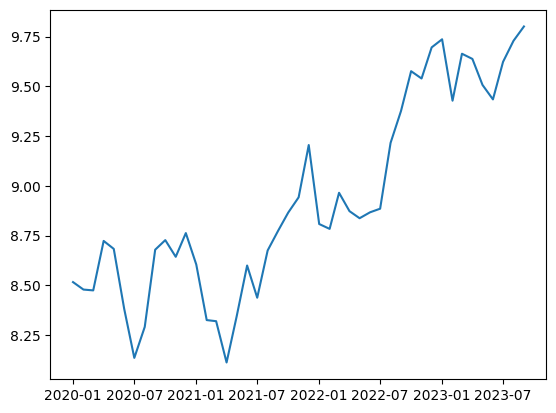

In [68]:
net_payment_count_id = merge_df[merge_df['ID'] == 43992][['net_payment_count']]

df_log = np.log(net_payment_count_id['net_payment_count'] + 1)

plt.plot(df_log)

In [71]:
moving_avg = df_log.rolling(12).mean()
moving_avg

month_id
2020-01-01         NaN
2020-02-01         NaN
2020-03-01         NaN
2020-04-01         NaN
2020-05-01         NaN
2020-06-01         NaN
2020-07-01         NaN
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
2020-11-01         NaN
2020-12-01    8.541875
2021-01-01    8.549243
2021-02-01    8.536472
2021-03-01    8.523583
2021-04-01    8.472713
2021-05-01    8.444499
2021-06-01    8.462647
2021-07-01    8.487825
2021-08-01    8.519820
2021-09-01    8.527735
2021-10-01    8.539245
2021-11-01    8.564142
2021-12-01    8.600981
2022-01-01    8.617924
2022-02-01    8.656089
2022-03-01    8.709829
2022-04-01    8.773156
2022-05-01    8.814203
2022-06-01    8.836471
2022-07-01    8.873727
2022-08-01    8.918752
2022-09-01    8.968902
2022-10-01    9.028087
2022-11-01    9.077806
2022-12-01    9.118677
2023-01-01    9.195983
2023-02-01    9.249631
2023-03-01    9.307824
2023-04-01    9.371534
2023-05-01    9.427319
2023-06-01    9.474568
2023-07-01    9.536024
20

In [73]:
ts_log_diff = df_log - df_log.shift()
ts_log_diff

month_id
2020-01-01         NaN
2020-02-01   -0.037509
2020-03-01   -0.004163
2020-04-01    0.248436
2020-05-01   -0.040002
2020-06-01   -0.301265
2020-07-01   -0.246064
2020-08-01    0.155572
2020-09-01    0.387685
2020-10-01    0.048134
2020-11-01   -0.083790
2020-12-01    0.119133
2021-01-01   -0.157755
2021-02-01   -0.279171
2021-03-01   -0.005585
2021-04-01   -0.207321
2021-05-01    0.231853
2021-06-01    0.255082
2021-07-01   -0.161696
2021-08-01    0.237368
2021-09-01    0.098733
2021-10-01    0.091268
2021-11-01    0.076856
2021-12-01    0.262435
2022-01-01   -0.396508
2022-02-01   -0.024510
2022-03-01    0.181326
2022-04-01   -0.092287
2022-05-01   -0.035512
2022-06-01    0.029750
2022-07-01    0.018154
2022-08-01    0.330583
2022-09-01    0.160254
2022-10-01    0.199677
2022-11-01   -0.036743
2022-12-01    0.156267
2023-01-01    0.040714
2023-02-01   -0.308405
2023-03-01    0.235855
2023-04-01   -0.026076
2023-05-01   -0.130610
2023-06-01   -0.072674
2023-07-01    0.188630
20

<Axes: xlabel='month_id', ylabel='net_payment_count'>

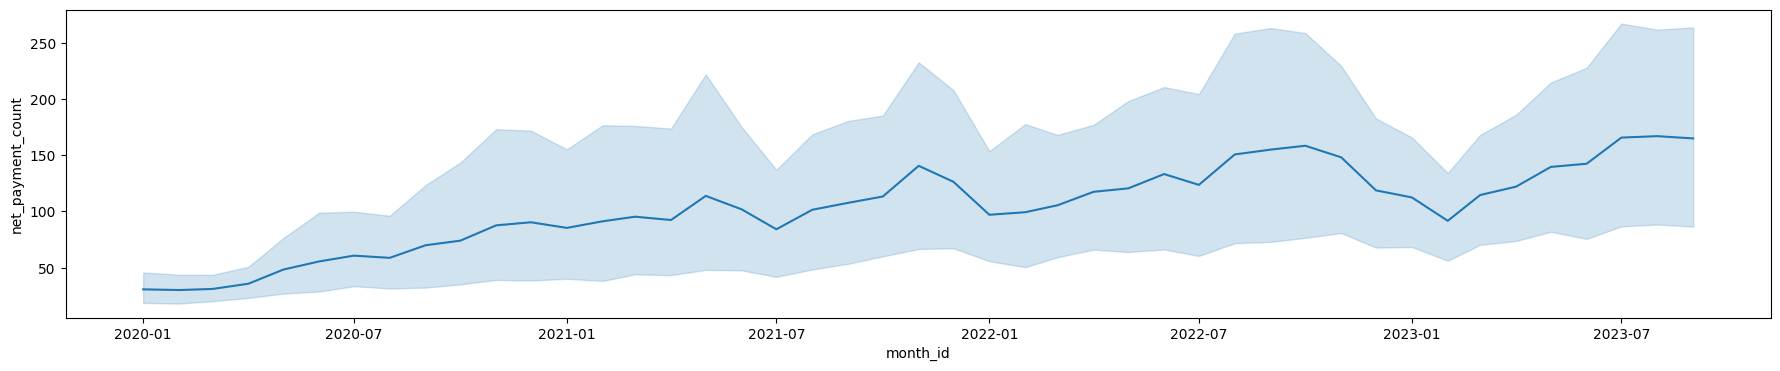

In [76]:
plt.figure(figsize=(22,4))
sns.lineplot(data = merge_df.reset_index(), x="month_id", y="net_payment_count")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(merge_df.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [74]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)


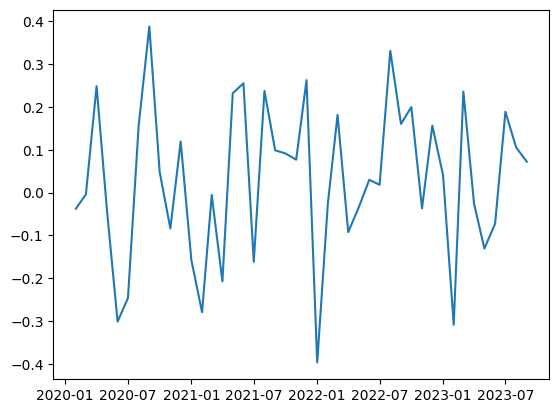

In [46]:
ts_log_diff = df_log - df_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)

In [51]:
train.set_index('month_id', inplace=True)

train.index

KeyError: "None of ['month_id'] are in the columns"

In [41]:
import matplotlib.pyplot as plt


In [46]:
df = train[train['ID'] == 43992].sort_values(by=['month_id'])


<Axes: xlabel='month_id'>

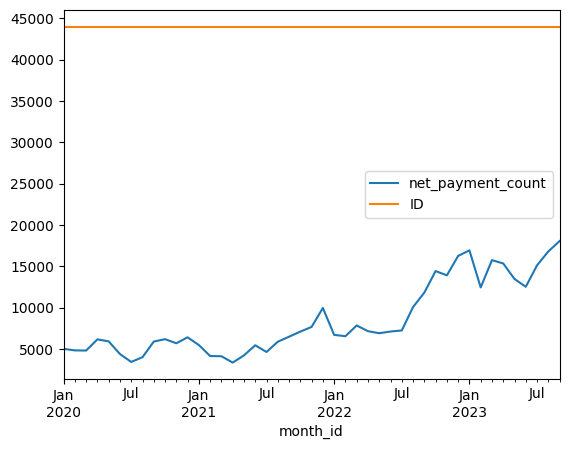

In [48]:
df.plot()


In [47]:
model = sm.tsa.ARIMA(ts_log_diff, order=(0, 1, 1))
results_ARIMA = model.fit()

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
forecast = results_ARIMA.get_forecast(steps=3)
forecast_index = pd.date_range(start=ts_log_diff.index[-1], periods=4, freq='MS')[1:]

forecast_values = np.exp(forecast.predicted_mean)
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
}, index=forecast_index)
print(forecast_df)

            Forecast
2023-10-01  1.029605
2023-11-01  1.029605
2023-12-01  1.029605


2023-10-01    511190.445684
2023-11-01    511190.445684
2023-12-01    511190.445684
Freq: MS, Name: predicted_mean, dtype: float64